<a href="https://colab.research.google.com/github/MishaDol/University-Course-Machine-Learning-Assignment/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages

In [1]:
import pandas as pd
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import datetime as dt
from google.colab import drive
import time
import gc

### Sklearn

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LassoLarsIC

In [3]:
# Set decimal size for pd frames
pd.options.display.float_format = '{:.3f}'.format

In [4]:
# drive.mount('/content/drive')

### Set directory

In [5]:
import os

# Set the desired working directory
desired_directory = "/content/drive/MyDrive/Thesis/Data"

# Change the current working directory to the desired one
os.chdir(desired_directory)

### Set the amount of CPU cores

In [6]:
# Determine the number of CPU cores
num_cores = os.cpu_count()
print(f'Number of CPU cores: {num_cores}')

Number of CPU cores: 2


# Load in data

## Load in Explanatory variables

In [276]:
# df = pd.read_csv('Explanatory variables.csv', parse_dates = ['start_datetime'])
df = pd.read_csv('Explanatory variables with Intraday.csv', parse_dates = ['start_datetime'])

# Set index to datetime
df.set_index('start_datetime', inplace=True)

# Keep 'Mid_price_upward' for the naive forecasts
df_naive = df[['Highest_price_upward', 'Mid_price_upward', 'Lowest_price_downward', 'posmin', 'minmin']].copy()

# Drop mid price as it is implied by the aFRR bid price ladder
# Mid price = (posmin + minmin)/2
df.drop(columns=['Mid_price_upward'], inplace=True)

## Load in Target

In [277]:
def preprocess_target(df, indeces, forecast_horizon):

  # Set the index
  df_target.set_index('start_datetime', inplace=True)

  # Shift the index by the forecasting horizon
  df = df.shift(forecast_horizon)

  # Only keep the indeces that are also in the explanatory dataframe
  df = df.loc[indeces]

  # Cast Regulation state to integer
  df['Regulation state'] = df['Regulation state'].astype(int)

  return df

In [278]:
df_target = pd.read_csv('Target Data.csv', parse_dates = ['start_datetime'])

# Set the forecasting horizon to one hour before the ISP (Gate closure)
forecast_horizon = -4

# Final preprocessing of target
df_target = preprocess_target(df_target, df.index, forecast_horizon)

# Feature engineering

In [444]:
df.columns

Index(['Day Ahead Price', 'Scheduled Generation', 'Forecast Generation Solar',
       'Net Physical Flow to Belgium',
       'Intraday Net Scheduled Flow to Belgium',
       'Net Physical Flow to Denmark',
       'Intraday Net Scheduled Flow to Denmark',
       'Net Physical Flow to Germany',
       'Intraday Net Scheduled Flow to Germany',
       'Net Physical Flow to Nordics',
       'Intraday Net Scheduled Flow to Nordics', 'Net Physical Flow to UK',
       'Intraday Net Scheduled Flow to UK', 'Total Net Physical Flow',
       'Total Scheduled Flow', 'Inter Delta Net Flow', 'wind_Percentage',
       'wind_offshore_Percentage', 'solar_Percentage', 'gas_Percentage',
       'Total_min', 'Minmax', 'Min600', 'Min300', 'Min100', 'minmin', 'posmin',
       'pos100', 'pos300', 'pos600', 'posmax', 'total_plus', 'regulate_up',
       'regulate_down', 'Emergency capacity', 'Highest_price_upward',
       'Lowest_price_downward', 'regulation_state', 'realized_variance_up',
       'realized_varia

## Store data characteristics in database

In [683]:
database = {
    'lags': {
            'backward_dynamic': [16, 4],     # Include past 4 hours and the hour preceding the ISP at D-1 is also added
            'backward_semi_static': 4,        # Add an hour of lags
            'backward_static': 1,     # These variables remain stable over time
            'forward': forecast_horizon     # These variables hold future information
    },

    'publication_times': {
            'ENTSO-E': 5,     # As the ENTSO-E publishes these values after 1 hour. Only data from >=t-5 can be used
            'NED': 5,        # Still must check
            'TenneT': 1,     # TenneT publishes real time, but t is the start of an interval . Only data from >=t-1 can be used
            'Intraday': 1     # EPEX publishes 5 minutes before the ISP, but t is the start of an interval. Only data from >=t-1 can be used
    },

    # Define the model specific features
    'Model features': {
      'LEAR': [
            'regulate_up',
            'regulate_down',
            'Highest_price_upward',
            'Lowest_price_downward',
            # 'id1_price',
            # 'Excess ID1',
            # 'id3_price',
            'Excess ID3',

            # 'id3_volume',
            # 'id1_volume',
            'Emergency capacity',
            'Net IGCC',
            'regulation_state',
            'Inter Delta Net Flow',
            # 'Net Physical Flow to Belgium',
            # 'Net Physical Flow to Denmark',
            # 'Net Physical Flow to Germany',
            # 'Net Physical Flow to Nordics',
            # 'Net Physical Flow to UK',
            # 'Total Net Physical Flow',

            'wind_Percentage',
            'wind_offshore_Percentage',
            'solar_Percentage',
            'gas_Percentage',
            'Forecast Error Wind',
            'Residual Load',

            'Day Ahead Price',
            # '3to1_price',
            'Excess 3to1',
            # 'start_to_1_price',
            # 'Excess start_to_1',
            'Day Ahead Delta',
            'Scheduled Generation',
            'Residual Load Forecast',
            'Forecast Generation Wind',
            # 'Forecast Generation Solar',
            'Intraday Net Scheduled Flow to Belgium',
            'Intraday Net Scheduled Flow to Denmark',
            'Intraday Net Scheduled Flow to Germany',
            'Intraday Net Scheduled Flow to Nordics',
            'Intraday Net Scheduled Flow to UK',
            # 'Total Scheduled Flow',
            'Total_min',
            # 'Minmax',
            # 'Min600',
            # 'Min300',
            # 'Min100',
            'minmin',
            'posmin',
            # 'pos100',
            # 'pos300',
            # 'pos600',
            # 'posmax',
            'total_plus',
            'excess_Minmax',
            'excess_Min600',
            'excess_Min300',
            'excess_Min100',
            # 'excess_minmin',
            # 'excess_posmin',
            'excess_pos100',
            'excess_pos300',
            'excess_pos600',
            'excess_posmax',
            'Month',
            'Day of week',
            'Quarter hour of day',
            # 'Relative Humidity',
            # 'Cloud Cover',
            # 'Temperature 2m',
            # 'Wind speed u10',
            # 'Wind speed v10',
            # 'Wind speed u100',
            # 'Wind speed v100',
            # 'Strongest Wind Gust u10',
            # 'Strongest Wind Gust v10',
            ],

      'XGBoost': [
        'regulate_up',
        'regulate_down',
        'Highest_price_upward',
        'Lowest_price_downward',
        # 'id1_price',
        # 'Excess ID1',
        # 'id3_price',
        'Excess ID3',

        # 'id3_volume',
        # 'id1_volume',
        'Emergency capacity',
        'Net IGCC',
        'regulation_state',
        'Inter Delta Net Flow',
        # 'Net Physical Flow to Belgium',
        # 'Net Physical Flow to Denmark',
        # 'Net Physical Flow to Germany',
        # 'Net Physical Flow to Nordics',
        # 'Net Physical Flow to UK',
        # 'Total Net Physical Flow',

        'wind_Percentage',
        'wind_offshore_Percentage',
        'solar_Percentage',
        'gas_Percentage',
        'Forecast Error Wind',
        'Residual Load',

        'Day Ahead Price',
        '3to1_price',
        # 'Excess 3to1',
        # 'start_to_1_price',
        # 'Excess start_to_1',
        'Day Ahead Delta',
        'Scheduled Generation',
        'Residual Load Forecast',
        'Forecast Generation Wind',
        # 'Forecast Generation Solar',
        'Intraday Net Scheduled Flow to Belgium',
        'Intraday Net Scheduled Flow to Denmark',
        'Intraday Net Scheduled Flow to Germany',
        'Intraday Net Scheduled Flow to Nordics',
        'Intraday Net Scheduled Flow to UK',
        # 'Total Scheduled Flow',
        'Total_min',
        # 'Minmax',
        # 'Min600',
        # 'Min300',
        # 'Min100',
        'minmin',
        'posmin',
        # 'pos100',
        # 'pos300',
        # 'pos600',
        # 'posmax',
        'total_plus',
        'excess_Minmax',
        'excess_Min600',
        'excess_Min300',
        'excess_Min100',
        'excess_minmin',
        'excess_posmin',
        'excess_pos100',
        'excess_pos300',
        'excess_pos600',
        'excess_posmax',
        'Month',
        'Day of week',
        'Quarter hour of day',
        # 'Relative Humidity',
        # 'Cloud Cover',
        # 'Temperature 2m',
        # 'Wind speed u10',
        # 'Wind speed v10',
        # 'Wind speed u100',
        # 'Wind speed v100',
        # 'Strongest Wind Gust u10',
        # 'Strongest Wind Gust v10',
        ]
    },

    'type': {
      'backward_dynamic': [
          'regulate_up',
          'regulate_down',
          'Highest_price_upward',
          'Lowest_price_downward',
          'id1_price',
          'Excess ID1',
          'id3_price',
          'Excess ID3',
          ],

      'backward_semi_static': [
          'id3_volume',
          'id1_volume',
          'Emergency capacity',
          'Net IGCC',
          'regulation_state',
          'Inter Delta Net Flow',
          'Net Physical Flow to Belgium',
          'Net Physical Flow to Denmark',
          'Net Physical Flow to Germany',
          'Net Physical Flow to Nordics',
          'Net Physical Flow to UK',
          'Total Net Physical Flow',
          ],

      'backward_static': [
          'wind_Percentage',
          'wind_offshore_Percentage',
          'solar_Percentage',
          'gas_Percentage',
          'Forecast Error Wind',
          'Residual Load',
          ],

      'forward': [
          'Day Ahead Price',
          '3to1_price',
          'Excess 3to1',
          'start_to_1_price',
          'Excess start_to_1',
          'Day Ahead Delta',
          'Scheduled Generation',
          'Residual Load Forecast',
          'Forecast Generation Wind',
          'Forecast Generation Solar',
          'Intraday Net Scheduled Flow to Belgium',
          'Intraday Net Scheduled Flow to Denmark',
          'Intraday Net Scheduled Flow to Germany',
          'Intraday Net Scheduled Flow to Nordics',
          'Intraday Net Scheduled Flow to UK',
          'Total Scheduled Flow',
          'Total_min',
          'Minmax',
          'Min600',
          'Min300',
          'Min100',
          'minmin',
          'posmin',
          'pos100',
          'pos300',
          'pos600',
          'posmax',
          'total_plus',
          'excess_Minmax',
          'excess_Min600',
          'excess_Min300',
          'excess_Min100',
          'excess_minmin',
          'excess_posmin',
          'excess_pos100',
          'excess_pos300',
          'excess_pos600',
          'excess_posmax',
          'Month',
          'Day of week',
          'Quarter hour of day',
          'Relative Humidity',
          'Cloud Cover',
          'Temperature 2m',
          'Wind speed u10',
          'Wind speed v10',
          'Wind speed u100',
          'Wind speed v100',
          'Strongest Wind Gust u10',
          'Strongest Wind Gust v10',
      ]
    },

    'var_sources_backward': {
        'Net Physical Flow to Belgium': 'ENTSO-E',
        'Net Physical Flow to Denmark': 'ENTSO-E',
        'Net Physical Flow to Germany': 'ENTSO-E',
        'Net Physical Flow to Nordics': 'ENTSO-E',
        'Net Physical Flow to UK': 'ENTSO-E',
        'Total Net Physical Flow': 'ENTSO-E',
        'Inter Delta Net Flow': 'ENTSO-E',
        'wind_Percentage': 'NED',
        'wind_offshore_Percentage': 'NED',
        'solar_Percentage': 'NED',
        'gas_Percentage': 'NED',
        'Residual Load': 'ENTSO-E',
        'Forecast Error Wind': 'ENTSO-E',
        'id1_price': 'Intraday',
        'id1_volume': 'Intraday',
        'id3_price': 'Intraday',
        'id3_volume': 'Intraday',
        'Excess ID1': 'Intraday',
        'Excess ID3': 'Intraday',
        'Net IGCC': 'TenneT',
        'regulate_up': 'TenneT',
        'regulate_down': 'TenneT',
        'regulation_state': 'TenneT',
        'Emergency capacity': 'TenneT',
        'Highest_price_upward': 'TenneT',
        'Lowest_price_downward': 'TenneT',
        'realized_variance_up': 'TenneT',
        'realized_variance_down': 'TenneT'
    }
}

## Universal functions

In [545]:
# Function to create lagged variables
def create_lagged_variables(df, columns_to_lag, amount_of_lags, time_gap = 0, step = 1):
    lagged_data = {}
    for col in columns_to_lag:
        data_source = database['var_sources_backward'][col]
        publication_time = database['publication_times'][data_source] + time_gap
        for lag in range(0, amount_of_lags, step):
            lagged_data[f'{col}_lag_{lag + publication_time}'] = df[col].shift(lag + publication_time)
    return pd.DataFrame(lagged_data, index=df.index)

In [546]:
def create_lagged_df(df):

    # Add static variables
    static_vars = list(set(database['type']['backward_static']) & set(df.columns))
    amount_of_static_lags = database['lags']['backward_static']
    lagged_df = create_lagged_variables(df, static_vars, amount_of_static_lags)

    # Add semi static variables
    semi_static_vars = list(set(database['type']['backward_static']) & set(df.columns))
    amount_of_semi_static_lags = database['lags']['backward_semi_static']
    lagged_df = pd.concat([lagged_df, create_lagged_variables(df, semi_static_vars, amount_of_semi_static_lags)], axis=1)

    # Add dynamic variables lags
    dynamic_vars = list(set(database['type']['backward_dynamic']) & set(df.columns))
    amount_of_dynamic_lags = database['lags']['backward_dynamic']
    lagged_df = pd.concat([lagged_df, create_lagged_variables(df,	dynamic_vars, amount_of_dynamic_lags[0])], axis=1)

    # Add additional dynamic variables on the last hour
    lagged_df = pd.concat([lagged_df, create_lagged_variables(df,	dynamic_vars, amount_of_dynamic_lags[1], time_gap = 91)], axis=1)

    return lagged_df

In [547]:
def created_forward_shifted_df(df, time_vars):

  # Update forward variables as variables are removed and time variables are added
  forward_vars = list(set(database['type']['forward']) & set(df.columns)) + time_vars

  # Shift forward looking variables to the target ISP
  shift_forward_df = df[forward_vars].shift(forecast_horizon)

  return shift_forward_df

In [548]:
def create_X_matrix(df, time_vars):

  # Create a dataframe holding lagged variables
  lagged_df = create_lagged_df(df)

  # Create a dataframe that holding the shifted forward looking variables
  shift_forward_df = created_forward_shifted_df(df, time_vars)

  # Combine lagged data with the forward looking variables
  df = pd.concat([shift_forward_df, lagged_df], axis=1)

  return df

## LEAR

### Functions

In [450]:
def handle_time_variables_LEAR(df):

  # Define a function to categorize hours into intervals
  def categorize_hour(hour):
      if 22 <= hour or hour < 6:
          return '10pm-6am'
      elif 6 <= hour < 10:
          return '6am-10am'
      elif 10 <= hour < 17:
          return '10am-5pm'
      else:
          return '5pm-10pm'

  # Create a dummy for the weekend
  df['weekend'] = (df['Day of week'] >= 5).astype(int)  # True for weekend, False for weekdays
  df.drop(columns=['Day of week'], inplace=True)

  # Apply the function to create a new column 'time_interval'
  df['time_interval'] = df.index.hour.map(categorize_hour)

  # Convert 'time_interval' to dummy variables
  df = pd.get_dummies(df, columns=['time_interval'])

  # Manually drop the '10pm-6am' dummy variable to prevent multicollinearity
  df.drop(columns=['time_interval_10pm-6am'], inplace=True)

  # Rename the remaining dummy variable columns for clarity
  df.rename(columns={
      'time_interval_6am-10am': '6am-10am',
      'time_interval_10am-5pm': '10am-5pm',
      'time_interval_5pm-10pm': '5pm-10pm'
  }, inplace=True)

  df.drop(columns=['Month', 'Quarter hour of day'], inplace=True)

  # Define the final time variables
  time_vars = [
      'weekend',
      '6am-10am',
      '10am-5pm',
      '5pm-10pm'
  ]

  return df, time_vars

In [451]:
def handle_missing_data(df):

  # Fill missing upward/downward prices with the cheapest price for up or down regulation
  df.loc[:, 'Highest_price_upward'] = df['Highest_price_upward'].fillna(df['posmin'])
  df.loc[:, 'Lowest_price_downward'] = df['Lowest_price_downward'].fillna(df['minmin'])

  # Create dummy variables for whether or not there is above 600MW regulating power
  if 'pos600' in df.columns:
    df.loc[:, 'pos600'] = df['pos600'].notna().astype(int)
  if 'Min600' in df.columns:
    df.loc[:, 'Min600'] = df['Min600'].notna().astype(int)

  # Create dummy variables for whether or not there is above 600MW regulating power
  if 'excess_pos600' in df.columns:
     df.loc[:, 'excess_pos600'] = df['excess_pos600'].notna().astype(int)
  if 'excess_Min600' in df.columns:
     df.loc[:, 'excess_Min600'] = df['excess_Min600'].notna().astype(int)

  return df

In [452]:
def handle_high_correlations(df):

  # Drop posmin and minmin as they highly correlate with the Day ahead price, pos100 and min100 (corr > 0.9)
  df.drop(columns=['posmin', 'minmin'], inplace=True)

  # NOTE: These variables are dropped due to performance
  # Drop excess posmin and minmin
  for col in ['excess_pos300', 'excess_pos100', 'excess_Min100', 'excess_Min300']:
    if col in df.columns:
      df.drop(columns=[col], inplace=True)

  # # Drop highly correlated variables
  # df.drop(columns=['Forecast Generation Solar'], inplace=True)

  return df

In [453]:
def preprocess_LEAR(df):
  df = df.copy()

  # Only use the selected variables
  selected_variables = database['Model features']['LEAR']
  df = df[selected_variables]

  # Construct time features
  df, time_vars = handle_time_variables_LEAR(df)

  # Handle the missing values
  df = handle_missing_data(df)

  # Detect variables highly correlate and drop one to avoid multicollinearity
  df = handle_high_correlations(df)

  # Create a dataframe with lagged and forward variables
  df = create_X_matrix(df, time_vars)

  return df

### Preprocess

In [454]:
X_LEAR_original = preprocess_LEAR(df)

## XGBoost

### Functions

In [656]:
def handle_time_variables_XGB(df):

  def encode(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)

    df.drop(columns=[col], inplace=True)
    return df

  df = df.copy()
  # df = encode(df, 'Month', 12)
  # df = encode(df, 'Day of week', 7)
  # df = encode(df, 'Quarter hour of day', 24)

  time_vars = [
      # 'Month_sin',
      # 'Month',
      # 'Day of week_sin',
      # 'Quarter hour of day_sin',
      # 'Month_cos',
      # 'Day of week_cos',
      # 'Quarter hour of day_cos'
  ]

  return df, time_vars

In [657]:
def drop_variables(df):
  # Drop the posmin and minmin variables as they are not necessary
  df.drop(columns=[
            'minmin',
            'posmin',], inplace=True)
  return df

In [658]:
def preprocess_XGB(df):
  df = df.copy()

  # Only use the selected variables
  selected_variables = database['Model features']['XGBoost']
  df = df[selected_variables]

  # Drop variables that are not necessary
  df = drop_variables(df)

  # Construct cyclically encoded time features for XGB
  df, time_vars = handle_time_variables_XGB(df)

  # Create a dataframe with lagged and forward variables
  df = create_X_matrix(df, time_vars)

  return df

### Preprocess

In [659]:
X_XGB_original = preprocess_XGB(df)

# Model Configuration

## Define y and X and Train-Test split

### Functions

In [687]:
def duplicate_X(df, duplicated_indices):

  df = df.copy()

  # Duplicate rows where Regulation state == 2
  duplicates = df.loc[duplicated_indices].copy()

  # Append the duplicates to the original dataframe
  df = pd.concat([df, duplicates])

  # Sort by index to maintain datetime order
  df = df.sort_index()

  return df

In [688]:
def duplicate_dual_prices(df):

  df = df.copy()

  # Duplicate rows where Regulation state == 2
  duplicates = df[df['Regulation state'] == 2].copy()

  # Append the duplicates to the original dataframe
  df = pd.concat([df, duplicates])

  # Sort by index to maintain datetime order
  df = df.sort_index()

  # Create a new series initialized with 'take_from_grid_price'
  df['imbalance_price'] = df['take_from_grid_price']

  # Identify the duplicates' index positions
  duplicate_positions = df.index.duplicated(keep='first')

  # Set 'feed_into_grid_price' for the duplicate rows in 'new_series'
  df.loc[duplicate_positions, 'imbalance_price'] = df.loc[duplicate_positions, 'feed_into_grid_price']

  # Store the indeces of the duplicated observations
  duplicated_indeces = df[duplicate_positions].index

  # Return the duplicated imbalance price and the duplicated indeces
  return df['imbalance_price'], duplicated_indeces

In [689]:
def unify_price(df_target, X_LEAR, X_XGB):
  X_LEAR = X_LEAR_original.copy()
  X_XGB = X_XGB_original.copy()

  # Duplicate the regulation state 2 values and return the new target y
  y, duplicated_indices = duplicate_dual_prices(df_target)

  # Duplicate X such that it contains duplicated rows for Regulation state 2
  X_LEAR = duplicate_X(X_LEAR, duplicated_indices)
  X_XGB = duplicate_X(X_XGB, duplicated_indices)

  return y, X_LEAR, X_XGB, duplicated_indices

### Create target variable y and adjust X

In [690]:
# Handle regulation state 2 by duplicating dual observations. Adjust X accordingly
y, X_LEAR, X_XGB, duplicated_indices = unify_price(df_target, X_LEAR_original, X_XGB_original)

quantiles = [0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95]

### Define Train and Test set

In [691]:
train_start = '2021-09-01 00:00:00'
train_end = '2022-08-31 23:45:00'
test_start = '2022-09-01 00:00:00'
test_end = '2022-12-31 23:45:00'

In [692]:
# train_start = '2022-01-01 00:00:00'
# train_end = '2022-12-31 23:45:00'
# test_start = '2023-01-01 00:00:00'
# test_end = '2023-12-31 23:45:00'

In [693]:
y_train = y[train_start:train_end]
y_test = y[test_start:test_end]

## Metrics and Functions

### Metrics

In [694]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
def print_mean_metrics(y, y_pred):

  def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

  # Evaluate the model
  mae = mean_absolute_error(y, y_pred)
  rmse = np.sqrt(mean_squared_error(y, y_pred))
  smape = smape(y, y_pred)

  print(f"MAE: {mae}, RMSE: {rmse}, sMAPE: {smape}")

In [695]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
def retrieve_mean_metrics(y, y_pred):

  def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

  # Evaluate the model
  mae = mean_absolute_error(y, y_pred)
  rmse = np.sqrt(mean_squared_error(y, y_pred))
  smape = smape(y, y_pred)

  return mae, rmse, smape

In [696]:
# Notice that we use absolute values due to the possibility of 'quantile crossing' where lower > upper.

def WIS_and_coverage(y_true,lower,upper,alpha):

    assert np.isnan(y_true) == False, "y_true contains NaN value(s)"
    assert np.isinf(y_true) == False, "y_true contains inf values(s)"
    assert np.isnan(lower)  == False, "lower interval value contains NaN value(s)"
    assert np.isinf(lower)  == False, "lower interval value contains inf values(s)"
    assert np.isnan(upper)  == False, "upper interval value contains NaN value(s)"
    assert np.isinf(upper)  == False, "upper interval value contains inf values(s)"
    assert alpha > 0 and alpha <= 1,  f"alpha should be (0,1]. Found: {alpha}"

    # WIS for one single row
    score = np.abs(upper-lower)
    if y_true < np.minimum(upper,lower):
        score += ((2/alpha) * (np.minimum(upper,lower) - y_true))
    if y_true > np.maximum(upper,lower):
        score += ((2/alpha) * (y_true - np.maximum(upper,lower)))
    # coverage for one single row
    coverage  = 1 # assume is within coverage
    if (y_true < np.minimum(upper,lower)) or (y_true > np.maximum(upper,lower)):
        coverage = 0
    return score, coverage

# vectorize the function
v_WIS_and_coverage = np.vectorize(WIS_and_coverage)

def mean_winkler_score(y_true,lower,upper,alpha):
    """
    This is an implementation of the Winkler Interval score (https://otexts.com/fpp3/distaccuracy.html#winkler-score).
    The mean over all of the individual Winkler Interval scores (MWIS) is returned, along with the coverage.

    See:
    [1] Robert L. Winkler "A Decision-Theoretic Approach to Interval Estimation", Journal of the American Statistical Association, vol. 67, pp. 187-191 (1972) (https://doi.org/10.1080/01621459.1972.10481224)
    [2] Tilmann Gneiting and Adrian E Raftery "Strictly Proper Scoring Rules, Prediction, and Estimation", Journal of the American Statistical Association, vol. 102, pp. 359-378 (2007) (https://doi.org/10.1198/016214506000001437) (Section 6.2)

    Version: 1.0.4
    Author:  Carl McBride Ellis
    Date:    2023-12-07
    """

    assert y_true.ndim == 1, "y_true: pandas Series or 1D array expected"
    assert lower.ndim  == 1, "lower: pandas Series or 1D array expected"
    assert upper.ndim  == 1, "upper: pandas Series or 1D array expected"
    assert isinstance(alpha, float) == True, "alpha: float expected"

    WIS_scores, coverage = v_WIS_and_coverage(y_true,lower,upper,alpha)
    MWIS      = np.mean(WIS_scores)
    MWIS      = float(MWIS)
    coverage  = coverage.sum()/coverage.shape[0]
    coverage  = float(coverage)

    return MWIS,coverage

In [697]:
# NOTE: This function is copied from https://github.com/LaurensSluyterman/XGBoost_quantile_regression.git
def compute_crossing_percentage(quantiles):
    """
    Compute the crossing percentage.

    Arguments:
        quantiles: An array where each row contains the quantiles for a single
            data point. The quantiles are assumed to be in decreasing order.
    """
    crossings = 0
    max_crossings = (len(quantiles[0]) -1) * len(quantiles)
    for loc in quantiles:
        for i in range(1, len(loc)):
            crossings += (loc[i] > loc[i-1])
    return crossings / max_crossings * 100

In [698]:
from sklearn.metrics import mean_pinball_loss
def print_quantile_metrics(y, y_pred, alphas):

  pinball_scores = []
  # Calculate the Pinball losses of the alphas
  for i, alpha in enumerate(alphas):
    pinball = mean_pinball_loss(y, y_pred[:, i], alpha=alpha)
    print(f"Pinball {alpha}: {pinball}")
    pinball_scores.append(pinball)

  print()

  # Print the Continuous Ranked Probability Score (CRPS)
  print(f"CRPS: {np.mean(pinball_scores)}")

  print()

  # Print the Winkler score and Coverage for all Prediction intervals
  for i in range(0, int((len(alphas)-1)/2)):
    interval_width = np.round(alphas[-(i+1)] - alphas[i], 2)
    winkler, coverage = mean_winkler_score(y, y_pred[:, i], y_pred[:, -(i+1)], interval_width)
    print(f"Winkler {100*interval_width}%: {winkler}")
    print(f"Coverage {100*interval_width}%: {coverage}")

In [699]:
from sklearn.metrics import mean_pinball_loss
def retrieve_quantile_metrics(y, y_pred, alphas):

  pinball_scores = []
  # Calculate the Pinball losses of the alphas
  for i, alpha in enumerate(alphas):
    pinball = mean_pinball_loss(y, y_pred[:, i], alpha=alpha)
    pinball_scores.append(pinball)

  crps = np.mean(pinball_scores)

  winkler_scores = []
  coverage_scores = []
  # Print the Winkler score and Coverage for all Prediction intervals
  for i in range(0, int((len(alphas)-1)/2)):
    interval_width = np.round(alphas[-(i+1)] - alphas[i], 2)
    winkler, coverage = mean_winkler_score(y, y_pred[:, i], y_pred[:, -(i+1)], interval_width)
    winkler_scores.append(winkler)
    coverage_scores.append(coverage)

  return np.array(pinball_scores), crps, np.array(winkler_scores), np.array(coverage_scores)

### Bootstrap Empirical Error Distribution

Point predictions to probabilistic

In [700]:
def bootstrap_quantiles(resid, quantiles):
    """
    Create bootstrap samples of the past year residuals of every 15 minute interval.
    Additionally, calculate and store the quantiles of the sample

    Parameters:
    resid (pd.Series): Residuals with DateTime index.
    quantiles (list): List of quantiles to add to predictions.

    Returns:
    np.ndarray: Array storing the quantiles of the distribution of the residuals.
    """

    # Define the interval settings
    interval_minutes = 15
    n_intervals = 96
    n_samples = 10000

    # Generate all possible quarter-hour intervals in a day
    quarter_hours = [pd.Timestamp(f'{hour:02}:{minute:02}').time()
                     for hour in range(24) for minute in range(0, 60, 15)]

    # Check if all 96 intervals are present in the residuals, raise error if not
    unique_times = pd.Index(resid.index.time).unique()
    if len(unique_times) != n_intervals:
        missing_intervals = set(quarter_hours) - set(unique_times)
        raise ValueError(f'Missing quarter-hour intervals: {missing_intervals}')

    # Initialize a dictionary to store the results
    bootstrap_quantiles = {q: np.zeros(n_intervals) for q in quantiles}

    for i, current_time in enumerate(quarter_hours):
        # Filter values for the specific interval
        past_resids = resid[resid.index.time == current_time]

        # Draw bootstrap samples
        bootstrap_samples = past_resids.sample(n=n_samples, replace=True).to_numpy()

        # Calculate and store the quantiles
        for q in quantiles:
            bootstrap_quantiles[q][i] = np.quantile(bootstrap_samples, q)

    return bootstrap_quantiles

In [701]:
def add_quantiles_to_predictions(y_pred, bootstrap_quantiles, quantiles):
    """
    Add quantiles to predictions.

    Parameters:
    y_pred (pd.Series): Predictions with DateTime index.
    bootstrap_quantiles (dict): Dictionary with quantiles as keys and corresponding bootstrap quantiles as values.
    quantiles (list): List of quantiles to add to predictions.

    Returns:
    np.ndarray: Array with predictions and their quantile-adjusted values.
    """
    # Initialise array for storing the quantile predictions
    y_pred_quantiles = np.empty((len(y_pred), len(quantiles)))

    for count, (index, y_pred_value) in enumerate(y_pred.items()):
        # Calculate the interval index
        interval_index = int(index.time().hour * 4 + index.time().minute / 15)

        # Add the quantile-adjusted values
        for i, q in enumerate(quantiles):
            y_pred_quantiles[count, i] = y_pred_value + bootstrap_quantiles[q][interval_index]

    return y_pred_quantiles

In [702]:
def add_quantiles(resid, y_pred, quantiles):

  # Create quantiles
  bootstrap_data = bootstrap_quantiles(resid, quantiles)

  # Add the quantiles to predictions
  y_pred_quantiles = add_quantiles_to_predictions(y_pred, bootstrap_data, quantiles)

  return y_pred_quantiles

Recalibrating quantiles

In [703]:
def bootstrap_residual_quantile(resid, quantile):
    """
    Create bootstrap samples of the past year residuals of every 15 minute interval.
    Additionally, calculate and store the quantiles of the sample

    Parameters:
    resid (pd.Series): Residuals with DateTime index.
    quantiles (list): List of quantiles to add to predictions.

    Returns:
    np.ndarray: Vector storing the quantile of the distribution of the residuals.
    """

    # Define the interval settings
    interval_minutes = 15
    n_intervals = 96
    n_samples = 10000

    # Generate all possible quarter-hour intervals in a day
    quarter_hours = [pd.Timestamp(f'{hour:02}:{minute:02}').time()
                     for hour in range(24) for minute in range(0, 60, 15)]

    # Check if all 96 intervals are present in the residuals, raise error if not
    unique_times = pd.Index(resid.index.time).unique()
    if len(unique_times) != n_intervals:
        missing_intervals = set(quarter_hours) - set(unique_times)
        raise ValueError(f'Missing quarter-hour intervals: {missing_intervals}')

    # Initialize a dictionary to store the results
    bootstrap_quantiles = np.zeros(n_intervals)

    for i, current_time in enumerate(quarter_hours):
        # Filter values for the specific interval
        past_resids = resid[resid.index.time == current_time]

        # Draw bootstrap samples
        bootstrap_samples = past_resids.sample(n=n_samples, replace=True).to_numpy()

        # Calculate and store the quantiles
        bootstrap_quantiles[i] = np.quantile(bootstrap_samples, quantile)

    return bootstrap_quantiles

In [704]:
def recalibrate_quantile_predictions(y_pred_df, bootstrap_quantiles, quantiles):
    """
    Add quantiles to predictions.

    Parameters:
    y_pred_df (pd.DataFrame): DataFrame of quantile predictions with DateTime index and quantiles as columns.
    bootstrap_quantiles (dict): Dictionary with quantiles as keys and corresponding bootstrap quantiles as values.
    quantiles (list): List of quantiles to be recalibrated.

    Returns:
    np.ndarray: Array with recalibrated quantile predictions.
    """
    # Ensure the input DataFrame index is DateTimeIndex
    if not isinstance(y_pred_df.index, pd.DatetimeIndex):
        raise ValueError("The index of y_pred_df must be a DateTimeIndex")

    # Initialize array for storing the recalibrated quantile predictions
    y_pred_quantiles = np.empty((len(y_pred_df), len(quantiles)))

    for count, (index, row) in enumerate(y_pred_df.iterrows()):
        # Calculate the interval index
        interval_index = int(index.time().hour * 4 + index.time().minute / 15)

        # Add the quantile-adjusted values
        for i, q in enumerate(quantiles):
            y_pred_quantiles[count, i] = row[q] + bootstrap_quantiles[q][interval_index]

    return y_pred_quantiles

In [705]:
def recalibrate_quantiles(resid, y_pred, quantiles):

  # Create quantiles
  bootstrap_data = bootstrap_quantiles(resid, quantiles)

  # Add the quantiles to predictions
  y_pred_quantiles = add_quantiles_to_predictions(y_pred, bootstrap_data, quantiles)

  return y_pred_quantiles

### Plotting

In [706]:
def plot_point_predictions(y, y_pred, pred_label, benchmarks, benchmark_labels, save=False, filename=None):
    """
    Plot the actual values, predicted median, and prediction intervals.

    Parameters:
    y (pd.Series): Actual values with DateTime index.
    y_pred (dict): Predicted values with quantiles as keys.
    pred_label (str): Label for the predicted median line.
    benchmark (list of pd.Series): Benchmark values with DateTime index.
    benchmark_label (list of str): Label for the benchmark line.
    """
    # Plot the series
    plt.figure(figsize=(14, 8))

    plt.plot(y, label='Imbalance Price')
    plt.plot(y_pred, label=pred_label)

    # Plot the benchmarks
    for i, benchmark in enumerate(benchmarks):
      plt.plot(benchmark, label=benchmark_labels[i])

    # plt.title('Actual vs Predicted', fontsize=18)
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('Price', fontsize=16)
    plt.legend(fontsize=14)
    plt.grid(True)

    # Increase font size of x-ticks and y-ticks
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()

    if save:
      plt.savefig(f'{filename}.png')

    plt.show()

In [707]:
def plot_prediction_intervals(y, y_pred, pred_label, benchmarks, benchmark_labels, save=False, filename=None):
    """
    Plot the actual values, predicted median, and prediction intervals.

    Parameters:
    y (pd.Series): Actual values with DateTime index.
    y_pred (dict): Predicted values with quantiles as keys.
    pred_label (str): Label for the predicted median line.
    benchmark (pd.Series): Benchmark values with DateTime index.
    benchmark_label (str): Label for the benchmark line.
    """

    # Plot the series
    plt.figure(figsize=(14, 8))

    # Set the median and prediction interval bounds
    lower_bound = y_pred[0.05]
    quarter_bound = y_pred[0.25]
    median = y_pred[0.5]
    three_quarter_bound = y_pred[0.75]
    upper_bound = y_pred[0.95]

    plt.plot(y, label='Imbalance Price')
    plt.plot(median, label=pred_label)
    plt.fill_between(y.index, lower_bound, upper_bound, alpha=0.3, label='90% Prediction Interval')
    plt.fill_between(y.index, quarter_bound, three_quarter_bound, alpha=0.3, label='50% Prediction Interval', color='pink')

    # Plot the benchmarks
    for i, benchmark in enumerate(benchmarks):
      plt.plot(benchmark, label=benchmark_labels[i])

    # plt.title('Actual vs Predicted', fontsize=18)
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('Imbalance Price', fontsize=16)
    plt.legend(fontsize=14)
    plt.grid(True)

    # Increase font size of x-ticks and y-ticks
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout()

    if save:
      plt.savefig(f'{filename}.png')

    plt.show()

# Naive

## Define naive benchmark

### Functions

In [59]:
def average_dual_pricing(df):

  # Use combine_first to handle NaN values as specified
  combined = df['Highest_price_upward'].combine_first(df['Lowest_price_downward'])
  average = (df['Highest_price_upward'] + df['Lowest_price_downward']) / 2

  # Replace NaNs in the average with the combined values where appropriate
  averaged_price = average.combine_first(combined)

  # Fill missing values with the mid price
  averaged_price = averaged_price.fillna(df['Mid_price_upward'])

  # Calculate the average of the minimum and maximum prices of upward and downward regulation
  mid_price_ladder = (df['posmin'] + df['minmin'])/2

  # Fill final missing values with the average of the minimum and maximum prices of upward and downward regulation
  averaged_price = averaged_price.fillna(mid_price_ladder)

  return averaged_price

### Define benchmark

In [60]:
# Take the average of the dual prices and fill missing values with the mid prices
df_naive.loc[:, 'average_price'] = average_dual_pricing(df_naive)

In [61]:
# As the true imbalance prices are uploaded only after 3 weeks. The most recent balance delta price at t-1 is taken as a naive forecast.
y_pred_naive_imbalance = df_naive['average_price'].shift(1)
y_pred_day_ahead = df['Day Ahead Price'].shift(forecast_horizon)
y_pred_3to1 = df['3to1_price'].shift(forecast_horizon)
y_pred_start_to_1 = df['start_to_1_price'].shift(forecast_horizon)

## Point forecasts

In [66]:
# y_pred_naive = y_pred_day_ahead
# y_pred_naive = y_pred_3to1
y_pred_naive = y_pred_start_to_1

y_pred_naive = duplicate_X(y_pred_naive, duplicated_indices)

y_pred_train_naive = y_pred_naive[train_start:train_end]
y_pred_test_naive = y_pred_naive[test_start:test_end]

print('Train:')
print_mean_metrics(y_train, y_pred_train_naive)
print('Test:')
print_mean_metrics(y_test, y_pred_test_naive)

Train:
MAE: 109.78130382013286, RMSE: 168.39585983347942, sMAPE: 55.78704388263099
Test:
MAE: 115.34935192708662, RMSE: 191.12195058836346, sMAPE: 62.147066275459004


In [ ]:
# # Load in Nside predictions
# Nside_forecasts = pd.read_csv('Nside Forecasts/Preprocessed NSide Forecasts.csv', parse_dates=['start_datetime'])
# Nside_forecasts.set_index('start_datetime', inplace=True)
# Nside_forecasts_shortage = Nside_forecasts['ForeNeg'].shift(-4)
# Nside_forecasts_surplus = Nside_forecasts['ForePos'].shift(-4)

# # Define non missing values for both target and NSide
# non_nan_mask = Nside_forecasts_surplus.notna() & y.groupby(y.index).min().notna() & y_pred_start_to_1.notna()

# # Define quantities and handle NaN's and duplicates
# Nside_forecasts_surplus_train = Nside_forecasts_surplus[non_nan_mask][train_start:train_end]
# Nside_forecasts_surplus_test = Nside_forecasts_surplus[non_nan_mask][test_start:test_end]
# Nside_forecasts_surplus_full = Nside_forecasts_surplus[non_nan_mask]

# # Format target correctly
# y_train_Nside = y_train.groupby(y_train.index).min()[non_nan_mask]
# y_test_Nside = y_test.groupby(y_test.index).min()[non_nan_mask]
# y_full_Nside = y.groupby(y.index).min()[non_nan_mask]

# print('Nside Forecasts')
# print()

# print('Train:')
# print_mean_metrics(y_train_Nside, Nside_forecasts_surplus_train)
# print()
# print('Test:')
# print_mean_metrics(y_test_Nside, Nside_forecasts_surplus_test)
# print()
# print('Full dataset:')
# print_mean_metrics(y_full_Nside, Nside_forecasts_surplus_full)

# print()
# print('Intraday ID3 to ID1 Price')
# print()

# # y_pred_naive = y_pred_day_ahead
# # y_pred_naive = y_pred_3to1
# y_pred_naive = y_pred_start_to_1

# y_pred_train_naive = y_pred_naive[non_nan_mask][train_start:train_end]
# y_pred_test_naive = y_pred_naive[non_nan_mask][test_start:test_end]
# y_pred_full_naive = y_pred_naive[non_nan_mask]
# print('Train:')
# print_mean_metrics(y_train_Nside, y_pred_train_naive)
# print()
# print('Test:')
# print_mean_metrics(y_test_Nside, y_pred_test_naive)
# print()
# print('Full dataset:')
# print_mean_metrics(y_full_Nside, y_pred_full_naive)

## Probabilistic forecasts

In [67]:
# Define the desired quantiles
# quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
quantiles = [0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95]

# Calculate the residuals over the training set
resid = y_train - y_pred_train_naive

# Add the quantiles to training predictions
y_pred_train_quantiles = add_quantiles(resid, y_pred_train_naive, quantiles)

# Add the quantiles to test predictions
y_pred_test_quantiles = add_quantiles(resid, y_pred_test_naive, quantiles)

# np.save('Results/naive_quantile_predictions_20220901-20230101_test.npy', y_pred_test_quantiles)

y_pred_test_quantiles_df = pd.DataFrame(y_pred_test_quantiles, index=y_test.index, columns=quantiles)

In [68]:
print('Train:')
print_quantile_metrics(y_train, y_pred_train_quantiles, quantiles)
print()
print('Test:')
print_quantile_metrics(y_test, y_pred_test_quantiles, quantiles)

Train:
Pinball 0.05: 17.84666523066774
Pinball 0.15: 34.06947073452265
Pinball 0.25: 43.37267299792703
Pinball 0.35: 49.0851751825843
Pinball 0.45: 52.4798400985854
Pinball 0.5: 53.449560982024494
Pinball 0.55: 53.96412460307817
Pinball 0.65: 53.47816812052771
Pinball 0.75: 50.246655769385534
Pinball 0.85: 41.763618987266085
Pinball 0.95: 21.333792597469802

CRPS: 42.82634048218536

Winkler 90.0%: 555.7873501098295
Coverage 90.0%: 0.901636784719873
Winkler 70.0%: 358.20131663603104
Coverage 70.0%: 0.7007988758489683
Winkler 50.0%: 374.47731506925027
Coverage 50.0%: 0.5011319576361601
Winkler 30.0%: 602.9743416336484
Coverage 30.0%: 0.30167321554034715
Winkler 10.0%: 1981.6480397999119
Coverage 10.0%: 0.10161596710817351

Test:
Pinball 0.05: 17.04779597230592
Pinball 0.15: 33.93205718048511
Pinball 0.25: 44.332464921405204
Pinball 0.35: 50.97040598594653
Pinball 0.45: 55.02569346576172
Pinball 0.5: 56.31014544455944
Pinball 0.55: 57.09262243655839
Pinball 0.65: 57.017489030919734
Pinbal

In [ ]:
# np.save('Results/Naive/naive_quantile_predictions_20220901-20230101_test.npy', y_pred_test_quantiles)

## Rolling predictions

### Predict

In [ ]:
import traceback
import time
def rolling_walk_forward_naive(y_pred, y, start_datetime, end_datetime, window_length, quantiles):
  try:
      start_datetime, end_datetime = pd.to_datetime(start_datetime), pd.to_datetime(end_datetime)

      # Create a numpy series that will store the predictions.
      predictions = []

      current_date = start_datetime
      while current_date <= end_datetime:

        if current_date.day == 1:
          print(f'Current date: {current_date}')

        # Create training set equal to the pre-set window length and test set to one day
        train_start, train_end  = current_date - pd.Timedelta(days=window_length), current_date - pd.Timedelta(minutes=15)
        test_start, test_end  = current_date, current_date + pd.Timedelta(days=1) - pd.Timedelta(minutes=15)

        y_train, y_test = y[train_start:train_end], y[test_start:test_end]
        y_pred_train = y_pred[train_start:train_end]
        y_pred_test = y_pred[test_start:test_end]

        # Assuming y_train and y_pred_train_LEAR are defined and resid is computed
        resid = y_train - y_pred_train

        bootstrap_data = bootstrap_quantiles(resid, quantiles)

        # Add the quantiles to training predictions
        y_pred_quantiles = pd.DataFrame(add_quantiles_to_predictions(y_pred_test, bootstrap_data, quantiles), index=y_pred_test.index, columns=quantiles)
        predictions.append(y_pred_quantiles)

        current_date += pd.Timedelta(days=1)

      return pd.concat(predictions)

  except Exception:
        # print(y_pred_test)
        print("Error: rolling_walk_forward_validation method.")
        traceback.print_exc()

In [ ]:
y_pred_naive = df['3to1_price']
window_length = 365
test_start_2023 = '2023-01-01 00:00:00'
test_end_2023 = '2023-12-31 22:45:00'
test_start_temp = pd.to_datetime(test_end) - pd.Timedelta(days=2)
# test_end_temp = pd.to_datetime(test_start) + pd.Timedelta(days=2)

# Define the desired quantiles
quantiles = [0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95]

# Record the start time
start_time = time.time()

rolling_pred_quantiles_naive = rolling_walk_forward_naive(y_pred_naive, y, test_start_temp, test_end, window_length, quantiles)

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Elapsed time:", elapsed_time, "seconds")

# np.save('Results/naive_quantile_predictions_2023-2024_test.npy', rolling_pred_quantiles_naive)

### Print metrics

In [ ]:
rolling_pred_quantiles_naive = np.load('Results/Naive/naive_quantile_predictions_2023-2024_test.npy')

In [ ]:
print('Test 2023:')
print()
print('Mean:')
print_mean_metrics(y[test_start_2023:test_end_2023], pd.DataFrame(rolling_pred_quantiles_naive, index=y[test_start_2023:test_end_2023].index, columns=quantiles)[0.5])
print()
print('Probabilistic:')
print()
print_quantile_metrics(y[test_start_2023:test_end_2023], rolling_pred_quantiles_naive, quantiles)

# LEAR

## Scaling

In [178]:
X_LEAR_train = X_LEAR[train_start:train_end]
X_LEAR_test = X_LEAR[test_start:test_end]

# Min-Max Scaling
scaler_minmax = MinMaxScaler()

X_LEAR_train_scaled = scaler_minmax.fit_transform(X_LEAR_train)
X_LEAR_test_scaled = scaler_minmax.transform(X_LEAR_test)

# Convert the scaled data back to DataFrame and keep the original column names
X_LEAR_train = pd.DataFrame(X_LEAR_train_scaled, columns=X_LEAR_train.columns, index=X_LEAR_train.index)
X_LEAR_test = pd.DataFrame(X_LEAR_test_scaled, columns=X_LEAR_test.columns, index=X_LEAR_test.index)

## Mean Predictions

In [179]:
# Fit LassoLarsIC model
lasso_lars_ic = LassoLarsIC(criterion='aic')
lasso_lars_ic.fit(X_LEAR_train, y_train)

# Print the selected alpha and AIC
print(f"Selected alpha: {lasso_lars_ic.alpha_}")

# Get the coefficients
coefficients = lasso_lars_ic.coef_

# Print the coefficients
for lag, coef in zip(X_LEAR.columns, coefficients):
    print(f"Coefficient for {lag}: {coef}")

Selected alpha: 0.021311358882965915
Coefficient for Intraday Net Scheduled Flow to Germany: 14.251249962884577
Coefficient for Intraday Net Scheduled Flow to UK: -2.298970773320337
Coefficient for Scheduled Generation: -6.800672255919806
Coefficient for Day Ahead Price: 856.6037399322089
Coefficient for excess_posmax: 2.1010299261034318
Coefficient for excess_Minmax: 11.686364723133916
Coefficient for Forecast Generation Wind: -2.484848713572359
Coefficient for Intraday Net Scheduled Flow to Nordics: -1.2975985385485145
Coefficient for excess_pos600: 11.190269958520359
Coefficient for Intraday Net Scheduled Flow to Belgium: 6.435323291411643
Coefficient for Excess 3to1: 704.5776314770942
Coefficient for Intraday Net Scheduled Flow to Denmark: 2.889960431177525
Coefficient for Residual Load Forecast: 1.5781091260610869
Coefficient for excess_Min600: 7.710714882469108
Coefficient for total_plus: -92.60975127987986
Coefficient for Total_min: -37.966656522273254
Coefficient for Day Ahead 

In [180]:
# Make predictions
y_pred_train_LEAR = pd.Series(lasso_lars_ic.predict(X_LEAR_train), index=X_LEAR_train.index)
y_pred_test_LEAR = pd.Series(lasso_lars_ic.predict(X_LEAR_test), index=X_LEAR_test.index)

print('Train:')
print_mean_metrics(y_train, y_pred_train_LEAR)
print()
print('Test:')
print_mean_metrics(y_test, y_pred_test_LEAR)

Train:
MAE: 107.32060900187906, RMSE: 162.71299044656007, sMAPE: 56.01723640559187

Test:
MAE: 114.3862495620936, RMSE: 188.4066262780257, sMAPE: 61.26238409937984


In [72]:
# Make predictions
y_pred_train_LEAR = pd.Series(lasso_lars_ic.predict(X_LEAR_train), index=X_LEAR_train.index)
y_pred_test_LEAR = pd.Series(lasso_lars_ic.predict(X_LEAR_test), index=X_LEAR_test.index)

print('Train:')
print_mean_metrics(y_train, y_pred_train_LEAR)
print()
print('Test:')
print_mean_metrics(y_test, y_pred_test_LEAR)

Train:
MAE: 107.33091232695763, RMSE: 162.7043614942476, sMAPE: 56.028137897400256

Test:
MAE: 114.37130732664225, RMSE: 188.67060050170394, sMAPE: 61.365731016048464


## Bootstrap to obtain Quantiles

In [ ]:
# Assuming y_train and y_pred_train_LEAR are defined and resid is computed
resid = y_train - y_pred_train_LEAR

# Define the desired quantiles
# quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
quantiles = [0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95]

bootstrap_data = bootstrap_quantiles(resid, quantiles)

# Add the quantiles to training predictions
y_pred_train_LEAR_quantiles = add_quantiles_to_predictions(y_pred_train_LEAR, bootstrap_data, quantiles)

# Add the quantiles to test predictions
y_pred_test_LEAR_quantiles = add_quantiles_to_predictions(y_pred_test_LEAR, bootstrap_data, quantiles)

In [ ]:
print('Train:')
print_quantile_metrics(y_train, y_pred_train_LEAR_quantiles, quantiles)
print()
print('Test:')
print_quantile_metrics(y_test, y_pred_test_LEAR_quantiles, quantiles)

Train:
Pinball 0.05: 16.83796030121345
Pinball 0.15: 32.27946381174012
Pinball 0.25: 41.67082811388254
Pinball 0.35: 47.79551328758409
Pinball 0.45: 51.555646918171966
Pinball 0.5: 52.65202130549758
Pinball 0.55: 53.21461979714709
Pinball 0.65: 52.637914070944
Pinball 0.75: 49.14233173998756
Pinball 0.85: 40.453651258421324
Pinball 0.95: 20.625333913734845

CRPS: 41.71502586530223

Winkler 90.0%: 538.4131607275569
Coverage 90.0%: 0.9022092690416093
Winkler 70.0%: 347.3546595973392
Coverage 70.0%: 0.7023601967264306
Winkler 50.0%: 363.2526394154804
Coverage 50.0%: 0.5027453225428713
Winkler 30.0%: 579.8823561387591
Coverage 30.0%: 0.3028181841838195
Winkler 10.0%: 1924.9969272621086
Coverage 10.0%: 0.10273491373702152

Test:
Pinball 0.05: 16.51749934958011
Pinball 0.15: 33.53125763223513
Pinball 0.25: 43.99832865046776
Pinball 0.35: 50.878156512548664
Pinball 0.45: 55.061781854113065
Pinball 0.5: 56.32244253657255
Pinball 0.55: 57.020149534641725
Pinball 0.65: 56.69892912803928
Pinball 

In [ ]:
# Make predictions
y_pred_train_LEAR = pd.DataFrame(y_pred_train_LEAR_quantiles, index=X_LEAR_train.index, columns=quantiles)[0.5]
y_pred_test_LEAR = pd.DataFrame(y_pred_test_LEAR_quantiles, index=X_LEAR_test.index, columns=quantiles)[0.5]

print('Train:')
print_mean_metrics(y_train, y_pred_train_LEAR)
print()
print('Test:')
print_mean_metrics(y_test, y_pred_test_LEAR)

Train:
MAE: 105.30404261099515, RMSE: 163.6806394829365, sMAPE: 56.734719372805756

Test:
MAE: 112.6448850731451, RMSE: 189.9391717817271, sMAPE: 62.757962868650395


## Rolling predictions

### Functions

In [ ]:
import traceback
import time
def rolling_walk_forward_LEAR(model, X, y, start_datetime, end_datetime, window_length, quantiles=None):
  try:
      start_datetime, end_datetime = pd.to_datetime(start_datetime), pd.to_datetime(end_datetime)

      # Create a numpy series that will store the predictions.
      predictions = []

      current_date = start_datetime
      while current_date <= end_datetime:

        if current_date.day == 1:
          print(f'Current date: {current_date}')

        # If value is missing skip to next interval
        if current_date not in X.index:
          current_date += pd.Timedelta(minutes=15)
          continue

        # Create training set equal to the pre-set window length and test set to one day
        train_start, train_end  = current_date - pd.Timedelta(days=window_length), current_date - pd.Timedelta(minutes=15)
        test_start, test_end  = current_date, current_date + pd.Timedelta(days=1) - pd.Timedelta(minutes=15)
        X_train, y_train = X[train_start:train_end], y[train_start:train_end]  # Drop NaN's if present
        X_test, y_test = X[test_start:test_end], y[test_start:test_end]  # Drop NaN's if present

        # Check for possible bugs
        if X_train.shape[0] != y_train.shape[0]:
          print(f"Mismatch after dropping NaNs: X_train length = {X_train.shape[0]}, y_train length = {y_train.shape[0]}")

        if X_train.isna().any().any():
          print('X contains NaNs')

        if X_test.shape[0] == 0:
          print('X empty')
          current_date += pd.Timedelta(minutes=15)
          continue

        if X_test.isna().any().any():
          X_test = X_test.dropna()

        # Fit model
        model.fit(X_train, y_train)

        y_pred_test = pd.Series(model.predict(X_test), index=X_test.index)

        if quantiles is None:
          predictions.append(y_pred_test)
        else:
          y_pred_train = model.predict(X_train)

          # Assuming y_train and y_pred_train_LEAR are defined and resid is computed
          resid = y_train - y_pred_train

          bootstrap_data = bootstrap_quantiles(resid, quantiles)

          # Add the quantiles to training predictions
          y_pred_quantiles = pd.DataFrame(add_quantiles_to_predictions(y_pred_test, bootstrap_data, quantiles), index=X_test.index, columns=quantiles)
          predictions.append(y_pred_quantiles)

        current_date += pd.Timedelta(days=1)

      return pd.concat(predictions)

  except Exception:
        # print(y_pred_test)
        print("Error: rolling_walk_forward_validation method.")
        traceback.print_exc()

### Mean predictions

In [ ]:
test_start_2023 = '2023-01-01 00:00:00'
test_end_2023 = '2023-12-31 22:45:00'

In [ ]:
model = LassoLarsIC(criterion='aic')
window_length = 365
# test_start_2023 = '2023-10-01 00:00:00'
# test_end_2023 = '2023-12-31 22:45:00'

# Record the start time
start_time = time.time()

rolling_pred_LEAR_df = rolling_walk_forward_LEAR(model, X_LEAR, y, test_start_2023, test_end_2023, window_length)

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Elapsed time:", elapsed_time, "seconds")

# np.save('Results/LEAR_predictions_2023-2024_test.npy', rolling_pred_LEAR_df)

Current date: 2023-01-01 00:00:00
Current date: 2023-02-01 00:00:00
Current date: 2023-03-01 00:00:00
Current date: 2023-04-01 00:00:00
Current date: 2023-05-01 00:00:00
Current date: 2023-06-01 00:00:00
Current date: 2023-07-01 00:00:00
Current date: 2023-08-01 00:00:00
Current date: 2023-09-01 00:00:00
Current date: 2023-10-01 00:00:00
Current date: 2023-11-01 00:00:00
Current date: 2023-12-01 23:00:00
Elapsed time: 564.0818860530853 seconds


In [ ]:
# Load in Nside predictions
Nside_forecasts = pd.read_csv('Nside Forecasts/Preprocessed NSide Forecasts.csv', parse_dates=['start_datetime'])
Nside_forecasts.set_index('start_datetime', inplace=True)
Nside_forecasts_shortage = Nside_forecasts['ForeNeg'].shift(-4)
Nside_forecasts_surplus = Nside_forecasts['ForePos'].shift(-4)

# Define non missing values for both target and NSide
non_nan_mask = Nside_forecasts_surplus.notna() & y.groupby(y.index).min().notna() & y_pred_start_to_1.notna()

# Define quantities and handle NaN's and duplicates
Nside_forecasts_surplus_train = Nside_forecasts_surplus[non_nan_mask][train_start:train_end]
Nside_forecasts_surplus_test = Nside_forecasts_surplus[non_nan_mask][test_start:test_end]
Nside_forecasts_surplus_full = Nside_forecasts_surplus[non_nan_mask]
Nside_forecasts_surplus_2023 = Nside_forecasts_surplus[non_nan_mask][test_start_2023:test_end_2023]

# Format target correctly
y_train_Nside = y_train.groupby(y_train.index).min()[non_nan_mask]
y_test_Nside = y_test.groupby(y_test.index).min()[non_nan_mask]
y_full_Nside = y.groupby(y.index).min()[non_nan_mask]
y_2023_Nside = y.groupby(y.index).min()[non_nan_mask][test_start_2023:test_end_2023]


print('Nside Forecasts:')
# print()

# print('Train:')
# print_mean_metrics(y_train_Nside, Nside_forecasts_surplus_train)
# print()
# print('Test:')
# print_mean_metrics(y_test_Nside, Nside_forecasts_surplus_test)
# print()
# print('Full dataset:')
# print_mean_metrics(y_full_Nside, Nside_forecasts_surplus_full)
# print()
# print('2023:')
print_mean_metrics(y_2023_Nside, Nside_forecasts_surplus_2023)

print()
print('Intraday ID3 to ID1 Price:')

# y_pred_naive = y_pred_day_ahead
y_pred_naive = y_pred_3to1
# y_pred_naive = y_pred_start_to_1

y_pred_train_naive = y_pred_naive[non_nan_mask][train_start:train_end]
y_pred_test_naive = y_pred_naive[non_nan_mask][test_start:test_end]
y_pred_full_naive = y_pred_naive[non_nan_mask]
y_pred_2023_naive = y_pred_naive[non_nan_mask][test_start_2023:test_end_2023]
y_pred_2023_day_ahead = y_pred_day_ahead[non_nan_mask][test_start_2023:test_end_2023]


# print('Train:')
# print_mean_metrics(y_train_Nside, y_pred_train_naive)
# print()
# print('Test:')
# print_mean_metrics(y_test_Nside, y_pred_test_naive)
# print()
# print('Full dataset:')
# print_mean_metrics(y_full_Nside, y_pred_full_naive)
# print()
# print('2023:')
print_mean_metrics(y_2023_Nside, y_pred_2023_naive)
print()
print('Day ahead')
print_mean_metrics(y_2023_Nside, y_pred_2023_day_ahead)


print()
print('LEAR:')
rolling_pred_LEAR_df = pd.Series(np.load('Results/LEAR_predictions_2023-2024_test.npy'), index=y[test_start_2023:test_end_2023].index)
# print('2023:')
print_mean_metrics(y_2023_Nside, rolling_pred_LEAR_df.groupby(rolling_pred_LEAR_df.index).mean()[non_nan_mask])

Nside Forecasts:
MAE: 50.77924312847879, RMSE: 135.35629987047787, sMAPE: 52.82204157600098

Intraday ID3 to ID1 Price:
MAE: 77.26738640083823, RMSE: 180.04904660446616, sMAPE: 71.29325022526422

Day ahead
MAE: 79.09656653468757, RMSE: 187.67951088646998, sMAPE: 73.60197681260784

LEAR:
MAE: 80.77768479170336, RMSE: 180.79064425684157, sMAPE: 73.51277396050006


### Quantile Predictions

In [ ]:
test_start_2023 = '2023-01-01 00:00:00'
test_end_2023 = '2023-12-31 22:45:00'

In [ ]:
model = LassoLarsIC(criterion='aic')
window_length = 365
test_start_temp = pd.to_datetime(test_end) - pd.Timedelta(days=2)
# test_end_temp = pd.to_datetime(test_start) + pd.Timedelta(days=2)

# Define the desired quantiles
quantiles = [0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95]

# Record the start time
start_time = time.time()

rolling_pred_quantiles_LEAR = rolling_walk_forward_LEAR(model, X_LEAR, y, test_start_temp, test_end, window_length, quantiles)

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Elapsed time:", elapsed_time, "seconds")

# np.save('Results/LEAR/LEAR_quantile_predictions_20220901-20230101_test.npy', rolling_pred_quantiles_LEAR)
# np.save('Results/LEAR/LEAR_quantile_predictions_2023-2024_test.npy', rolling_pred_quantiles_LEAR)

Elapsed time: 14.638197422027588 seconds


In [ ]:
rolling_pred_quantiles_LEAR = np.load('Results/LEAR/LEAR_quantile_predictions_20220901-20230101_test.npy')
# rolling_pred_quantiles_LEAR = np.load('Results/LEAR/LEAR_quantile_predictions_2023-2024_test.npy')

In [ ]:
# Create a Dataframe holding the quantile predictions
rolling_pred_quantiles_LEAR_df = pd.DataFrame(rolling_pred_quantiles_LEAR, index=y_test.index, columns=quantiles)

In [ ]:
print('Test 2023:')
print()
print('Mean:')
print_mean_metrics(y[test_start_2023:test_end_2023], pd.DataFrame(rolling_pred_quantiles_LEAR, index=y[test_start_2023:test_end_2023].index, columns=quantiles)[0.5])
print()
print('Probabilistic:')
print()
print_quantile_metrics(y[test_start_2023:test_end_2023], rolling_pred_quantiles_LEAR, quantiles)

Test 2023:

Mean:
MAE: 77.94325345446693, RMSE: 181.52981381998333, sMAPE: 74.31002153484376

Probabilistic:

Pinball 0.05: 13.142945227443237
Pinball 0.15: 24.031319560478188
Pinball 0.25: 30.617673618834736
Pinball 0.35: 35.07143097932414
Pinball 0.45: 37.999216130824855
Pinball 0.5: 38.97162672723346
Pinball 0.55: 39.6356733670639
Pinball 0.65: 39.981799268403115
Pinball 0.75: 38.88936761256233
Pinball 0.85: 35.78382225611481
Pinball 0.95: 26.645529778056297

CRPS: 32.79730950239446

Wrinkler 90.0%: 494.9345816899152
Coverage 90.0%: 0.9405774752738487
Wrinkler 70.0%: 282.5151723201503
Coverage 70.0%: 0.7983622248218654
Wrinkler 50.0%: 278.02816492558827
Coverage 50.0%: 0.6026534084866532
Wrinkler 30.0%: 422.826431227508
Coverage 30.0%: 0.3724343294693183
Wrinkler 10.0%: 1406.8227344083082
Coverage 10.0%: 0.1265819419334255


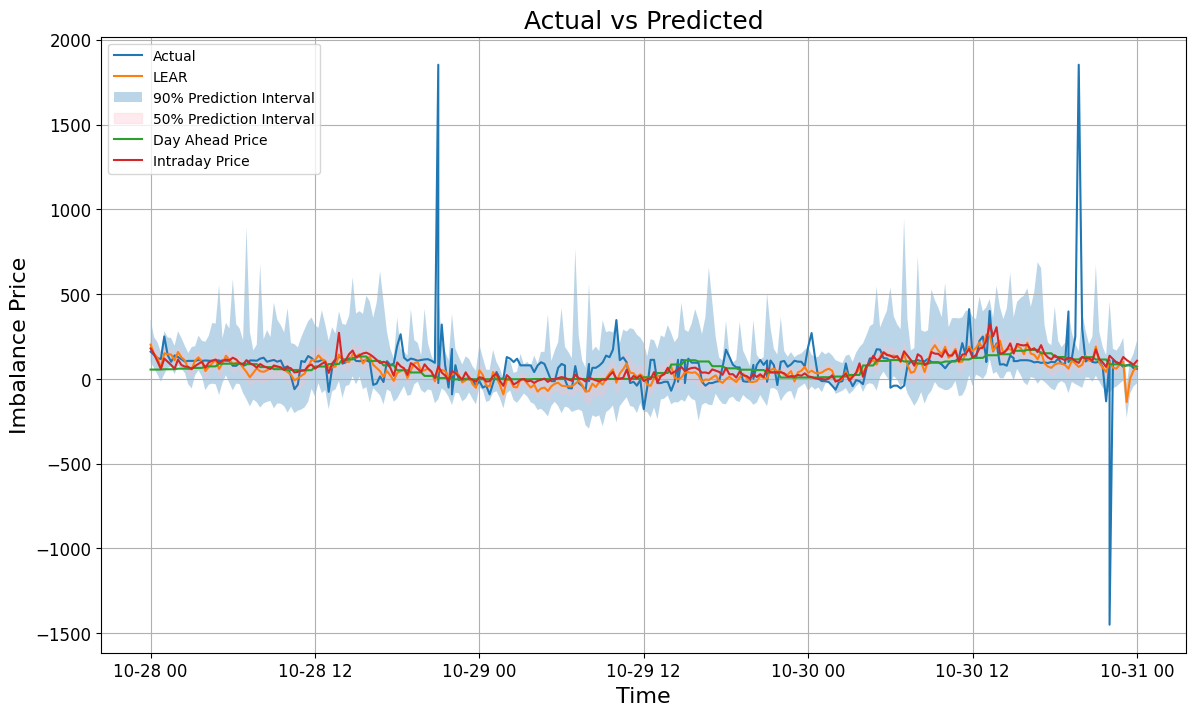

In [ ]:
# Create a Dataframe holding the quantile predictions
rolling_pred_quantiles_LEAR_df = pd.DataFrame(rolling_pred_quantiles_LEAR, index=y[test_start_2023:test_end_2023].index, columns=quantiles)

base_day=300

# Define the interval to plot
interval_start = str(pd.to_datetime(test_start_2023) + pd.Timedelta(days=base_day))
interval_end = str(pd.to_datetime(test_start_2023) + pd.Timedelta(days=base_day+3))

# Define the actual values
y_test_plot = y[interval_start:interval_end]

# Define the predicted values
LEAR_test_plot = rolling_pred_quantiles_LEAR_df[interval_start:interval_end]
LEAR_label = 'LEAR'

# Define the benchmarks to plot
day_ahead_plot = df['Day Ahead Price'].shift(-4)[interval_start:interval_end]
day_ahead_label = 'Day Ahead Price'

# Define the benchmarks to plot
intraday_plot = df['3to1_price'].shift(-4)[interval_start:interval_end]
intraday_label = 'Intraday Price'

benchmarks = [day_ahead_plot, intraday_plot]
benchmark_labels = [day_ahead_label, intraday_label]

# Plot the prediction intervals
plot_prediction_intervals(y_test_plot, LEAR_test_plot, LEAR_label, benchmarks, benchmark_labels)

# XGBoost

## Define train and test sets

In [708]:
X_XGB_train = X_XGB[train_start:train_end]
X_XGB_test = X_XGB[test_start:test_end]

## Install packages and functions

In [49]:
!pip install xgboost
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 4.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requ

In [50]:
import xgboost as xgb
import optuna
from optuna.samplers import TPESampler
from xgboost import XGBRegressor
import pickle

In [51]:
def train_test_split_time_series(X, y, test_size=0.2):
    """
    Split time series data into training and testing sets while maintaining temporal order.

    Parameters:
    X (pd.DataFrame or pd.Series): Features.
    y (pd.Series): Target variable.
    test_size (float): Proportion of the dataset to include in the test split.

    Returns:
    Tuple: Training and testing sets for features and target variable.
    """
    split_index = int((1 - test_size) * len(X))
    X_train = X.iloc[:split_index]
    X_val = X.iloc[split_index:]
    y_train = y.iloc[:split_index]
    y_val = y.iloc[split_index:]

    return X_train, X_val, y_train, y_val

## Mean predictions

### Bayesian Hyperparameter Tuning

In [ ]:
# Define Bayesian search objective
def objective(trial) -> float:
    # Define the search space for the hyperparameters
    params = {
        "n_estimators": trial.suggest_int('n_estimators', 300, 700),
        'max_depth': trial.suggest_int('max_depth', 2, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 20),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.3, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1, step=0.01),
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 100, step=10)  # Set early stopping here
    }

    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)

    scores = []

    for train_index, val_index in tscv.split(X_XGB_train):
        X_train_temp, X_val_temp = X_XGB_train.iloc[train_index], X_XGB_train.iloc[val_index]
        y_train_temp, y_val_temp = y_train.iloc[train_index], y_train.iloc[val_index]

        # Initialize the model with the current set of hyperparameters
        XGboostmodel = XGBRegressor(**params,
                                    objective = 'reg:absoluteerror',
                                    random_state=0,
                                    n_jobs=1)

        # Fit the model with early stopping
        XGboostmodel.fit(
            X_train_temp,
            y_train_temp,
            eval_set=[(X_val_temp, y_val_temp)],
            verbose=False
        )

        # Predict on the validation set
        y_pred = XGboostmodel.predict(X_val_temp)

        # Calculate the score
        score = mean_absolute_error(y_val_temp, y_pred)
        scores.append(score)

    # Return the average score from the cross-validation
    avg_score = np.mean(scores)
    return avg_score

# Callback function to save the study progress every 10 trials
def save_study_callback(study: optuna.study.Study, trial: optuna.trial.FrozenTrial):
    if trial.number % 10 == 0:
        study_name = '/content/drive/MyDrive/Thesis/Models/Optuna trials/study_progress_XGB_test_new.pkl'
        with open(study_name, 'wb') as f:
            pickle.dump(study, f)
        print(f'Study progress saved at trial {trial.number}')

# Bayesian search for best hyperparameters
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=0))
study.optimize(objective, n_trials=500, callbacks=[save_study_callback], n_jobs = 1)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params))

[I 2024-07-22 11:42:59,762] A new study created in memory with name: no-name-c3902c63-03c9-4f64-be7f-d0384367137a
[I 2024-07-22 11:43:23,937] Trial 1 finished with value: 115.84869924050918 and parameters: {'n_estimators': 172, 'max_depth': 4, 'reg_alpha': 2.1754497641001374, 'reg_lambda': 1.673767625343154, 'min_child_weight': 5, 'gamma': 1.944820876175416, 'learning_rate': 0.24730090484928396, 'colsample_bytree': 0.69}. Best is trial 1 with value: 115.84869924050918.


KeyboardInterrupt: 

When able to resume, run this code instead

In [ ]:
# Load the study
study_name = 'study_progress.pkl'
with open(study_name, 'rb') as f:
    study = pickle.load(f)

# Continue the optimization process
study.optimize(objective, n_trials=500 - len(study.trials))

print('Best trial after resuming: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params))

### Predicting on 'Test' set

In [ ]:
params = {'n_estimators': 629, 'max_depth': 2, 'reg_alpha': 4.361201524461671, 'reg_lambda': 3.5458763727470757, 'min_child_weight': 4.970618380969244, 'gamma': 1.0586302213008825, 'learning_rate': 0.24281871068762648, 'colsample_bytree': 0.8700000000000001, 'early_stopping_rounds': 90}

In [ ]:
params = {'n_estimators': 1258, 'max_depth': 2, 'reg_alpha': 4.567658078140772, 'reg_lambda': 2.9188722536021565, 'min_child_weight': 4.6486998975316896, 'gamma': 0.7989442548399103, 'learning_rate': 0.05091366820694188, 'colsample_bytree': 0.9199999999999999, 'early_stopping_rounds': 100}

In [ ]:
# RMSE
params = {'n_estimators': 385, 'max_depth': 2, 'reg_alpha': 0.20152686389475305, 'reg_lambda': 1.5737380811219703, 'min_child_weight': 10, 'gamma': 5.342844503010508, 'learning_rate': 0.12016822687611729, 'colsample_bytree': 0.94, 'subsample': 0.56, 'early_stopping_rounds': 90}

In [ ]:
# Train the model
xgb_model = XGBRegressor(**params,
                         objective = 'reg:absoluteerror',
                        #  objective = 'reg:squarederror',
                         random_state = 0,
                         n_jobs = num_cores - 1
)

# Start timing
start_time = time.time()

# Create validation set
X_train_temp, X_val_temp, y_train_temp, y_val_temp = train_test_split_time_series(X_XGB_train, y_train, test_size=0.1)

# Fit the model with early stopping
xgb_model.fit(
    X_train_temp,
    y_train_temp,
    eval_set=[(X_val_temp, y_val_temp)],
    verbose=False
)

# Make predictions
y_pred_train_XGB = pd.Series(xgb_model.predict(X_XGB_train), index=X_XGB_train.index)
y_pred_test_XGB = pd.Series(xgb_model.predict(X_XGB_test), index=X_XGB_test.index)

# End timing
end_time = time.time()

# Print time taken
print(f"Time taken: {end_time - start_time} seconds")

print('Train:')
print_mean_metrics(y_train, y_pred_train_XGB)
print('Test:')
print_mean_metrics(y_test, y_pred_test_XGB)

Time taken: 71.04078221321106 seconds
Train:
MAE: 100.200766250511, RMSE: 169.24504686960896, sMAPE: 50.53848581111944
Test:
MAE: 110.3148591157916, RMSE: 196.53925358484193, sMAPE: 58.89977057403102


In [ ]:
# Define parameters
params = {
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 500,
    'early_stopping_rounds': 50
}

# Train the model
xgb_model = XGBRegressor(**params,
                         objective = 'reg:squarederror',  # For regression task
                         random_state = 0,
                         n_jobs = num_cores - 1)

# Start timing
start_time = time.time()

# Create validation set
X_train_temp, X_val_temp, y_train_temp, y_val_temp = train_test_split_time_series(X_XGB_train, y_train, test_size=0.1)

# Fit the model with early stopping
xgb_model.fit(
    X_train_temp,
    y_train_temp,
    eval_set=[(X_val_temp, y_val_temp)],
    verbose=False,
)

# Make predictions
y_pred_train_XGB = pd.Series(xgb_model.predict(X_XGB_train), index=X_XGB_train.index)
y_pred_test_XGB = pd.Series(xgb_model.predict(X_XGB_test), index=X_XGB_test.index)

# End timing
end_time = time.time()

# Print time taken
print(f"Time taken: {end_time - start_time} seconds")

print('Train:')
print_mean_metrics(y_train, y_pred_train_XGB)
print('Test:')
print_mean_metrics(y_test, y_pred_test_XGB)

Time taken: 15.335707426071167 seconds
Train:
MAE: 98.97459451178855, RMSE: 149.21174206786603, sMAPE: 52.42132070561923
Test:
MAE: 120.17802543733453, RMSE: 194.45084215126394, sMAPE: 62.25465449138715


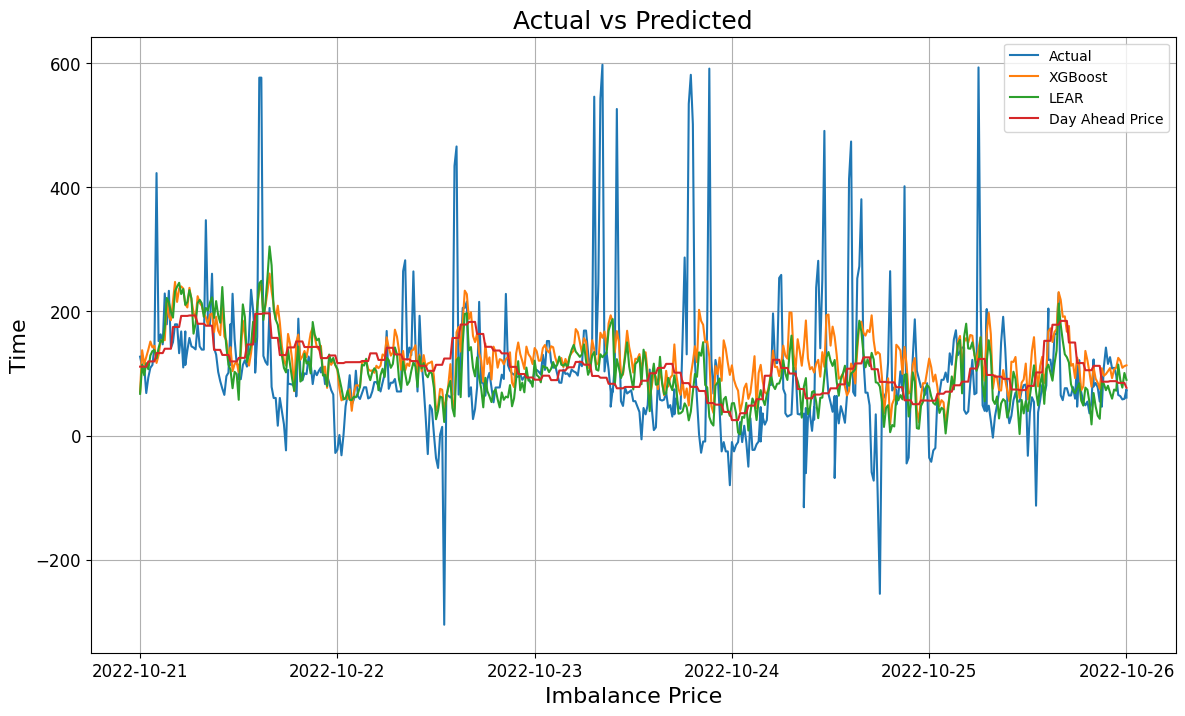

In [ ]:
base_day = 50

# Define the interval to be plotted
interval_start = str(pd.to_datetime(test_start) + pd.Timedelta(days=base_day))
interval_end = str(pd.to_datetime(test_start) + pd.Timedelta(days=base_day+5))

# Define the actual values
y_plot =  y_test[interval_start:interval_end]

# Define the predicted values
y_pred_plot = y_pred_test_XGB[interval_start:interval_end]
pred_label = 'XGBoost'

# Define the predicted values
y_pred_LEAR = y_pred_test_LEAR[interval_start:interval_end]
LEAR_label = 'LEAR'

# Define the benchmarks
day_ahead = df['Day Ahead Price'].shift(-4)[interval_start:interval_end]
day_ahead_label = 'Day Ahead Price'

# # Define the benchmark
# benchmark_3to1 = df['3to1_price'].shift(-4)[interval_start:interval_end]
# benchmark_3to1_label = 'Intraday 3 to 1 price'

benchmarks = [y_pred_LEAR, day_ahead]
benchmark_labels = [LEAR_label, day_ahead_label]

# Plot the series
plot_point_predictions(y_plot, y_pred_plot, pred_label, benchmarks, benchmark_labels)

### Bootstrap to obtain quantiles

In [ ]:
# Assuming y_train and y_pred_train_LEAR are defined and resid is computed
resid = y_train - y_pred_train_XGB

# Define the desired quantiles
# quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
quantiles = [0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95]

bootstrap_data = bootstrap_quantiles(resid, quantiles)

# Add the quantiles to training predictions
y_pred_train_XGB_quantiles = add_quantiles_to_predictions(y_pred_train_XGB, bootstrap_data, quantiles)

y_pred_train_XGB_quantiles_df = pd.DataFrame(y_pred_train_XGB_quantiles, index=y_train.index, columns=quantiles)

# Add the quantiles to test predictions
y_pred_test_XGB_quantiles = add_quantiles_to_predictions(y_pred_test_XGB, bootstrap_data, quantiles)

y_pred_test_XGB_quantiles_df = pd.DataFrame(y_pred_test_XGB_quantiles, index=y_test.index, columns=quantiles)

In [ ]:
print('Train:')
print_quantile_metrics(y_train, y_pred_train_XGB_quantiles, quantiles)
print()
print('Test:')
print_quantile_metrics(y_test, y_pred_test_XGB_quantiles, quantiles)

Train:
Pinball 0.05: 16.23684524111869
Pinball 0.15: 31.64592519287925
Pinball 0.25: 40.95227214287654
Pinball 0.35: 47.037198814266105
Pinball 0.45: 50.832476993840245
Pinball 0.5: 51.974542445996526
Pinball 0.55: 52.6327712696988
Pinball 0.65: 52.29406964116578
Pinball 0.75: 49.00133972753551
Pinball 0.85: 40.32415590644212
Pinball 0.95: 20.464658096089742

CRPS: 41.21784140653721

Wrinkler 90.0%: 528.0973613447964
Coverage 90.0%: 0.9022092690416093
Wrinkler 70.0%: 344.58905487974823
Coverage 70.0%: 0.7017877124046944
Wrinkler 50.0%: 359.8144474816482
Coverage 50.0%: 0.5023549923235057
Wrinkler 30.0%: 575.686081745735
Coverage 30.0%: 0.3028962502276926
Wrinkler 10.0%: 1913.7106794864637
Coverage 10.0%: 0.10239662754690468

Test:
Pinball 0.05: 16.904792791700604
Pinball 0.15: 35.045029583308285
Pinball 0.25: 45.95365600423161
Pinball 0.35: 52.964535295865815
Pinball 0.45: 57.229408917668955
Pinball 0.5: 58.481914678873466
Pinball 0.55: 59.17296284729633
Pinball 0.65: 58.79595547016987

In [ ]:
print('Train:')
print_mean_metrics(y_train, y_pred_train_XGB_quantiles_df[0.5])
print('Test:')
print_mean_metrics(y_test, y_pred_test_XGB_quantiles_df[0.5])

Train:
MAE: 104.12884336434001, RMSE: 162.40659811443146, sMAPE: 55.188561680889876
Test:
MAE: 116.73653237694529, RMSE: 192.64457060101634, sMAPE: 62.021270144999576


### Feature importances

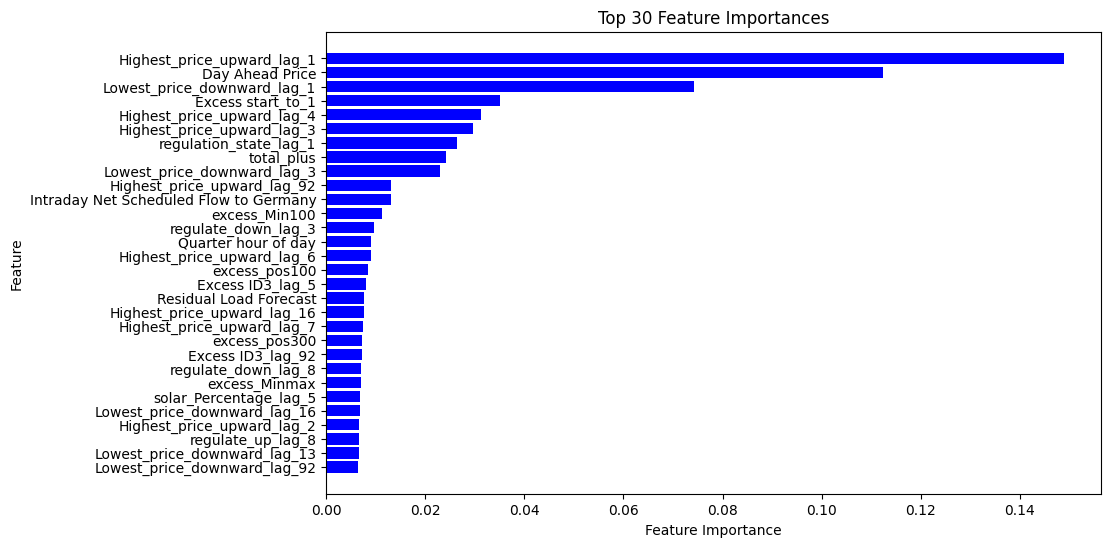

In [ ]:
# Get feature importances
feature_importances = xgb_model.feature_importances_

# Create a DataFrame for better visualization
features = pd.DataFrame({
    'Feature': [col for col in X_XGB_train.columns],
    'Importance': feature_importances
})

# Sort features by importance
features = features.sort_values(by='Importance', ascending=False)

# Plot top N features
N = 30  # Number of top features to plot
top_features = features.head(N)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='b')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title(f'Top {N} Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
best_features = features.head(int(len(features)/3))['Feature']

In [ ]:
pd.set_option('display.max_rows', None)  # Show all rows
features

Feature  Importance
21                          Day Ahead Price       0.127
80               Highest_price_upward_lag_1       0.059
96              Lowest_price_downward_lag_1       0.043
14                        Excess start_to_1       0.028
83               Highest_price_upward_lag_4       0.027
15                                    Month       0.023
88               Highest_price_upward_lag_9       0.021
82               Highest_price_upward_lag_3       0.021
94              Highest_price_upward_lag_15       0.020
136             Highest_price_upward_lag_92       0.019
140            Lowest_price_downward_lag_92       0.017
13                            excess_Min600       0.016
87               Highest_price_upward_lag_8       0.016
93              Highest_price_upward_lag_14       0.015
25                  Quarter hour of day_cos       0.014
16        Intraday Net Scheduled Flow to UK       0.013
95              Highest_price_upward_lag_16       0.012
98              Lowest_price_downward_lag_3       0.012
17                            excess_Minmax       0.011
10                            excess_Min100       0.011
4                             excess_pos100       0.010
23                  Quarter hour of day_sin       0.010
141            Lowest_price_downward_lag_93       0.010
99              Lowest_price_downward_lag_4       0.010
19                            excess_Min300       0.009
97              Lowest_price_downward_lag_2       0.008
28                   solar_Percentage_lag_5       0.008
3                                total_plus       0.008
110            Lowest_price_downward_lag_15       0.007
65                      regulate_down_lag_2       0.007
144                       Excess ID3_lag_92       0.007
64                      regulate_down_lag_1       0.007
146                       Excess ID3_lag_94       0.006
31                      Residual Load_lag_5       0.006
109            Lowest_price_downward_lag_14       0.006
142            Lowest_price_downward_lag_94       0.006
24                          Day of week_cos       0.006
86               Highest_price_upward_lag_7       0.006
20                 Forecast Generation Wind       0.006
105            Lowest_price_downward_lag_10       0.006
2    Intraday Net Scheduled Flow to Denmark       0.005
5                    Residual Load Forecast       0.005
43                   regulation_state_lag_4       0.005
92              Highest_price_upward_lag_13       0.005
115                        Excess ID3_lag_4       0.005
22                          Day of week_sin       0.005
81               Highest_price_upward_lag_2       0.004
117                        Excess ID3_lag_6       0.004
66                      regulate_down_lag_3       0.004
50                        regulate_up_lag_3       0.004
106            Lowest_price_downward_lag_11       0.004
26                    wind_Percentage_lag_5       0.004
123                       Excess ID3_lag_12       0.004
79                     regulate_down_lag_16       0.004
101             Lowest_price_downward_lag_6       0.004
145                       Excess ID3_lag_93       0.004
100             Lowest_price_downward_lag_5       0.004
53                        regulate_up_lag_6       0.004
9                                 Total_min       0.004
132                    regulate_down_lag_92       0.004
90              Highest_price_upward_lag_11       0.004
1                             excess_posmax       0.004
119                        Excess ID3_lag_8       0.004
51                        regulate_up_lag_4       0.004
125                       Excess ID3_lag_14       0.004
12                     Scheduled Generation       0.004
45               Inter Delta Net Flow_lag_6       0.004
11                            excess_pos300       0.004
29                     gas_Percentage_lag_5       0.004
27           wind_offshore_Percentage_lag_5       0.004
128                      regulate_up_lag_92       0.004
126 

In [ ]:
pd.reset_option('display.max_rows')

In [ ]:
# Step 1: Combine column names and feature importances into a list of tuples
features_with_importances = list(zip(X_XGB.columns, feature_importances))

# Step 2: Sort the list of tuples by feature importance in descending order
sorted_features_with_importances = sorted(features_with_importances, key=lambda x: x[1], reverse=True)

# Step 3: Print the sorted pairs
for lag, feature_importance in sorted_features_with_importances:
    print(f"Coefficient for {lag}: {1000 * feature_importance}")

Coefficient for Month_sin: 153.21798622608185
Coefficient for Day Ahead Price: 115.1493564248085
Coefficient for Highest_price_upward_lag_1: 54.155923426151276
Coefficient for Lowest_price_downward_lag_1: 42.991045862436295
Coefficient for Month_cos: 41.53737053275108
Coefficient for Excess start_to_1: 25.2468790858984
Coefficient for Highest_price_upward_lag_4: 23.56892265379429
Coefficient for Highest_price_upward_lag_92: 17.02183298766613
Coefficient for Lowest_price_downward_lag_92: 14.85414057970047
Coefficient for Highest_price_upward_lag_8: 13.12853954732418
Coefficient for excess_Min600: 12.61646207422018
Coefficient for Lowest_price_downward_lag_4: 11.528304778039455
Coefficient for Highest_price_upward_lag_15: 10.39088610559702
Coefficient for Lowest_price_downward_lag_3: 10.127818211913109
Coefficient for Highest_price_upward_lag_3: 9.833363816142082
Coefficient for Quarter hour of day_sin: 9.718436747789383
Coefficient for Highest_price_upward_lag_14: 8.95597692579031
Coeff

## Quantile predictions

### Bayesian Hyperparameter Tuning

In [67]:
# Define Bayesian search objective
def objective(trial) -> float:
    # Define the search space for the hyperparameters
    params = {
        "n_estimators": trial.suggest_int('n_estimators', 500, 1500),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1, step=0.01),
        'subsample': trial.suggest_float('subsample', 0.5, 1, step=0.01),
    }

    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)

    cv_scores = []

    for train_index, val_index in tscv.split(X_XGB_train):
        X_train_fold, X_val_fold = X_XGB_train.iloc[train_index], X_XGB_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # Initialize the model with the current set of hyperparameters
        XGboostmodel = XGBRegressor(**params,
                                    early_stopping_rounds = 100,
                                    objective = 'reg:quantileerror',
                                    quantile_alpha = alphas,
                                    random_state=0,
                                    tree_method='hist',  # Use GPU
                                    device = "cuda",
                                    n_jobs=1)

        # Create validation set for early stopping
        X_train_early, X_val_early, y_train_early, y_val_early = train_test_split_time_series(X_train_fold, y_train_fold, test_size=0.1)

        # Convert to cp arrays
        X_train_early, X_val_early, y_train_early, y_val_early, X_val_fold = cp.array(X_train_early), cp.array(X_val_early), cp.array(y_train_early), cp.array(y_val_early), cp.array(X_val_fold)

        # Fit the model with early stopping
        XGboostmodel.fit(
            X_train_early,
            y_train_early,
            eval_set=[(X_val_early, y_val_early)],
            verbose=False
        )

        # Predict on the validation set
        y_pred = XGboostmodel.predict(X_val_fold)

        pinball_scores = []
        for i, alpha in enumerate(alphas):
          # Calculate the score
          score = mean_pinball_loss(y_val_fold, y_pred[:, i], alpha=alpha)
          pinball_scores.append(score)

        cv_scores.append(np.mean(pinball_scores))

    # Return the average score from the cross-validation
    avg_score = np.mean(cv_scores)
    return avg_score

# Callback function to save the study progress every 10 trials
def save_study_callback(study: optuna.study.Study, trial: optuna.trial.FrozenTrial):
    if trial.number % 10 == 0:
        study_name = '/content/drive/MyDrive/Thesis/Models/Optuna trials/study_progress_XGB_quant_8aug.pkl'
        with open(study_name, 'wb') as f:
            pickle.dump(study, f)
        print(f'Study progress saved at trial {trial.number}')

# Bayesian search for best hyperparameters
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=0))
study.optimize(objective, n_trials=500, callbacks=[save_study_callback], n_jobs=1)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params))

[I 2024-08-08 08:25:55,462] A new study created in memory with name: no-name-b01eed87-2cb8-4c9c-ae0d-8bdee9fbf0c0
[I 2024-08-08 08:26:33,184] Trial 0 finished with value: 51.71120675248651 and parameters: {'n_estimators': 1049, 'max_depth': 8, 'reg_alpha': 3.0138168803582195, 'reg_lambda': 2.724415914984484, 'min_child_weight': 9, 'gamma': 6.458941130666561, 'learning_rate': 0.04429649570464297, 'colsample_bytree': 0.95, 'subsample': 0.99}. Best is trial 0 with value: 51.71120675248651.


Study progress saved at trial 0


[I 2024-08-08 08:30:20,225] Trial 1 finished with value: 51.828115639965745 and parameters: {'n_estimators': 883, 'max_depth': 9, 'reg_alpha': 2.644474598764522, 'reg_lambda': 2.8402228054696614, 'min_child_weight': 19, 'gamma': 0.7103605819788694, 'learning_rate': 0.013449326615130807, 'colsample_bytree': 0.51, 'subsample': 0.9199999999999999}. Best is trial 0 with value: 51.71120675248651.
[I 2024-08-08 08:31:23,706] Trial 2 finished with value: 53.03114663031154 and parameters: {'n_estimators': 1278, 'max_depth': 9, 'reg_alpha': 4.89309171116382, 'reg_lambda': 3.9957928210836178, 'min_child_weight': 10, 'gamma': 7.805291762864554, 'learning_rate': 0.014952219652829973, 'colsample_bytree': 0.8200000000000001, 'subsample': 0.5700000000000001}. Best is trial 0 with value: 51.71120675248651.
[I 2024-08-08 08:31:51,567] Trial 3 finished with value: 53.47697491472837 and parameters: {'n_estimators': 1445, 'max_depth': 6, 'reg_alpha': 2.0733096999526177, 'reg_lambda': 1.322778060523135, 'm

Study progress saved at trial 10


[I 2024-08-08 08:38:18,848] Trial 11 finished with value: 50.026336235557665 and parameters: {'n_estimators': 1494, 'max_depth': 5, 'reg_alpha': 0.1941146468820265, 'reg_lambda': 0.3382195187122168, 'min_child_weight': 1, 'gamma': 0.1169518141585082, 'learning_rate': 0.27937300598542975, 'colsample_bytree': 0.64, 'subsample': 0.67}. Best is trial 10 with value: 49.09009253819728.
[I 2024-08-08 08:38:50,113] Trial 12 finished with value: 53.41985105629085 and parameters: {'n_estimators': 1295, 'max_depth': 5, 'reg_alpha': 0.016857823489928037, 'reg_lambda': 0.022571329941647192, 'min_child_weight': 1, 'gamma': 0.012337157635232895, 'learning_rate': 0.27124847820612724, 'colsample_bytree': 0.66, 'subsample': 0.66}. Best is trial 10 with value: 49.09009253819728.
[I 2024-08-08 08:39:16,927] Trial 13 finished with value: 52.86039096933804 and parameters: {'n_estimators': 1373, 'max_depth': 5, 'reg_alpha': 1.0058192190091608, 'reg_lambda': 0.7386158521600779, 'min_child_weight': 3, 'gamma':

KeyboardInterrupt: 

In [ ]:
[I 2024-07-31 10:15:30,495] Trial 21 finished with value: 48.73420062063154 and parameters: {'n_estimators': 973, 'max_depth': 7, 'reg_alpha': 0.9173214547368091, 'reg_lambda': 2.2762803254469413, 'min_child_weight': 12, 'gamma': 0.7650994404821672, 'learning_rate': 0.011097391745930484, 'colsample_bytree': 0.88, 'subsample': 0.69}. Best is trial 21 with value: 48.73420062063154

In [ ]:
# Define a function that returns the save_study_callback
def create_save_study_callback(filename):
    def save_study_callback(study: optuna.study.Study, trial: optuna.trial.FrozenTrial):
        if trial.number % 10 == 0:
            with open(filename, 'wb') as f:
                pickle.dump(study, f)
            print(f'Study progress saved at trial {trial.number}')
    return save_study_callback

# Path to the saved study file
study_file_path = '/content/drive/MyDrive/Thesis/Models/Optuna trials/study_progress_XGB_quant_31july.pkl'

# Check if a study already exists
if os.path.exists(study_file_path):
    print(f"Loading study from {study_file_path}")
    with open(study_file_path, 'rb') as f:
        study = pickle.load(f)
else:
    print("Creating a new study")
    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=0))

# Create the callback with the filename
save_callback = create_save_study_callback(study_file_path)

# Bayesian search for best hyperparameters
study.optimize(objective, n_trials=500, callbacks=[save_callback], n_jobs=1)

# Print the best trial's results
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params))

Loading study from /content/drive/MyDrive/Thesis/Models/Optuna trials/study_progress_XGB_quant_31july.pkl


### Predict on 'Test' data

In [ ]:
params = {'n_estimators': 973, 'max_depth': 7, 'reg_alpha': 0.9173214547368091, 'reg_lambda': 2.2762803254469413, 'min_child_weight': 12, 'gamma': 1.7650994404821672, 'learning_rate': 0.011097391745930484, 'colsample_bytree': 0.88, 'subsample': 0.69}

In [ ]:
params = {'n_estimators': 1260, 'max_depth': 2, 'reg_alpha': 2.2156539954740793, 'reg_lambda': 0.6454208919079334, 'min_child_weight': 0, 'gamma': 0.45361945675349363, 'learning_rate': 0.05647544371377266, 'colsample_bytree': 0.97, 'subsample': 0.52, 'early_stopping_rounds': 190}

In [ ]:
gc.collect()

# alphas = [0.5]
# alphas = [0.1, 0.5, 0.9]
# alphas = [0.05, 0.15, 0.25, 0.45, 0.5, 0.55, 0.75, 0.85, 0.95]
alphas = [0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95]

# Define parameters
# params = {
#     # 'objective': 'reg:quantileerror',  # For regression task
#     # 'quantile_alpha': alphas,
#     'max_depth': 6,
#     'learning_rate': 0.1,
#     'n_estimators': 100
# }

# Start timing
start_time = time.time()

# Train the model
xgb_model = XGBRegressor(**params,
                         objective= 'reg:quantileerror',
                         quantile_alpha = alphas,
                         random_state=0,
                         n_jobs=num_cores-1)
xgb_model.fit(X_XGB_train, y_train)

# # Create validation set
# X_train_temp, X_val_temp, y_train_temp, y_val_temp = train_test_split_time_series(X_XGB_train, y_train, test_size=0.1)

# # Fit the model with early stopping
# xgb_model.fit(
#     X_train_temp,
#     y_train_temp,
#     eval_set=[(X_val_temp, y_val_temp)],
#     eval_metric='mphe',
#     verbose=True,
# )

# Fit the model with early stopping
# xgb_model.fit(X_XGB_train, y_train)

# Make predictions
y_pred_train_XGB = xgb_model.predict(X_XGB_train)
y_pred_test_XGB = xgb_model.predict(X_XGB_test)

# np.save('Results/XGB_static_predictions_20220901-20230101_test.npy', y_pred_test_XGB)

# End timing
end_time = time.time()

# Print time taken
print(f"Time taken: {end_time - start_time} seconds")

# Print quantile metrics
print('Train:')
print_quantile_metrics(y_train, y_pred_train_XGB, alphas)
print()
print('Test:')
print_quantile_metrics(y_test, y_pred_test_XGB, alphas)

Time taken: 911.4182250499725 seconds
Train:
Pinball 0.05: 13.371003109342789
Pinball 0.15: 25.683152516907402
Pinball 0.25: 33.50103543695596
Pinball 0.35: 39.06801580916163
Pinball 0.45: 42.94605153281209
Pinball 0.5: 44.004469898868734
Pinball 0.55: 44.43121155641202
Pinball 0.65: 42.48686954485198
Pinball 0.75: 38.59307104950062
Pinball 0.85: 32.958271912362015
Pinball 0.95: 18.171999307812676

CRPS: 34.11046833408981

Wrinkler 90.0%: 463.3063793839
Coverage 90.0%: 0.9002315959301569
Wrinkler 70.0%: 282.51483849291486
Coverage 70.0%: 0.7017356683754457
Wrinkler 50.0%: 288.37332227064815
Coverage 50.0%: 0.5158343958989305
Wrinkler 30.0%: 455.85876365997717
Coverage 30.0%: 0.31897785526555467
Wrinkler 10.0%: 1576.9248165823349
Coverage 10.0%: 0.11480912852273023

Test:
Pinball 0.05: 15.691997774710158
Pinball 0.15: 31.15002745831172
Pinball 0.25: 41.49271498317816
Pinball 0.35: 48.85517957043184
Pinball 0.45: 53.60144731846916
Pinball 0.5: 55.160870419157696
Pinball 0.55: 56.02729575

In [ ]:
print('Test:')
print_mean_metrics(y_test, pd.DataFrame(y_pred_test_XGB, index=y_test.index, columns=alphas)[0.5])

Test:
MAE: 110.32174083831539, RMSE: 194.78420258018832, sMAPE: 58.97356717817512


In [ ]:
# Assuming y_train and y_pred_train_LEAR are defined and resid is computed
resid = pd.DataFrame(np.tile(y_train, (11, 1)).T - y_pred_train_XGB, index=y_train.index, columns=quantiles)

# Define the desired quantiles
# quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
quantiles = [0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95]
n_intervals = 96

# Initialize a dictionary to store the results
bootstrap_data = {q: np.zeros(n_intervals) for q in quantiles}
for quantile in quantiles:
  bootstrap_data[quantile] = bootstrap_residual_quantile(resid[quantile], quantile)

# Add the quantiles to training predictions
y_pred_train_XGB_quantiles = recalibrate_quantile_predictions(pd.DataFrame(y_pred_train_XGB, index=y_train.index, columns=quantiles), bootstrap_data, quantiles)

# Add the quantiles to test predictions
y_pred_test_XGB_quantiles = recalibrate_quantile_predictions(pd.DataFrame(y_pred_test_XGB, index=y_test.index, columns=quantiles) , bootstrap_data, quantiles)

In [ ]:
# Print quantile metrics
print('Train:')
print_quantile_metrics(y_train, y_pred_train_XGB_quantiles, alphas)
print()
print('Test:')
print_quantile_metrics(y_test, y_pred_test_XGB_quantiles, alphas)

Train:
Pinball 0.05: 13.12703172346487
Pinball 0.15: 25.59296547207029
Pinball 0.25: 33.46482574957308
Pinball 0.35: 39.04536498690532
Pinball 0.45: 42.929994436800875
Pinball 0.5: 43.99025364605808
Pinball 0.55: 44.41304955237494
Pinball 0.65: 42.45960974958059
Pinball 0.75: 38.55934120722896
Pinball 0.85: 32.82279185739596
Pinball 0.95: 17.772153741872643

CRPS: 34.01612564757506

Wrinkler 90.0%: 462.8703340075819
Coverage 90.0%: 0.9023654011293555
Wrinkler 70.0%: 284.0957517154076
Coverage 70.0%: 0.7031148351505374
Wrinkler 50.0%: 288.08325178535625
Coverage 50.0%: 0.5039683572302167
Wrinkler 30.0%: 456.61378697262796
Coverage 30.0%: 0.30542038564625673
Wrinkler 10.0%: 1577.5035557193169
Coverage 10.0%: 0.11134820057768872

Test:
Pinball 0.05: 15.518220379266939
Pinball 0.15: 31.134911975948167
Pinball 0.25: 41.49827767156246
Pinball 0.35: 48.8463941500376
Pinball 0.45: 53.57855724261662
Pinball 0.5: 55.14017806554854
Pinball 0.55: 55.99800265449337
Pinball 0.65: 55.91041108747903
P

### Feature importances

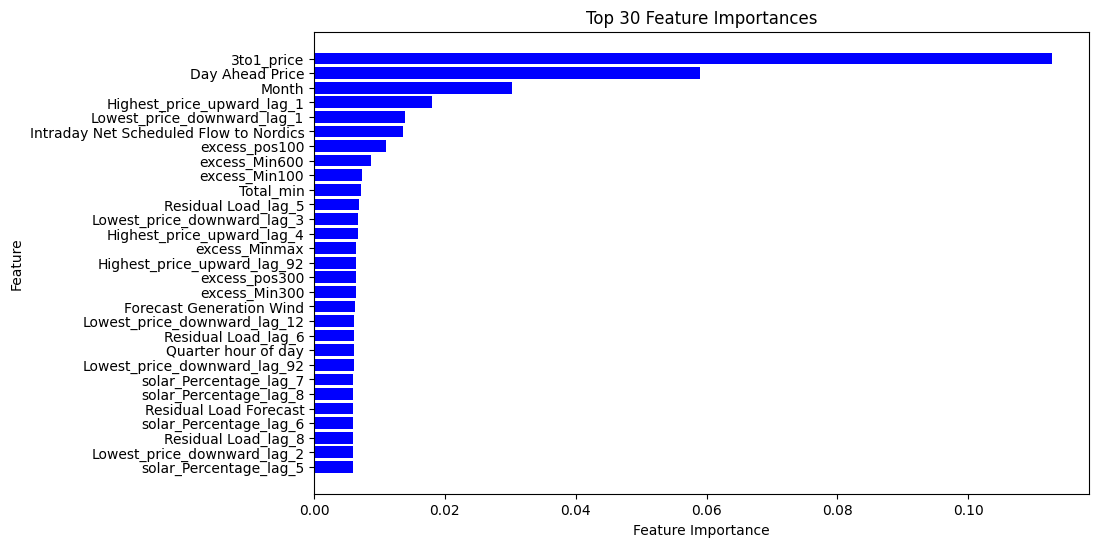

In [318]:
# Get feature importances
feature_importances = xgb_model.feature_importances_

# Create a DataFrame for better visualization
features = pd.DataFrame({
    'Feature': [col for col in X_XGB_train.columns],
    'Importance': feature_importances
})

# Sort features by importance
features = features.sort_values(by='Importance', ascending=False)

# Plot top N features
N = 30  # Number of top features to plot
top_features = features.head(N)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='b')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title(f'Top {N} Feature Importances')
plt.gca().invert_yaxis()
plt.show()

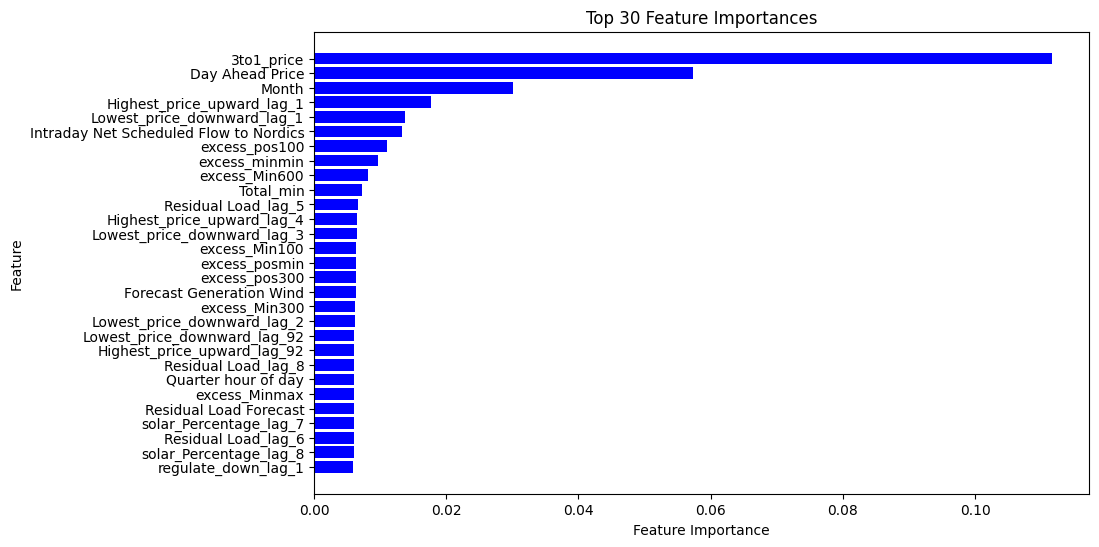

In [510]:
# Get feature importances
feature_importances = xgb_model.feature_importances_

# Create a DataFrame for better visualization
features = pd.DataFrame({
    'Feature': [col for col in X_XGB_train.columns],
    'Importance': feature_importances
})

# Sort features by importance
features = features.sort_values(by='Importance', ascending=False)

# Plot top N features
N = 30  # Number of top features to plot
top_features = features.head(N)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='b')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title(f'Top {N} Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [183]:
pd.set_option('display.max_rows', None)  # Show all rows
features

Feature  Importance
12                          Day Ahead Price       0.109
8                                     Month       0.038
78               Highest_price_upward_lag_1       0.032
94              Lowest_price_downward_lag_1       0.022
18                            excess_pos100       0.014
7    Intraday Net Scheduled Flow to Nordics       0.013
13                            excess_Minmax       0.012
22                              Excess 3to1       0.012
3                             excess_Min100       0.010
15                            excess_Min600       0.009
134             Highest_price_upward_lag_92       0.009
95              Lowest_price_downward_lag_2       0.009
96              Lowest_price_downward_lag_3       0.009
81               Highest_price_upward_lag_4       0.008
138            Lowest_price_downward_lag_92       0.008
38                   regulation_state_lag_1       0.008
23                            excess_Min300       0.007
80               Highest_price_upward_lag_3       0.007
10                                Total_min       0.007
6                  Forecast Generation Wind       0.007
26                   solar_Percentage_lag_5       0.007
5                       Quarter hour of day       0.007
1                             excess_pos300       0.007
105            Lowest_price_downward_lag_12       0.006
97              Lowest_price_downward_lag_4       0.006
14                   Residual Load Forecast       0.006
29                      Residual Load_lag_5       0.006
62                      regulate_down_lag_1       0.006
84               Highest_price_upward_lag_7       0.006
0         Intraday Net Scheduled Flow to UK       0.006
16                               total_plus       0.006
25           wind_offshore_Percentage_lag_5       0.006
79               Highest_price_upward_lag_2       0.006
142                       Excess ID3_lag_92       0.006
113                        Excess ID3_lag_4       0.006
24                    wind_Percentage_lag_5       0.006
85               Highest_price_upward_lag_8       0.006
11                     Scheduled Generation       0.006
86               Highest_price_upward_lag_9       0.006
17   Intraday Net Scheduled Flow to Germany       0.006
46                        regulate_up_lag_1       0.006
100             Lowest_price_downward_lag_7       0.006
27                     gas_Percentage_lag_5       0.006
64                      regulate_down_lag_3       0.006
19                            excess_posmax       0.006
107            Lowest_price_downward_lag_14       0.006
144                       Excess ID3_lag_94       0.005
101             Lowest_price_downward_lag_8       0.005
92              Highest_price_upward_lag_15       0.005
93              Highest_price_upward_lag_16       0.005
34                           Net IGCC_lag_1       0.005
103            Lowest_price_downward_lag_10       0.005
139            Lowest_price_downward_lag_93       0.005
4                           Day Ahead Delta       0.005
2    Intraday Net Scheduled Flow to Denmark       0.005
102             Lowest_price_downward_lag_9       0.005
91              Highest_price_upward_lag_14       0.005
83               Highest_price_upward_lag_6       0.005
104            Lowest_price_downward_lag_11       0.005
106            Lowest_price_downward_lag_13       0.005
90              Highest_price_upward_lag_13       0.005
20                            excess_pos600       0.005
82               Highest_price_upward_lag_5       0.005
99              Lowest_price_downward_lag_6       0.005
21   Intraday Net Scheduled Flow to Belgium       0.005
98              Lowest_price_downward_lag_5       0.005
30                 Emergency capacity_lag_1       0.005
108            Lowest_price_downward_lag_15       0.005
87              Highest_price_upward_lag_10       0.005
28                Forecast Error Wind_lag_5       0.005
63                      regulate_down_lag_2       0.005
9   

In [378]:
pd.set_option('display.max_rows', None)  # Show all rows
features

Feature  Importance
4                        3to1_price       0.116
11                  Day Ahead Price       0.059
7                             Month       0.029
66       Highest_price_upward_lag_1       0.018
50      Lowest_price_downward_lag_1       0.014
16                    excess_pos100       0.012
14                    excess_Min600       0.010
9                         Total_min       0.008
2                     excess_Min100       0.007
34              Residual Load_lag_5       0.007
22              Residual Load_lag_5       0.007
52      Lowest_price_downward_lag_3       0.007
1                     excess_pos300       0.007
69       Highest_price_upward_lag_4       0.007
51      Lowest_price_downward_lag_2       0.007
19                    excess_Min300       0.006
134     Highest_price_upward_lag_92       0.006
6          Forecast Generation Wind       0.006
28           solar_Percentage_lag_7       0.006
130    Lowest_price_downward_lag_92       0.006
37              Residual Load_lag_8       0.006
61     Lowest_price_downward_lag_12       0.006
13           Residual Load Forecast       0.006
5               Quarter hour of day       0.006
27           solar_Percentage_lag_6       0.006
29           solar_Percentage_lag_8       0.006
35              Residual Load_lag_6       0.006
12                    excess_Minmax       0.006
20           solar_Percentage_lag_5       0.006
82              regulate_down_lag_1       0.006
26           solar_Percentage_lag_5       0.006
39            wind_Percentage_lag_6       0.006
10             Scheduled Generation       0.006
68       Highest_price_upward_lag_3       0.006
53      Lowest_price_downward_lag_4       0.006
38            wind_Percentage_lag_5       0.006
15                       total_plus       0.006
42             gas_Percentage_lag_5       0.006
36              Residual Load_lag_7       0.006
41            wind_Percentage_lag_8       0.006
23            wind_Percentage_lag_5       0.006
44             gas_Percentage_lag_7       0.006
45             gas_Percentage_lag_8       0.006
21   wind_offshore_Percentage_lag_5       0.006
114               regulate_up_lag_1       0.005
43             gas_Percentage_lag_6       0.005
40            wind_Percentage_lag_7       0.005
24             gas_Percentage_lag_5       0.005
33   wind_offshore_Percentage_lag_8       0.005
73       Highest_price_upward_lag_8       0.005
67       Highest_price_upward_lag_2       0.005
63     Lowest_price_downward_lag_14       0.005
32   wind_offshore_Percentage_lag_7       0.005
57      Lowest_price_downward_lag_8       0.005
31   wind_offshore_Percentage_lag_6       0.005
17                    excess_posmax       0.005
101                Excess ID3_lag_4       0.005
84              regulate_down_lag_3       0.005
30   wind_offshore_Percentage_lag_5       0.005
81      Highest_price_upward_lag_16       0.005
74       Highest_price_upward_lag_9       0.005
56      Lowest_price_downward_lag_7       0.005
71       Highest_price_upward_lag_6       0.005
142               Excess ID3_lag_92       0.005
72       Highest_price_upward_lag_7       0.005
58      Lowest_price_downward_lag_9       0.005
49        Forecast Error Wind_lag_8       0.005
3                   Day Ahead Delta       0.005
64     Lowest_price_downward_lag_15       0.005
0              Total Scheduled Flow       0.005
60     Lowest_price_downward_lag_11       0.005
80      Highest_price_upward_lag_15       0.005
144               Excess ID3_lag_94       0.005
62     Lowest_price_downward_lag_13       0.005
46        Forecast Error Wind_lag_5       0.005
59     Lowest_price_downward_lag_10       0.005
48        Forecast Error Wind_lag_7       0.005
79      Highest_price_upward_lag_14       0.005
47        Forecast Error Wind_lag_6       0.005
75      Highest_price_upward_lag_10       0.005
54      Lowest_price_downward_lag_5       0.005
65     Lowest_price_downward_lag_16       0.005
25        Forecast Error Wind_lag_5       0.

In [184]:
pd.reset_option('display.max_rows')

### GPU or basic parameters

In [ ]:
params = {'n_estimators': 360, 'max_depth': 3, 'reg_alpha': 2.2156539954740793, 'reg_lambda': 0.6454208919079334, 'min_child_weight': 0, 'gamma': 0.45361945675349363, 'learning_rate': 0.05647544371377266, 'colsample_bytree': 0.97, 'subsample': 0.52}

In [632]:
params = {'n_estimators': 973, 'max_depth': 7, 'reg_alpha': 0.9173214547368091, 'reg_lambda': 2.2762803254469413, 'min_child_weight': 12, 'gamma': 1.7650994404821672, 'learning_rate': 0.011097391745930484, 'colsample_bytree': 0.88, 'subsample': 0.69}

In [684]:
gc.collect()

alphas = [0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95]

# Start timing
start_time = time.time()

add_params = {
    'objective': 'reg:quantileerror',
    'tree_method': 'hist',  # Use GPU for training
    'device': 'cuda',  # Use GPU for prediction
    'quantile_alpha': alphas,
    'random_state': 0,
    'n_jobs' : 1
}

params.update(add_params)

# Train the model
xgb_model = XGBRegressor(**params)

# Convert to cp arrays
X_XGB_train_GPU, y_train_GPU, X_XGB_test_GPU = cp.array(X_XGB_train), cp.array(y_train), cp.array(X_XGB_test)

xgb_model.fit(X_XGB_train_GPU, y_train_GPU)

# Make predictions
y_pred_train_XGB = xgb_model.predict(X_XGB_train_GPU)
y_pred_test_XGB = xgb_model.predict(X_XGB_test_GPU)

# End timing
end_time = time.time()

# Print time taken
print(f"Time taken: {end_time - start_time} seconds")

# Print quantile metrics
print('Train:')
print_quantile_metrics(y_train, y_pred_train_XGB, alphas)
print()
print('Test:')
print_quantile_metrics(y_test, y_pred_test_XGB, alphas)

Time taken: 100.71497750282288 seconds
Train:
Pinball 0.05: 13.272174876666186
Pinball 0.15: 25.314831284385527
Pinball 0.25: 32.613639323372034
Pinball 0.35: 38.40422963136368
Pinball 0.45: 42.33754206027843
Pinball 0.5: 43.58174216831059
Pinball 0.55: 43.8201964289752
Pinball 0.65: 41.64772964497381
Pinball 0.75: 37.035581421227604
Pinball 0.85: 32.16478797511484
Pinball 0.95: 18.02965800800596

CRPS: 33.47473752933399

Winkler 90.0%: 459.1635256935799
Coverage 90.0%: 0.9001795519009081
Winkler 70.0%: 276.97224354706333
Coverage 70.0%: 0.7027765489604205
Winkler 50.0%: 278.5929345101257
Coverage 50.0%: 0.5289494912696141
Winkler 30.0%: 446.9197862328104
Coverage 30.0%: 0.330817871919644
Winkler 10.0%: 1553.6879403909238
Coverage 10.0%: 0.11660464753181192

Test:
Pinball 0.05: 15.652097544309873
Pinball 0.15: 30.811495893714795
Pinball 0.25: 41.08818811360557
Pinball 0.35: 48.34599185793829
Pinball 0.45: 53.16128115152926
Pinball 0.5: 54.753546787030814
Pinball 0.55: 55.7836053689758


In [ ]:
gc.collect()

alphas = [0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95]

# Start timing
start_time = time.time()

add_params = {
    'objective': 'reg:quantileerror',
    'tree_method': 'hist',  # Use GPU for training
    'device': 'cuda',  # Use GPU for prediction
    'quantile_alpha': alphas,
    'random_state': 0,
    'n_jobs' : 1
}

params.update(add_params)

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

cv_scores = []

for train_index, val_index in tscv.split(X_XGB_train):
    X_train_fold, X_val_fold = X_XGB_train.iloc[train_index], X_XGB_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Initialize the model with the current set of hyperparameters
    XGboostmodel = XGBRegressor(**params)

    # Convert to cp arrays
    X_train_fold, X_val_fold, y_train_fold, y_val_fold = cp.array(X_train_fold), cp.array(X_val_fold), cp.array(y_train_fold), cp.array(y_val_fold)

    # Fit the model with early stopping
    XGboostmodel.fit(
        X_train_fold,
        y_train_fold,

    )

    # Predict on the validation set
    y_pred = XGboostmodel.predict(X_val_fold)

    pinball_scores = []
    for i, alpha in enumerate(alphas):
      # Calculate the score
      score = mean_pinball_loss(y_val_fold, y_pred[:, i], alpha=alpha)
      pinball_scores.append(score)

    cv_scores.append(np.mean(pinball_scores))

# Return the average score from the cross-validation
avg_score = np.mean(cv_scores)
print(avg_score)

# End timing
end_time = time.time()

# Print time taken
print(f"Time taken: {end_time - start_time} seconds")

In [682]:
print('Test:')
print_mean_metrics(y_test, pd.DataFrame(y_pred_test_XGB, index=y_test.index, columns=alphas)[0.5])

Test:
MAE: 109.50709357406163, RMSE: 193.7660008242283, sMAPE: 58.56067986900645


minmin posmin

In [509]:
print('Test:')
print_mean_metrics(y_test, pd.DataFrame(y_pred_test_XGB, index=y_test.index, columns=alphas)[0.5])

Test:
MAE: 109.09441874459623, RMSE: 193.28472512282107, sMAPE: 58.45422177466457


In [376]:
print('Test:')
print_mean_metrics(y_test, pd.DataFrame(y_pred_test_XGB, index=y_test.index, columns=alphas)[0.5])

Test:
MAE: 109.56098759888845, RMSE: 193.34767531033893, sMAPE: 58.74529120876753


Current baseline

In [317]:
print('Test:')
print_mean_metrics(y_test, pd.DataFrame(y_pred_test_XGB, index=y_test.index, columns=alphas)[0.5])

Test:
MAE: 109.51492609202992, RMSE: 193.88373324802262, sMAPE: 58.66513647935723


Previous baseline

In [84]:
print('Test:')
print_mean_metrics(y_test, pd.DataFrame(y_pred_test_XGB, index=y_test.index, columns=alphas)[0.5])

Test:
MAE: 110.48534716164174, RMSE: 195.0472733769885, sMAPE: 58.98927421309789


### Plotting

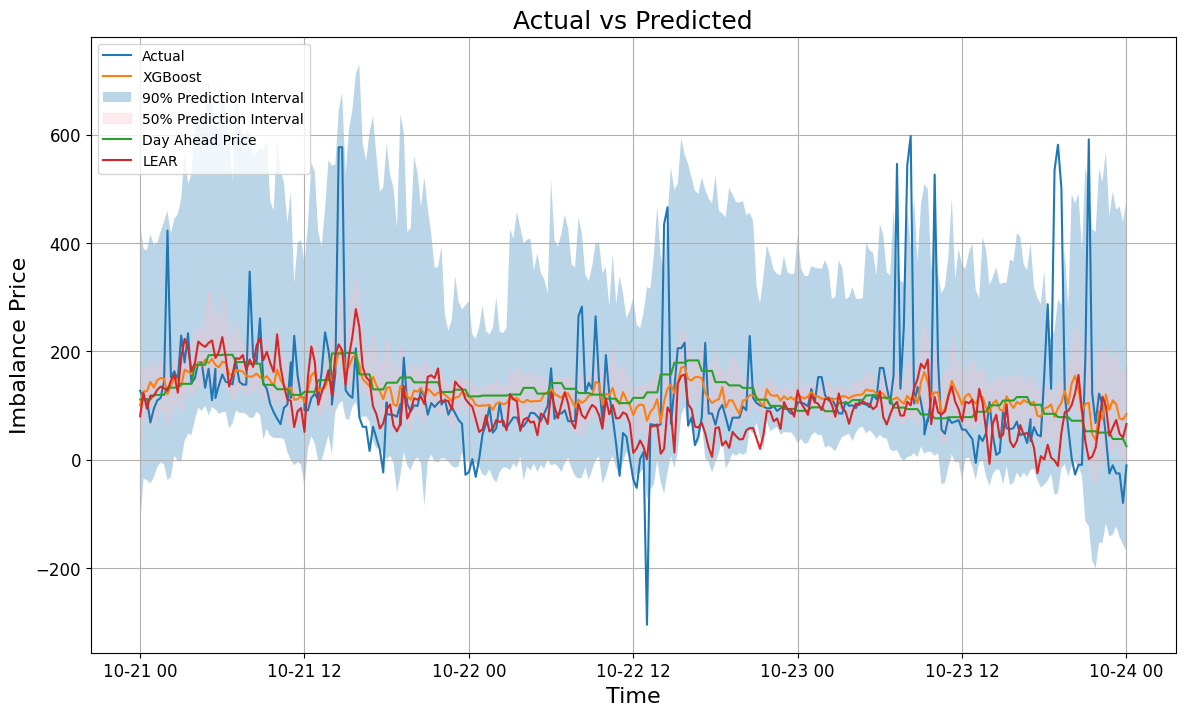

In [ ]:
# Create a Dataframe holding the quantile predictions
y_pred_test_XGB_df = pd.DataFrame(y_pred_test_XGB, index=y_test.index, columns=alphas)

base_day = 50
plus_days = 3

# Define the interval to plot
interval_start = str(pd.to_datetime(test_start) + pd.Timedelta(days=base_day))
interval_end = str(pd.to_datetime(test_start) + pd.Timedelta(days=base_day + plus_days))

# Define the actual values
y_test_plot = y_test[interval_start:interval_end]

# Define the predicted values
XGB_test_plot = y_pred_test_XGB_df[interval_start:interval_end]
XGB_label = 'XGBoost'

# Define the benchmarks to plot
day_ahead_plot = df['Day Ahead Price'].shift(-4)[interval_start:interval_end]
day_ahead_label = 'Day Ahead Price'

# Define the predicted values
LEAR_test_plot = rolling_pred_quantiles_LEAR_df[interval_start:interval_end][0.5]
LEAR_label = 'LEAR'

# benchmarks = [day_ahead_plot]
# benchmark_labels = [day_ahead_label]
benchmarks = [day_ahead_plot, LEAR_test_plot]
benchmark_labels = [day_ahead_label, LEAR_label]

# Plot the prediction intervals
plot_prediction_intervals(y_test_plot, XGB_test_plot, XGB_label, benchmarks, benchmark_labels)

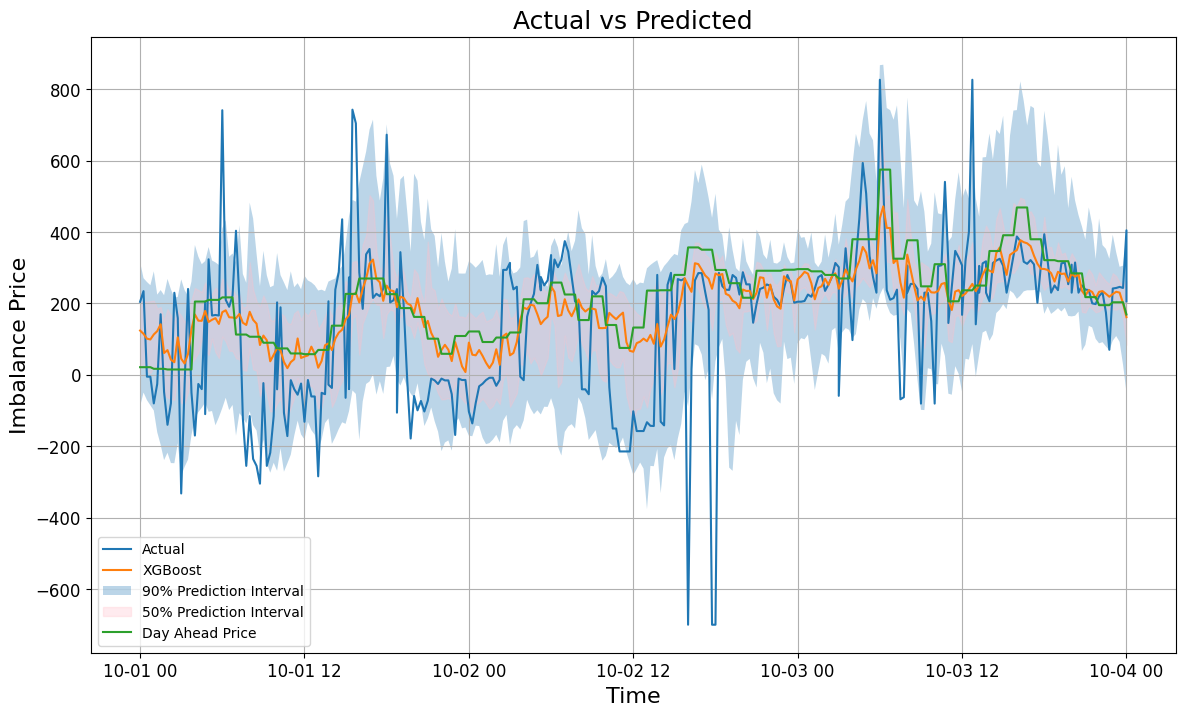

In [ ]:
# Create a Dataframe holding the quantile predictions
y_pred_test_XGB_df = pd.DataFrame(y_pred_test_XGB, index=y_test.index, columns=alphas)

base_day = 30
plus_days = 3

# Define the interval to plot
interval_start = str(pd.to_datetime(test_start) + pd.Timedelta(days=base_day))
interval_end = str(pd.to_datetime(test_start) + pd.Timedelta(days=base_day + plus_days))

# Define the actual values
y_test_plot = y_test[interval_start:interval_end]

# Define the predicted values
XGB_test_plot = y_pred_test_XGB_df[interval_start:interval_end]
XGB_label = 'XGBoost'

# Define the benchmarks to plot
day_ahead_plot = df['Day Ahead Price'].shift(-4)[interval_start:interval_end]
day_ahead_label = 'Day Ahead Price'

# Define the predicted values
LEAR_test_plot = rolling_pred_quantiles_LEAR_df[interval_start:interval_end][0.5]
LEAR_label = 'LEAR'

benchmarks = [day_ahead_plot]
benchmark_labels = [day_ahead_label]
# benchmarks = [day_ahead_plot, LEAR_test_plot]
# benchmark_labels = [day_ahead_label, LEAR_label]

# Plot the prediction intervals
plot_prediction_intervals(y_test_plot, XGB_test_plot, XGB_label, benchmarks, benchmark_labels)

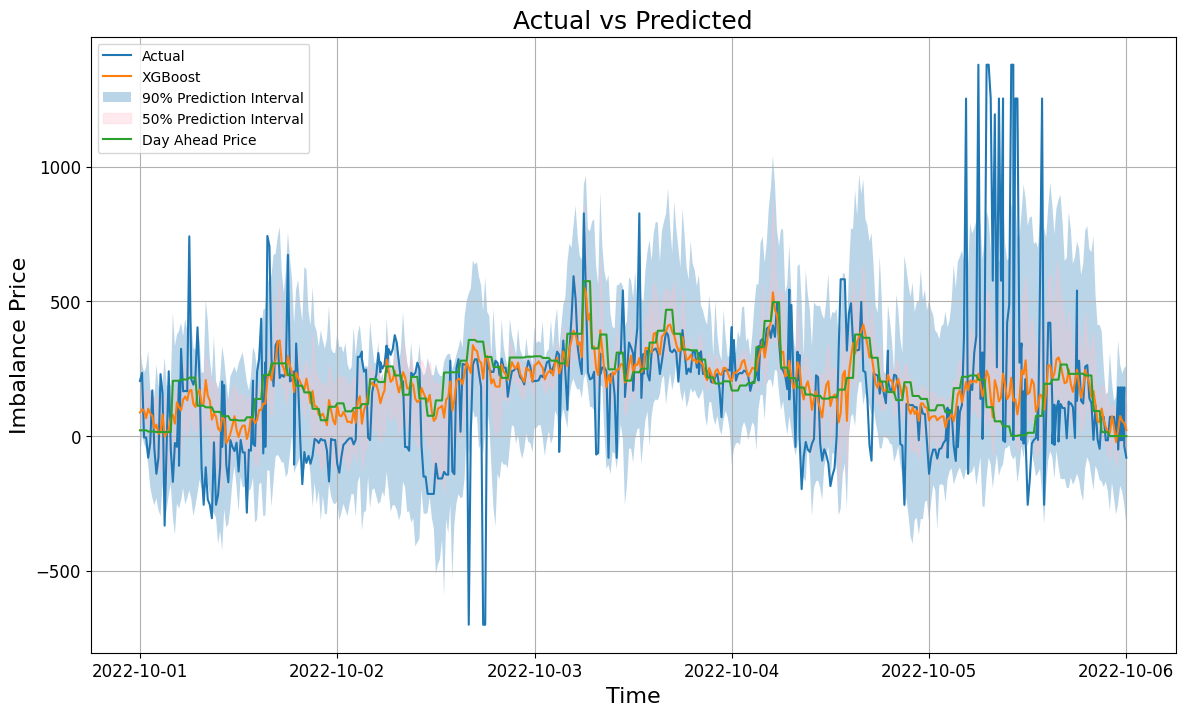

In [ ]:
# Create a Dataframe holding the quantile predictions
y_pred_test_XGB_df = pd.DataFrame(y_pred_test_XGB, index=y_test.index, columns=alphas)

base_day = 30

# Define the interval to plot
interval_start = str(pd.to_datetime(test_start) + pd.Timedelta(days=base_day))
interval_end = str(pd.to_datetime(test_start) + pd.Timedelta(days=base_day + 5))

# Define the actual values
y_test_plot = y_test[interval_start:interval_end]

# Define the predicted values
XGB_test_plot = y_pred_test_XGB_df[interval_start:interval_end]
XGB_label = 'XGBoost'

# Define the benchmarks to plot
day_ahead_plot = df['Day Ahead Price'].shift(-4)[interval_start:interval_end]
day_ahead_label = 'Day Ahead Price'

# # Define the predicted values
# LEAR_test_plot = rolling_pred_quantiles_LEAR_df[interval_start:interval_end][0.5]
# LEAR_label = 'LEAR'

benchmarks = [day_ahead_plot]
benchmark_labels = [day_ahead_label]
# benchmarks = [day_ahead_plot, LEAR_test_plot]
# benchmark_labels = [day_ahead_label, LEAR_label]

# Plot the prediction intervals
plot_prediction_intervals(y_test_plot, XGB_test_plot, XGB_label, benchmarks, benchmark_labels)

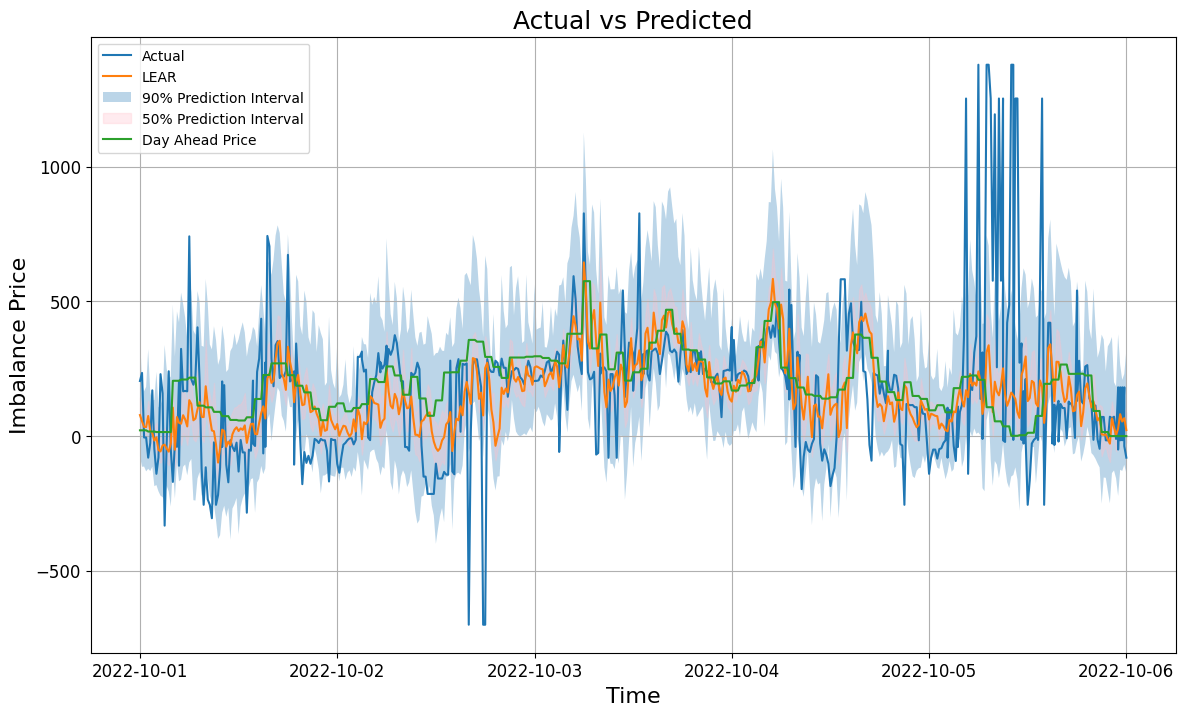

In [ ]:
# Create a Dataframe holding the quantile predictions
rolling_pred_quantiles_LEAR_df = pd.DataFrame(rolling_pred_quantiles_LEAR, index=y_test.index, columns=alphas)

base_day = 30

# Define the interval to plot
interval_start = str(pd.to_datetime(test_start) + pd.Timedelta(days=base_day))
interval_end = str(pd.to_datetime(test_start) + pd.Timedelta(days=base_day + 5))

# Define the actual values
y_test_plot = y_test[interval_start:interval_end]

# Define the predicted values
LEAR_test_plot = rolling_pred_quantiles_LEAR_df[interval_start:interval_end]
LEAR_label = 'LEAR'

# Define the benchmarks to plot
day_ahead_plot = [df['Day Ahead Price'].shift(-4)[interval_start:interval_end]]
day_ahead_label = ['Day Ahead Price']

# Plot the prediction intervals
plot_prediction_intervals(y_test_plot, LEAR_test_plot, LEAR_label, day_ahead_plot, day_ahead_label)

### Arctanloss

In [ ]:
from functools import partial

# NOTE: This function is copied from https://github.com/LaurensSluyterman/XGBoost_quantile_regression.git and is slightly modified to improve performance
def arctan_loss(y_true, y_pred, taus, s=0.1):
    """Compute the arctan pinball loss.

    Note that XGBoost outputs the predictions in a slightly peculiar manner.
    Suppose we have 100 data points and we predict 10 quantiles. The predictions
    will be an array of size (1000 x 1). We first resize this to a (100x10) array
    where each row corresponds to the 10 predicted quantile for a single data
    point. We then use a for-loop (over the 10 columns) to calculate the gradients
    and second derivatives. Legibility was chosen over efficiency. This part
    can be made more efficient.

    Parameters:
        y_true: An array containing the true observations.
        y_pred: An array containing the predicted quantiles
        taus: A list containing the true desired coverage of the quantiles
        s: A smoothing parameter

    Returns:
        grad: An array containing the (negative) gradients with respect to y_pred.
        hess: An array containing the second derivative with respect to y_pred.
    """
    size = len(y_true)
    n_dim = len(taus)  # The number of columns
    n_rows = size // n_dim
    taus = np.array(taus)

    # Resize the predictions and targets.
    # Each column corresponds to a quantile, each row to a data point.
    y_pred = np.reshape(y_pred, (n_rows, n_dim))
    y_true = np.reshape(y_true, (n_rows, n_dim))

    # Calculate the differences (This is vectorised to increase speed)
    u = y_true - y_pred
    z = u / s
    x = 1 + z**2
    grad = taus - 0.5 + 1 / np.pi * np.arctan(z) + z / (np.pi) * x ** -1
    hess = 2 / (np.pi * s) * x ** (-2)

    # Reshape back to the original shape.
    grad = grad.reshape(size)
    hess = hess.reshape(size)
    return -grad / n_dim, hess / n_dim

In [ ]:
# Define parameters
params = {
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100
}

# Start timing
start_time = time.time()

targets = np.zeros((len(y_train), len(alphas)))
for j in range(len(alphas)):
  targets[:, j] = y_train.values

# Train the model
xgb_model = XGBRegressor(**params,
                         objective=partial(arctan_loss, taus=alphas, s=0.05),
                         base_score=0,
                         multi_strategy="multi_output_tree",
                         min_child_weight=0,
                         max_delta_step=.5,
                         random_state = 0,
                         n_jobs = num_cores-1)

# Create TransformedTargetRegressor with LinearRegression as the base estimator
xgb_model = TransformedTargetRegressor(regressor=xgb_model, transformer=MinMaxScaler())

# Fit the model
xgb_model.fit(X_XGB_train, targets)

# Make predictions
y_pred_train_XGB = xgb_model.predict(X_XGB_train)
y_pred_test_XGB = xgb_model.predict(X_XGB_test)

# End timing
end_time = time.time()

# Print time taken
print(f"Time taken: {end_time - start_time} seconds")

# Print quantile metrics
print('Train:')
print_quantile_metrics(y_train, y_pred_train_XGB, alphas)
print()
print('Test:')
print_quantile_metrics(y_test, y_pred_test_XGB, alphas)

Time taken: 114.37596106529236 seconds
Train:
Pinball 0.05: 15.950718754057009
Pinball 0.15: 29.831184174954416
Pinball 0.25: 36.91677716137174
Pinball 0.35: 40.46281882432279
Pinball 0.45: 42.382098589732514
Pinball 0.5: 43.01859049687352
Pinball 0.55: 43.61426901889573
Pinball 0.65: 43.906612918321365
Pinball 0.75: 41.53854606593528
Pinball 0.85: 34.297944429091885
Pinball 0.95: 17.564772160505363

CRPS: 35.40766659946015

Wrinkler 90.0%: 605.2918701171875
Coverage 90.0%: 0.9574559686888454
Wrinkler 70.0%: 364.9609375
Coverage 70.0%: 0.8513111545988258
Wrinkler 50.0%: 313.8212890625
Coverage 50.0%: 0.7136594911937377
Wrinkler 30.0%: 421.0680236816406
Coverage 30.0%: 0.5031702544031311
Wrinkler 10.0%: 1448.01383326384
Coverage 10.0%: 0.18864970645792564

Test:
Pinball 0.05: 18.826551323995023
Pinball 0.15: 36.21708831705224
Pinball 0.25: 48.7770386961329
Pinball 0.35: 57.69465473719374
Pinball 0.45: 62.763191083831366
Pinball 0.5: 64.08010117843205
Pinball 0.55: 64.72882158887276
Pinb

In [ ]:
# Define parameters
params = {
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100
}

# Start timing
start_time = time.time()

targets = np.zeros((len(y_train), len(alphas)))
for j in range(len(alphas)):
  targets[:, j] = y_train.values

# Train the model
xgb_model = XGBRegressor(**params,
                         objective=partial(arctan_loss, taus=alphas, s=0.05),
                         base_score=0,
                         multi_strategy="multi_output_tree",
                         tree_method='hist',  # Use GPU
                         device = "cuda",
                         min_child_weight=0,
                         max_delta_step=.5,
                         random_state = 0,
                         n_jobs = num_cores-1)

# Create TransformedTargetRegressor with LinearRegression as the base estimator
xgb_model = TransformedTargetRegressor(regressor=xgb_model, transformer=MinMaxScaler())

# Fit the model
xgb_model.fit(X_XGB_train, targets)

# Make predictions
y_pred_train_XGB = xgb_model.predict(X_XGB_train)
y_pred_test_XGB = xgb_model.predict(X_XGB_test)

# End timing
end_time = time.time()

# Print time taken
print(f"Time taken: {end_time - start_time} seconds")

# Print quantile metrics
print('Train:')
print_quantile_metrics(y_train, y_pred_train_XGB, alphas)
print()
print('Test:')
print_quantile_metrics(y_test, y_pred_test_XGB, alphas)

XGBoostError: [15:42:30] /workspace/src/gbm/gbtree.cc:205: Check failed: ctx_->IsCPU(): GPU is not yet supported for vector leaf.
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x45ac0a) [0x785b6746fc0a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4621f6) [0x785b674771f6]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c4fcd) [0x785b674d9fcd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterBoostOneIter+0x3fa) [0x785b6717745a]
  [bt] (4) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x785bec232e2e]
  [bt] (5) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x785bec22f493]
  [bt] (6) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x785bec2583e9]
  [bt] (7) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x9a00) [0x785bec257a00]
  [bt] (8) /usr/bin/python3(_PyObject_MakeTpCall+0x25b) [0x590acde863cb]



In [ ]:
# Define parameters
params = {
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100
}

# Start timing
start_time = time.time()

targets = np.zeros((len(y_train), len(alphas)))
for j in range(len(alphas)):
  targets[:, j] = y_train.values

# Train the model
xgb_model = XGBRegressor(**params,
                         objective=partial(arctan_loss, taus=alphas, s=0.05),
                         base_score=0,
                         multi_strategy="multi_output_tree",
                         min_child_weight=0,
                         max_delta_step=.5,
                         random_state = 0,
                         n_jobs = num_cores)

# Create TransformedTargetRegressor with LinearRegression as the base estimator
xgb_model = TransformedTargetRegressor(regressor=xgb_model, transformer=MinMaxScaler())

# Create validation set
X_train_temp, X_val_temp, y_train_temp, y_val_temp = train_test_split_time_series(X_XGB_train, y_train, test_size=0.2)

# Fit the model with early stopping
xgb_model.fit(
    X_train_temp,
    y_train_temp,
    eval_set=[(X_val_temp, y_val_temp)],
    verbose=False,
)

xgb_model.fit(X_XGB_train, targets)

# Make predictions
y_pred_train_XGB = xgb_model.predict(X_XGB_train)
y_pred_test_XGB = xgb_model.predict(X_XGB_test)
# End timing
end_time = time.time()

# Print time taken
print(f"Time taken: {end_time - start_time} seconds")

# Print quantile metrics
print('Train:')
print_quantile_metrics(y_train, y_pred_train_XGB, alphas)
print()
print('Test:')
print_quantile_metrics(y_test, y_pred_test_XGB, alphas)

Time taken: 250.34160494804382 seconds
Train:
Pinball 0.05: 16.50604526610005
Pinball 0.15: 31.088125329330495
Pinball 0.25: 38.60839154304224
Pinball 0.35: 42.40038151518859
Pinball 0.45: 44.490880366294434
Pinball 0.5: 45.23721094199013
Pinball 0.55: 45.890818152862856
Pinball 0.65: 46.24511249422823
Pinball 0.75: 43.82495181912278
Pinball 0.85: 36.30975559012516
Pinball 0.95: 18.53846447454267

CRPS: 37.19455795389342

Wrinkler 90.0%: 622.42529296875
Coverage 90.0%: 0.9536986301369863
Wrinkler 70.0%: 378.35009765625
Coverage 70.0%: 0.8409393346379648
Wrinkler 50.0%: 329.73333740234375
Coverage 50.0%: 0.7065753424657534
Wrinkler 30.0%: 447.5378130966167
Coverage 30.0%: 0.49968688845401177
Wrinkler 10.0%: 1531.404093826281
Coverage 10.0%: 0.19240704500978473

Test:
Pinball 0.05: 19.21055459352339
Pinball 0.15: 37.28965375150266
Pinball 0.25: 50.043126785134085
Pinball 0.35: 58.97399924040409
Pinball 0.45: 65.06553790296304
Pinball 0.5: 66.86948941385798
Pinball 0.55: 67.77743801855914

In [ ]:
# Define parameters
params = {
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100
}

# Start timing
start_time = time.time()

targets = np.zeros((len(y_train), len(alphas)))
for j in range(len(alphas)):
  targets[:, j] = y_train.values

# Train the model
xgb_model = XGBRegressor(**params,
                         objective=partial(arctan_loss, taus=alphas, s=0.05),
                         base_score=0,
                         multi_strategy="multi_output_tree",
                         min_child_weight=0,
                         max_delta_step=.5,
                         random_state = 0,
                         n_jobs = 4)

# Create TransformedTargetRegressor with LinearRegression as the base estimator
xgb_model = TransformedTargetRegressor(regressor=xgb_model, transformer=MinMaxScaler())

xgb_model.fit(X_XGB_train, targets)

# Make predictions
y_pred_train_XGB = xgb_model.predict(X_XGB_train)
y_pred_test_XGB = xgb_model.predict(X_XGB_test)
# End timing
end_time = time.time()

# Print time taken
print(f"Time taken: {end_time - start_time} seconds")

# Print quantile metrics
print('Train:')
print_quantile_metrics(y_train, y_pred_train_XGB, alphas)
print()
print('Test:')
print_quantile_metrics(y_test, y_pred_test_XGB, alphas)

Time taken: 125.72348642349243 seconds
Train:
Pinball 0.05: 15.267666526750178
Pinball 0.15: 29.01314195270137
Pinball 0.25: 37.31158361977213
Pinball 0.35: 41.091538211658694
Pinball 0.45: 43.14623751474938
Pinball 0.5: 43.63351481875301
Pinball 0.55: 43.947107474989444
Pinball 0.65: 43.396174170546665
Pinball 0.75: 40.19383939921901
Pinball 0.85: 32.911152666684366
Pinball 0.95: 16.329042745173147

CRPS: 35.11281810009067

Wrinkler 90.0%: 498.2135925292969
Coverage 90.0%: 0.9077103718199608
Wrinkler 70.0%: 303.99591064453125
Coverage 70.0%: 0.7295107632093933
Wrinkler 50.0%: 309.20198395704057
Coverage 50.0%: 0.5453228962818004
Wrinkler 30.0%: 470.80758977808165
Coverage 30.0%: 0.35045009784735814
Wrinkler 10.0%: 1563.3526064588325
Coverage 10.0%: 0.13268101761252446
Test:
Pinball 0.05: 21.64111177853124
Pinball 0.15: 43.61254607863043
Pinball 0.25: 58.576671214081195
Pinball 0.35: 68.90438885307557
Pinball 0.45: 75.07013730735036
Pinball 0.5: 76.554523908777
Pinball 0.55: 76.7291200

In [ ]:
alphas = [0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95]

# Define parameters
params = {
    'max_depth': 6,
    'learning_rate': 0.05,
    'n_estimators': 100
}

# Start timing
start_time = time.time()

targets = np.zeros((len(y_train), len(alphas)))
for j in range(len(alphas)):
  targets[:, j] = y_train.values

# Train the model
xgb_model = XGBRegressor(**params,
                         objective=partial(arctan_loss, taus=alphas, s=0.05),
                         base_score=0,
                         multi_strategy="multi_output_tree",
                         min_child_weight=0,
                         max_delta_step=.5,
                         random_state = 0,
                         n_jobs = 4)

# Create TransformedTargetRegressor with LinearRegression as the base estimator
xgb_model = TransformedTargetRegressor(regressor=xgb_model, transformer=MinMaxScaler())

xgb_model.fit(X_XGB_train, targets)

# Make predictions
y_pred_train_XGB = xgb_model.predict(X_XGB_train)
y_pred_test_XGB = xgb_model.predict(X_XGB_test)
# End timing
end_time = time.time()

# Print time taken
print(f"Time taken: {end_time - start_time} seconds")

# Print quantile metrics
print('Train:')
print_quantile_metrics(y_train, y_pred_train_XGB, alphas)
print('Test:')
print_quantile_metrics(y_test, y_pred_test_XGB, alphas)

Time taken: 130.43490958213806 seconds
Train:
Pinball 0.05: 17.382980215342457
Pinball 0.15: 33.04727354335446
Pinball 0.25: 41.31175671990614
Pinball 0.35: 45.68184004212236
Pinball 0.45: 48.21234403495062
Pinball 0.5: 49.17566259623167
Pinball 0.55: 49.86909434335416
Pinball 0.65: 50.05370098833908
Pinball 0.75: 47.61318750605119
Pinball 0.85: 39.6031683628194
Pinball 0.95: 20.221543346337928

CRPS: 40.197504699891766

Wrinkler 90.0%: 630.717529296875
Coverage 90.0%: 0.9354990215264188
Wrinkler 70.0%: 394.7564392089844
Coverage 70.0%: 0.8247358121330725
Wrinkler 50.0%: 355.6997985839844
Coverage 50.0%: 0.696320939334638
Wrinkler 30.0%: 493.4896240234375
Coverage 30.0%: 0.48966731898238747
Wrinkler 10.0%: 1683.0605971662064
Coverage 10.0%: 0.17909980430528374
Test:
Pinball 0.05: 18.86934150439413
Pinball 0.15: 36.368646571930256
Pinball 0.25: 47.96225510994112
Pinball 0.35: 55.939171141064115
Pinball 0.45: 60.9355132319585
Pinball 0.5: 62.5482384011748
Pinball 0.55: 63.485057052666875

Bingo

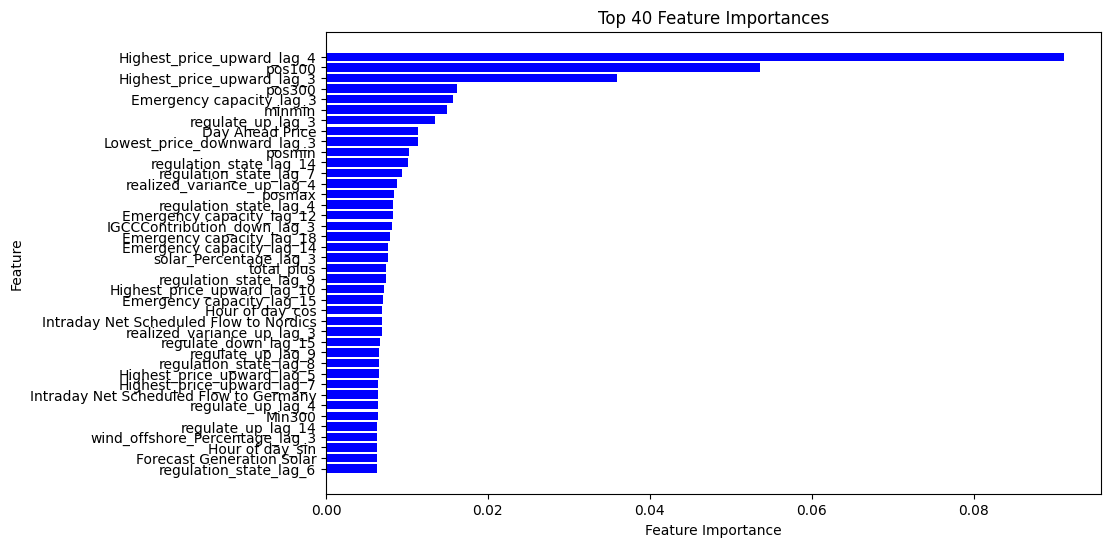

In [ ]:
# Get feature importances
feature_importances = xgb_model.feature_importances_

# Create a DataFrame for better visualization
features = pd.DataFrame({
    'Feature': [col for col in X_XGB.columns],
    'Importance': feature_importances
})

# Sort features by importance
features = features.sort_values(by='Importance', ascending=False)

# Plot top N features
N = 40  # Number of top features to plot
top_features = features.head(N)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='b')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title(f'Top {N} Feature Importances')
plt.gca().invert_yaxis()
plt.show()

## Rolling predictions

### Functions

In [ ]:
def save_predictions_to_csv(predictions, filename, start_date=None, end_date=None, final_save=False):
    # Convert list of dataframes to a single dataframe
    df = pd.concat(predictions)

    if final_save:
      # Define the file path
      file_path = f'{filename}_{start_date.strftime("%Y%m%d")}-{end_date.strftime("%Y%m%d")}.csv'
    else:
      file_path = f'{filename}_temp.csv'

    # Save the dataframe to CSV
    df.to_csv(file_path)
    print(f'Saved predictions to {file_path}')

In [ ]:
import traceback
import time
def rolling_walk_forward_XGB(model, X, y, start_datetime, end_datetime, window_length, filename, quantiles=None):
  try:
      start_datetime, end_datetime = pd.to_datetime(start_datetime), pd.to_datetime(end_datetime)

      # Create a numpy series that will store the predictions.
      predictions = []

      # Initialize the current date and last save date
      current_date = start_datetime
      last_save_date = start_datetime

      while current_date <= end_datetime:
        # print(f'Current date: {current_date}')

        if current_date.day == 1:
          print(f'Current date: {current_date}')

        # If value is missing skip to next interval
        if current_date not in X.index:
          current_date += pd.Timedelta(minutes=15)
          continue

        # Create training set equal to the pre-set window length and test set to one day
        train_start, train_end  = current_date - pd.Timedelta(days=window_length), current_date - pd.Timedelta(minutes=15)
        test_start, test_end  = current_date, current_date + pd.Timedelta(days=1) - pd.Timedelta(minutes=15)
        X_train, y_train = X[train_start:train_end], y[train_start:train_end]
        X_test, y_test = X[test_start:test_end], y[test_start:test_end]

        # Fit the model with early stopping
        model.fit(X_train, y_train)

        if quantiles is None:
          y_pred_test = pd.Series(model.predict(X_test), index=y_test.index)
        else:
          y_pred_test = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=quantiles)

        predictions.append(y_pred_test)

        # Check if 7 days have passed since the last save
        if current_date - last_save_date >= pd.Timedelta(days=7):
            # Save predictions to CSV
            save_predictions_to_csv(predictions, filename)
            # Reset the last save date
            last_save_date = current_date

        current_date += pd.Timedelta(days=1)

      # Save the final batch of predictions
      if predictions:
          save_predictions_to_csv(predictions, filename, start_datetime, current_date, final_save=True)

      return pd.concat(predictions)

  except Exception:
        print("Error: rolling_walk_forward_validation method.")
        traceback.print_exc()

### Predict

In [ ]:
hyperparameter_sets = {
    'First quarter' : {'n_estimators': 973, 'max_depth': 7, 'reg_alpha': 0.9173214547368091, 'reg_lambda': 2.2762803254469413, 'min_child_weight': 12, 'gamma': 1.7650994404821672, 'learning_rate': 0.011097391745930484, 'colsample_bytree': 0.88, 'subsample': 0.69},
    'Second quarter' : {'n_estimators': 973, 'max_depth': 7, 'reg_alpha': 0.9173214547368091, 'reg_lambda': 2.2762803254469413, 'min_child_weight': 12, 'gamma': 1.7650994404821672, 'learning_rate': 0.011097391745930484, 'colsample_bytree': 0.88, 'subsample': 0.69},
    'Third quarter' : {'n_estimators': 973, 'max_depth': 7, 'reg_alpha': 0.9173214547368091, 'reg_lambda': 2.2762803254469413, 'min_child_weight': 12, 'gamma': 1.7650994404821672, 'learning_rate': 0.011097391745930484, 'colsample_bytree': 0.88, 'subsample': 0.69},
    'Fourth quarter' : {'n_estimators': 973, 'max_depth': 7, 'reg_alpha': 0.9173214547368091, 'reg_lambda': 2.2762803254469413, 'min_child_weight': 12, 'gamma': 1.7650994404821672, 'learning_rate': 0.011097391745930484, 'colsample_bytree': 0.88, 'subsample': 0.69},
}

In [ ]:
test_start_2023 = '2023-01-01 00:00:00'
test_end_2023 = '2023-12-31 22:45:00'

In [ ]:
filename = 'Results/XGB_rolling_predictions'

# Train the model
model = XGBRegressor(**hyperparameter_sets['First quarter'],
                        #  early_stopping_rounds = 100,
                         random_state=0,
                         tree_method='hist',  # Use GPU
                         device = "cuda",
                         objective = 'reg:quantileerror',  # For regression task
                         quantile_alpha = alphas,
                         n_jobs=1)

window_length = 365
test_start_temp = pd.to_datetime(test_end) - pd.Timedelta(days=1)
# test_end_temp = pd.to_datetime(test_start) + pd.Timedelta(days=2)

# Define the desired quantiles
quantiles = [0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95]

# Record the start time
start_time = time.time()

rolling_pred_quantiles_XGB = rolling_walk_forward_XGB(model, X_XGB, y, test_start_temp, test_end, window_length, filename, quantiles)

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Elapsed time:", elapsed_time, "seconds")

# np.save('Results/XGB/XGB_quantile_predictions_20220901-20230101_test.npy', rolling_pred_quantiles_XGB)
# np.save('Results/XGB/XGB_quantile_predictions_2023-2024_test.npy', rolling_pred_quantiles_XGB)

Current date: 2022-12-30 23:45:00


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:10:21] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


Current date: 2022-12-31 23:45:00


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:10:42] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


Saved predictions to Results/XGB_quantile_predictions_20221230-20230101.csv
Elapsed time: 44.83498573303223 seconds


# Analysis

## Load in forecasts

2022 last three months

In [ ]:
# Define the intraday price and the forecasts
imbalance_prices = y_test
intraday_prices = df['3to1_price'][test_start:test_end]

# Load in rolling Naive predictions and average duplicates
naive_pred = np.load('Results/Naive/naive_quantile_predictions_20220901-20230101_test.npy')
naive_forecasts = pd.DataFrame(naive_pred, index=y_test.index, columns=quantiles)

# Load in rolling LEAR predictions and average duplicates
rolling_pred_quantiles_LEAR = np.load('Results/LEAR/LEAR_quantile_predictions_20220901-20230101_test.npy')
LEAR_forecasts = pd.DataFrame(rolling_pred_quantiles_LEAR, index=y_test.index, columns=quantiles)

# Load in XGB predictions and average duplicates
rolling_pred_quantiles_XGB = np.load('Results/XGB/XGB_static_predictions_20220901-20230101_test.npy')
XGB_forecasts = pd.DataFrame(rolling_pred_quantiles_XGB, index=y_test.index, columns=quantiles)
# XGB_forecasts = pd.DataFrame(y_pred_test_XGB_quantiles, index=y_test.index, columns=quantiles).groupby(y_test.index).mean()

2023

In [ ]:
test_start_2023 = '2023-01-01 00:00:00'
test_end_2023 = '2023-12-31 22:45:00'

# Define the intraday price and the forecasts
imbalance_prices = y[test_start_2023:test_end_2023]
intraday_prices = df['3to1_price'][test_start_2023:test_end_2023]

# Load in rolling Naive predictions and average duplicates
# naive_pred = df['3to1_price'][test_start_2023:test_end_2023]
# naive_forecasts = pd.DataFrame(naive_pred, index=y[test_start_2023:test_end_2023].index, columns=[0.5]).groupby(y[test_start_2023:test_end_2023].index).mean()
naive_pred = np.load('Results/Naive/naive_quantile_predictions_2023-2024_test.npy')
naive_forecasts = pd.DataFrame(naive_pred, index=y[test_start_2023:test_end_2023].index, columns=quantiles)

# Load in rolling LEAR predictions and average duplicates
# rolling_pred_quantiles_LEAR = np.load('Results/LEAR/LEAR_predictions_2023-2024_test.npy')
# LEAR_forecasts = pd.DataFrame(rolling_pred_quantiles_LEAR, index=y[test_start_2023:test_end_2023].index, columns=[0.5]).groupby(y[test_start_2023:test_end_2023].index).mean()

rolling_pred_quantiles_LEAR = np.load('Results/LEAR/LEAR_quantile_predictions_2023-2024_test.npy')
LEAR_forecasts = pd.DataFrame(rolling_pred_quantiles_LEAR, index=y[test_start_2023:test_end_2023].index, columns=quantiles)

# Load in XGB predictions and average duplicates
# rolling_pred_quantiles_XGB = np.load('Results/XGB/XGB_quantile_predictions_20220901-20230101_test.npy')
# XGB_forecasts = pd.DataFrame(rolling_pred_quantiles_XGB, index=y[test_start_2023:test_end_2023].index, columns=quantiles).groupby(y[test_start_2023:test_end_2023].index).mean()
# XGB_forecasts = pd.DataFrame(y_pred_test_XGB_quantiles, index=y[test_start_2023:test_end_2023].index, columns=quantiles).groupby(y[test_start_2023:test_end_2023].index).mean()

### Fill EMS template with forecasts

In [ ]:
def fill_missing_forecasts(forecasts, intraday_prices, freq='15T'):
    """
    Reindexes the forecasts series to include all timestamps from intraday_prices
    and fills missing forecast values with corresponding intraday prices.

    Parameters:
    forecasts (pd.Series): The series containing forecasted prices with potential missing data.
    intraday_prices (pd.Series): The series containing intraday prices for each timestamp.
    freq (str): The frequency for the index reindexing (default is '15T' for quarter-hourly).

    Returns:
    pd.Series: The series with missing forecast values filled with intraday prices.
    """
    # Ensure the indexes of both series are datetime
    forecasts.index = pd.to_datetime(forecasts.index)
    intraday_prices.index = pd.to_datetime(intraday_prices.index)

    # Generate a complete range of timestamps based on intraday_prices' index
    complete_index = pd.date_range(start=intraday_prices.index.min(),
                                   end=intraday_prices.index.max(),
                                   freq=freq)

    # Reindex the forecasts to include all timestamps from complete_index
    forecasts_reindexed = forecasts.reindex(complete_index)

    # Fill missing forecast values with intraday prices
    forecasts_filled = forecasts_reindexed.fillna(intraday_prices)

    return forecasts_filled

In [ ]:
def preprocess_template(df, forecasts, intraday_prices):
  df = df.copy()
  forecasts = forecasts.copy()
  intraday_prices = intraday_prices.copy()

  # Localise to UTC
  df['start_datetime'] = df['start_datetime'].dt.tz_localize('UTC')
  forecasts.index = forecasts.index.tz_localize('UTC')
  intraday_prices.index = intraday_prices.index.tz_localize('UTC')

  # Set index
  df.set_index('start_datetime', inplace=True)

  # Only keep the test set
  df = df[test_start_2023:test_end_2023]

  # Fill missing forecasts with intraday price
  forecasts = fill_missing_forecasts(forecasts, intraday_prices)

  # Insert the forecasts as the fourth column
  # df.insert(3, 'Price_T_minus_3h_EUR_per_MWh', forecasts)
  df.loc[:, 'Price_T_minus_3h_EUR_per_MWh'] = forecasts

  return df

In [ ]:
def create_template(forecasts, forecast_name, intraday_prices):
  df = pd.read_csv('Intraday/EMS Intraday Template.csv', parse_dates=['start_datetime'])
  df = preprocess_template(df, forecasts, intraday_prices)
  df.to_csv(f'EMS Templates/EMS Intraday Template {forecast_name} 2023.csv')
  return df

In [ ]:
# Download Intraday prices
intraday_df = pd.read_csv('Intraday/Intraday Preprocessed.csv', parse_dates=['start_datetime'])
intraday_df.set_index('start_datetime', inplace=True)
intraday_prices_ems = intraday_df['3to1_price'][test_start_2023:test_end_2023].fillna(df['Day Ahead Price']).ffill()
intraday_prices_ems_full = intraday_df['start_to_1_price'][test_start_2023:test_end_2023].fillna(df['Day Ahead Price']).ffill()
# intraday_prices_ems_old = intraday_df['start_to_1_price'][test_start_2023:test_end_2023].fillna(df['IDfull_price']).ffill()

In [ ]:
forecasts = [intraday_prices, naive_forecasts[0.5].groupby(y[test_start_2023:test_end_2023].index).mean(), LEAR_forecasts[0.5].groupby(y[test_start_2023:test_end_2023].index).mean()]
forecast_names = ['ID3 to ID1', 'Naive', 'LEAR']

for forecast, forecast_name in zip(forecasts, forecast_names):
  template = create_template(forecast, forecast_name, intraday_prices_ems)

## Benchmarks

### Functions

In [ ]:
def print_naive_metrics(y_pred, start_date, end_date):
  y_pred = duplicate_X(y_pred, duplicated_indices)

  non_missing_values = y_pred[start_date:end_date].notna()

  print_mean_metrics(y[start_date:end_date][non_missing_values], y_pred[start_date:end_date][non_missing_values])
  mae, rmse, smape = retrieve_mean_metrics(y[start_date:end_date][non_missing_values], y_pred[start_date:end_date][non_missing_values])

  return mae, rmse, smape

In [ ]:
# Define a function to print metrics for predictions
def print_retrieve_metrics(prediction, label):
    print(f'{label}:')
    mae, rmse, smape = print_naive_metrics(prediction, start_date_eval, end_date_eval)
    print()
    return mae, rmse, smape

In [ ]:
def plot_benchmark_metrics(benchmarks_to_plot, metrics_dict, metric_names=['MAE', 'RMSE'], save=False, filename=None):
    """
    Plots bar charts for selected error metrics across specified models.

    Args:
        benchmarks_to_plot (list): List of benchmarks names to plot.
        metrics_dict (dict): Dictionary containing error metrics for all models.
        metric_names (list): List of metrics to plot (default is ['MAE', 'RMSE']).
    """
    # Initialize lists to store metric values for selected models
    metric_values = {metric: [] for metric in metric_names}
    benchmarks = []

    # Extract metric values for the selected models
    for benchmark in benchmarks_to_plot:
        if benchmark in metrics_dict:
            benchmarks.append(benchmark)
            for metric in metric_names:
                metric_values[metric].append(metrics_dict[benchmark].get(metric, np.nan))

    # Define the positions of the bars and bar width
    x = np.arange(len(benchmarks))
    width = 0.35

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 7))

    # Set up bars for each metric
    for i, (metric, values) in enumerate(metric_values.items()):
        # Offset each set of bars slightly for visibility
        bar_positions = x + (i - len(metric_values) / 2) * width
        bars = ax.bar(bar_positions, values, width, label=metric)

        # Annotate the bars with their values
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=12)  # Font size for annotations

    # Add labels, title, and custom x-axis tick labels with increased font sizes
    # ax.set_xlabel('Benchmarks', fontsize=14)
    ax.set_ylabel('Error Metrics', fontsize=14)
    ax.set_title('Error Metrics for Benchmarks', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(benchmarks, ha='right', fontsize=14)
    ax.legend(fontsize=12)

    plt.tight_layout()

    if save:
      plt.savefig(f'{filename}.png')

    # Show plot
    plt.show()

### Printing

In [ ]:
start_date_eval = '2023-01-01 00:00:00'
end_date_eval = '2023-12-31 22:45:00'

# Create predictions by shifting relevant columns
predictions = {
    'Day Ahead': df['Day Ahead Price'].shift(-4),
    'ID3 to ID1': df['3to1_price'].shift(-4),
    'IDfull to ID1': df['start_to_1_price'].shift(-4),
    'True ID1': df['id1_price'].shift(-4),
    'True ID3': df['id3_price'].shift(-4),
    'True IDfull': df['idfull_price'].shift(-4),
    'Lagged ID1': df['id1_price'].shift(1),
    'Lagged ID3': df['id3_price'].shift(1),
    'Lagged IDfull': df['idfull_price'].shift(1),
    'Last Imbalance': df_naive['average_price'].shift(1)
}

metrics = {}
# Print predictions and their metrics
for label, prediction in predictions.items():
    mae, rmse, smape = print_retrieve_metrics(prediction, label)
    metrics[label] = {'MAE': mae, 'RMSE': rmse, 'SMAPE': smape}

Day Ahead:
MAE: 77.97624534722961, RMSE: 186.84628700101058, sMAPE: 71.96427547210335

ID3 to ID1:
MAE: 76.91925579381297, RMSE: 179.71434880848938, sMAPE: 70.43918243397701

IDfull to ID1:
MAE: 76.66203478226835, RMSE: 180.66396458734778, sMAPE: 70.28591357735783

True ID1:
MAE: 78.90945097309368, RMSE: 174.07255217541626, sMAPE: 71.96189111594119

True ID3:
MAE: 75.9306880782729, RMSE: 176.89646018621113, sMAPE: 69.55638650635301

True IDfull:
MAE: 75.80360626529092, RMSE: 178.20229015145804, sMAPE: 69.42656209424725

Lagged ID1:
MAE: 94.29766404339041, RMSE: 196.01436723857014, sMAPE: 81.7453970749857

Lagged ID3:
MAE: 86.0971886631926, RMSE: 190.28398426523103, sMAPE: 76.48887023933479

Lagged IDfull:
MAE: 84.8964375548406, RMSE: 189.27435794301374, sMAPE: 75.85595134821378

Last Imbalance:
MAE: 105.63231162043229, RMSE: 247.62617113782116, sMAPE: 77.77414435638812



### Bar plots

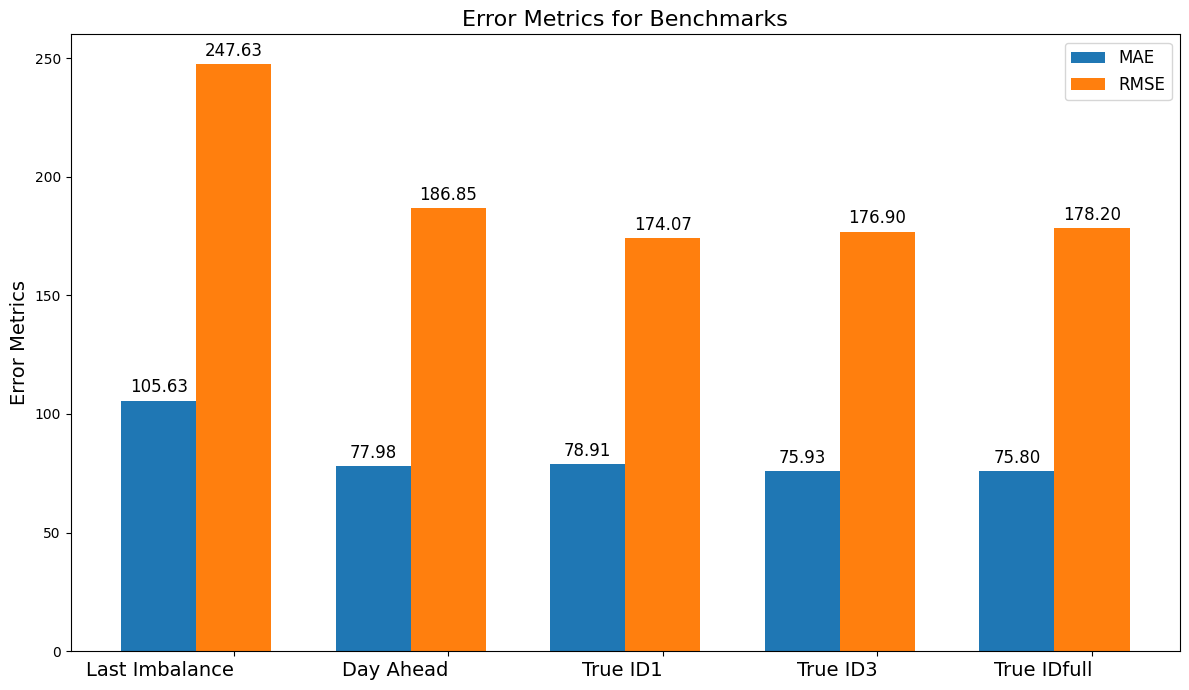

In [ ]:
# Call the function to plot selected metrics
plot_benchmark_metrics(
    benchmarks_to_plot=['Last Imbalance', 'Day Ahead', 'True ID1', 'True ID3', 'True IDfull'],
    metrics_dict=metrics,
    save=True,
    filename='Results/Plots/Error Metrics True IDs'
)

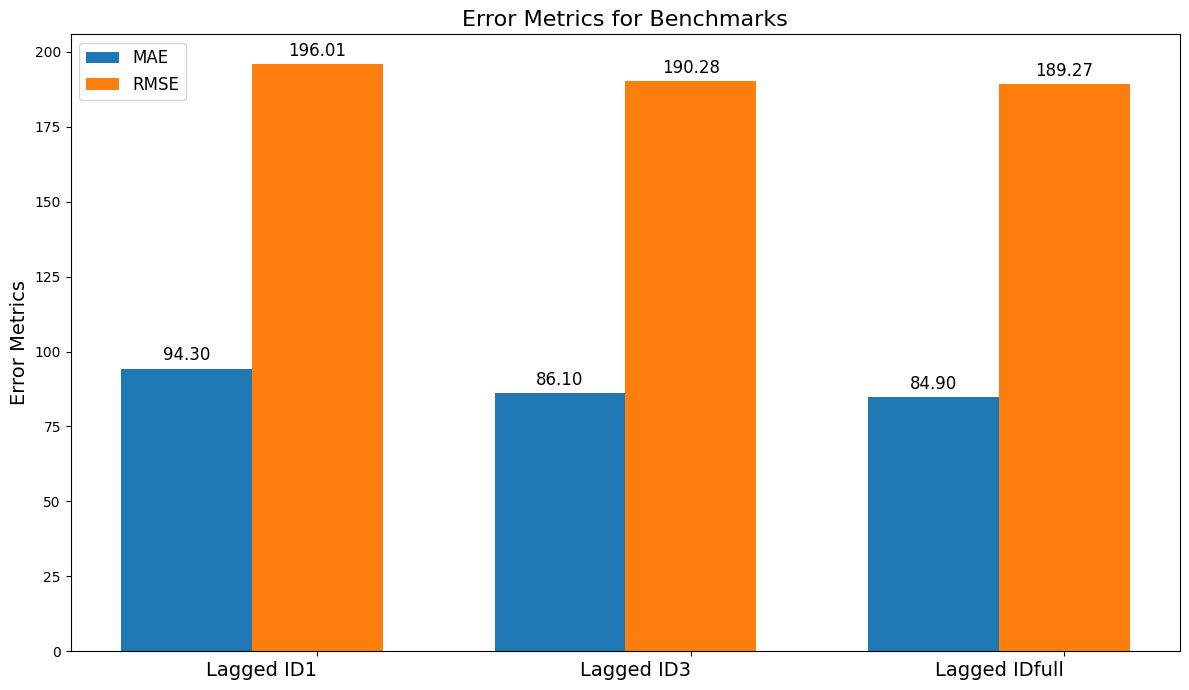

In [ ]:
# Call the function to plot selected metrics
plot_benchmark_metrics(
    benchmarks_to_plot=['Lagged ID1', 'Lagged ID3', 'Lagged IDfull'],
    metrics_dict=metrics,
    save=False,
    filename='Results/Plots/Error Metrics Lagged IDs'
)

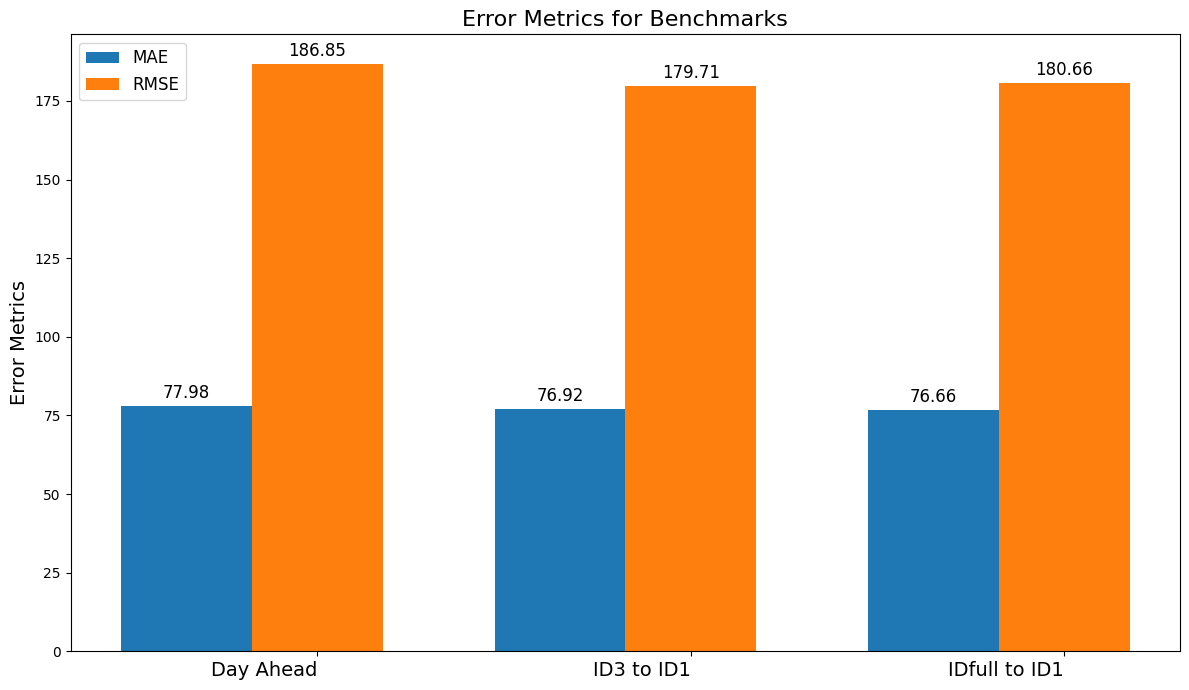

In [ ]:
# Call the function to plot selected metrics
plot_benchmark_metrics(
    benchmarks_to_plot=['Day Ahead', 'ID3 to ID1', 'IDfull to ID1'],
    metrics_dict=metrics,
    save=True,
    filename='Results/Plots/Error Metrics ID to ID1'
)

## Price plotting

### Benchmarks

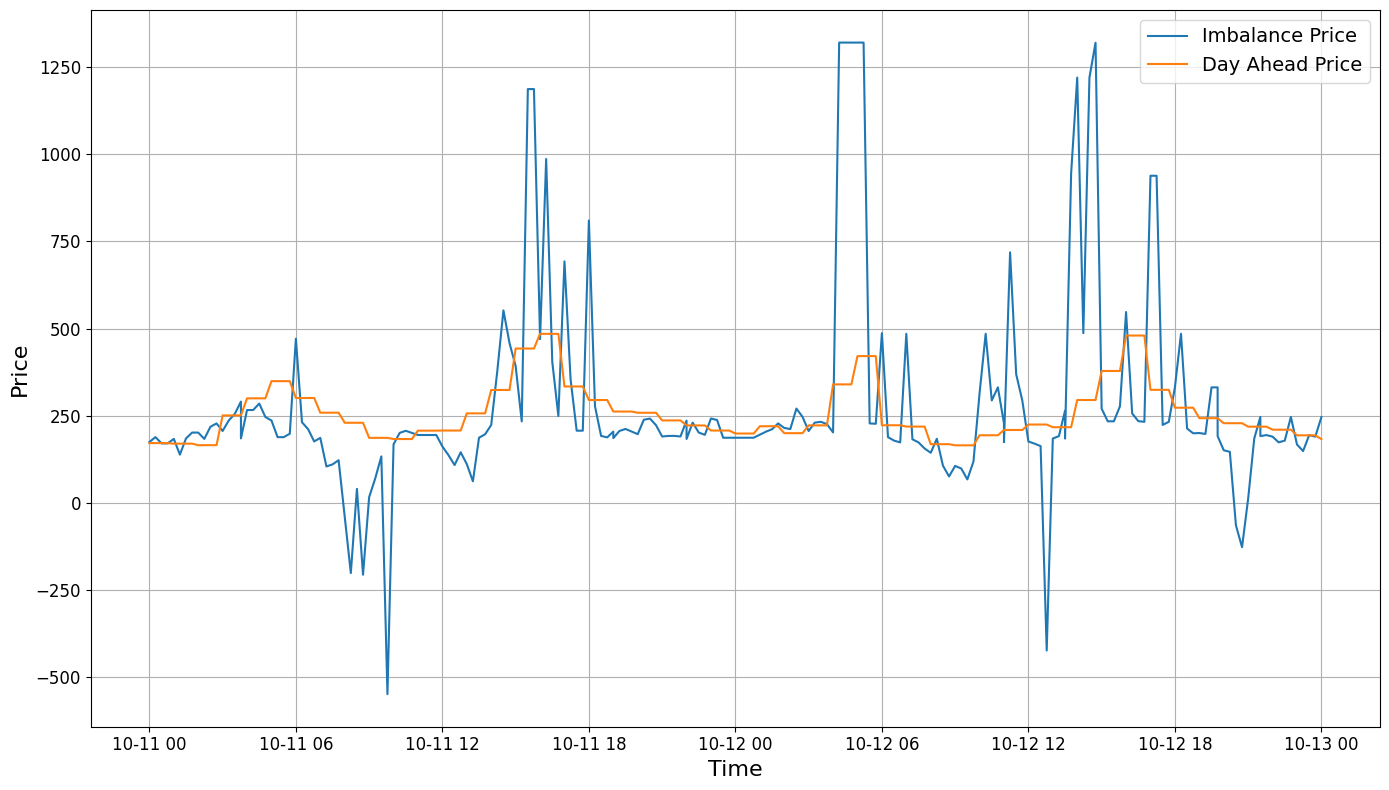

In [ ]:
base_day = 40
plus_days = 2

filename = 'Results/Plots/Plot Only Day Ahead'

# Define the interval to be plotted
interval_start = str(pd.to_datetime(test_start) + pd.Timedelta(days=base_day))
interval_end = str(pd.to_datetime(test_start) + pd.Timedelta(days=base_day+plus_days))

# Define the actual values
y_plot =  y_test[interval_start:interval_end]

# Define the predicted values
y_pred_plot = df['Day Ahead Price'].shift(-4)[interval_start:interval_end]
pred_label = 'Day Ahead Price'

benchmarks = []
benchmark_labels = []

# Plot the series
plot_point_predictions(y_plot, y_pred_plot, pred_label, benchmarks, benchmark_labels, save=True, filename=filename)

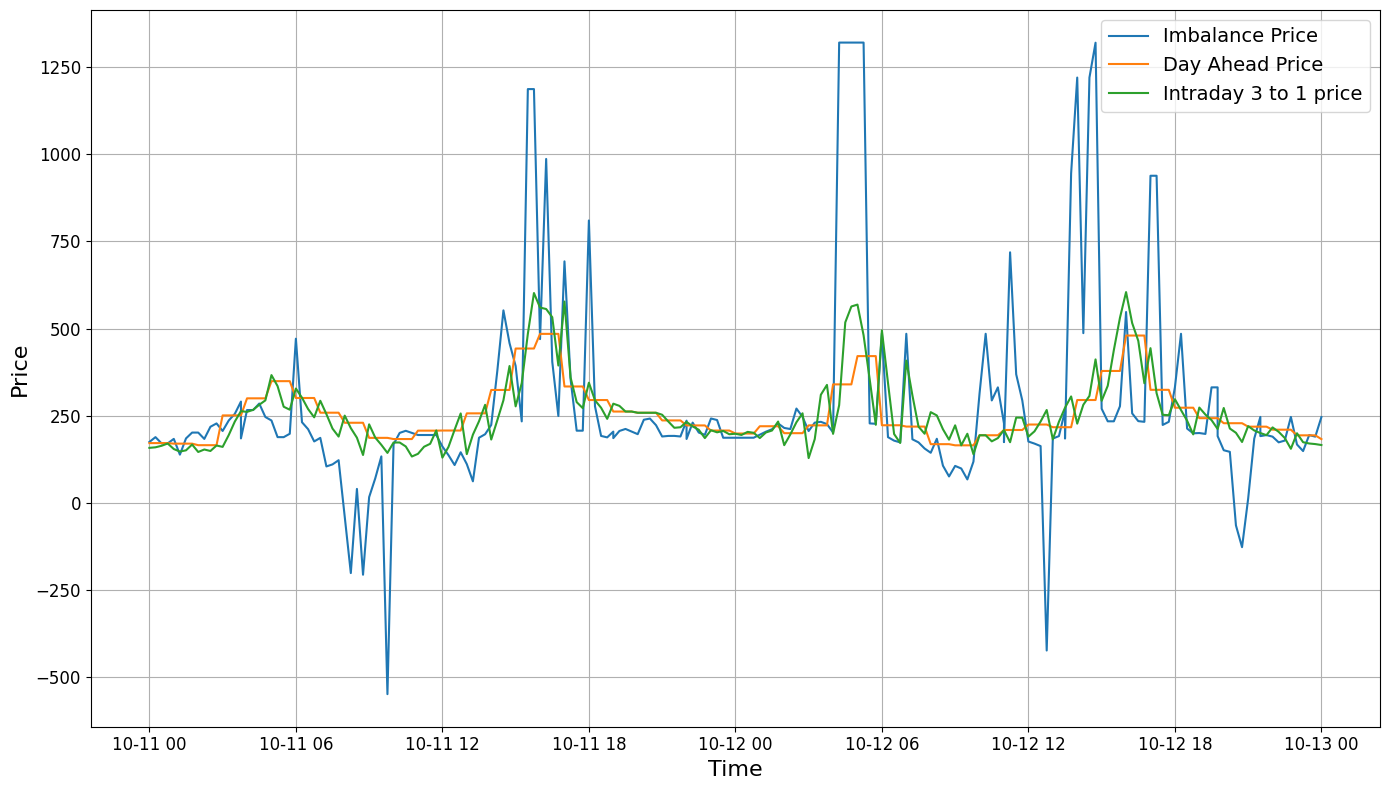

In [ ]:
base_day = 40
plus_days = 2

filename = 'Results/Plots/Plot Day Ahead and Intraday'

# Define the interval to be plotted
interval_start = str(pd.to_datetime(test_start) + pd.Timedelta(days=base_day))
interval_end = str(pd.to_datetime(test_start) + pd.Timedelta(days=base_day+plus_days))

# Define the actual values
y_plot =  y_test[interval_start:interval_end]

# Define the predicted values
y_pred_plot = df['Day Ahead Price'].shift(-4)[interval_start:interval_end]
pred_label = 'Day Ahead Price'

# Define the benchmark
benchmark_3to1 = df['3to1_price'].shift(-4)[interval_start:interval_end]
benchmark_3to1_label = 'Intraday 3 to 1 price'

benchmarks = [benchmark_3to1]
benchmark_labels = [benchmark_3to1_label]

# Plot the series
plot_point_predictions(y_plot, y_pred_plot, pred_label, benchmarks, benchmark_labels, save=True, filename=filename)

### LEAR

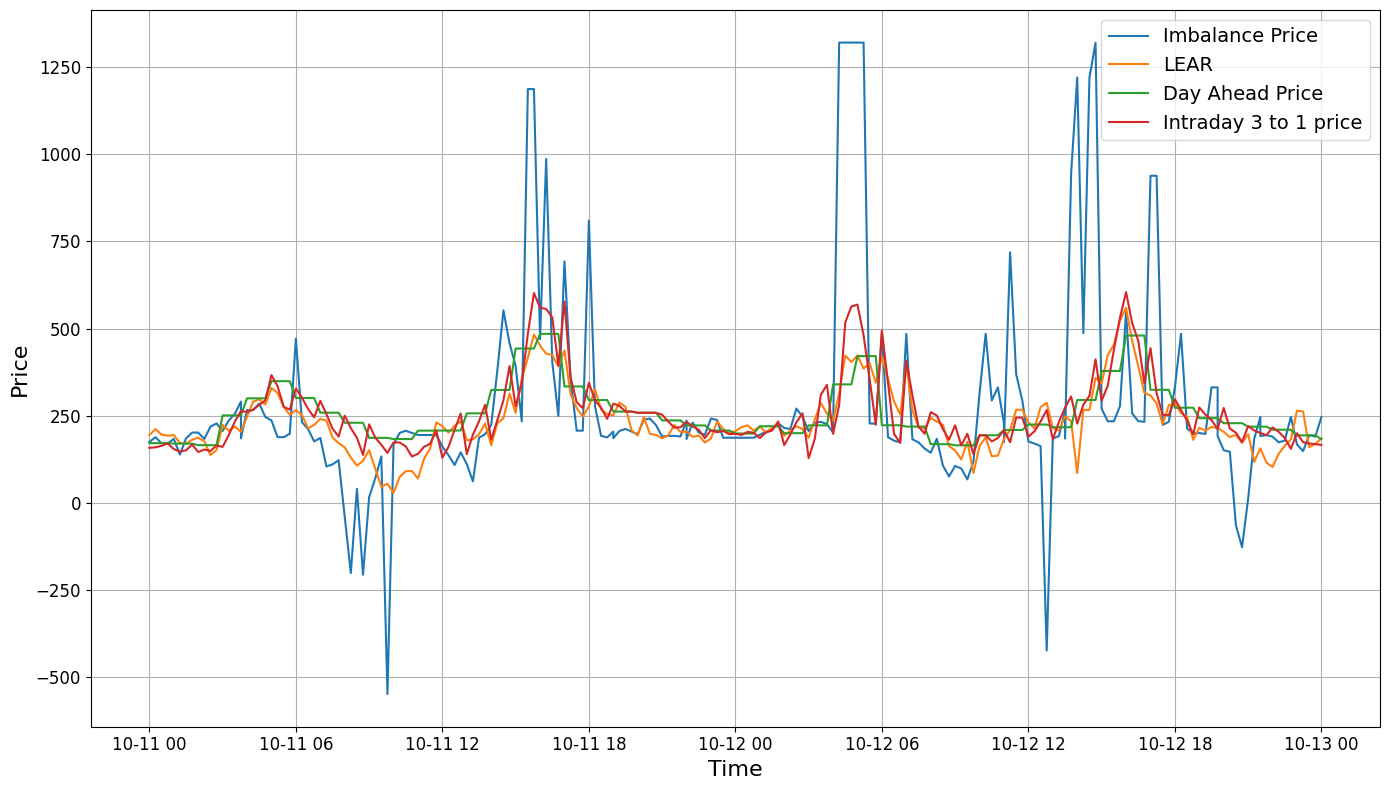

In [ ]:
base_day = 40
plus_days = 2

filename = 'Results/Plots/Plot With LEAR'

# Define the interval to be plotted
interval_start = str(pd.to_datetime(test_start) + pd.Timedelta(days=base_day))
interval_end = str(pd.to_datetime(test_start) + pd.Timedelta(days=base_day+plus_days))


# Define the actual values
y_plot =  y_test[interval_start:interval_end]

# Define the predicted values
y_pred_plot = LEAR_forecasts[0.5][interval_start:interval_end]
pred_label = 'LEAR'

# Define the benchmark
benchmark_day_ahead = df['Day Ahead Price'].shift(-4)[interval_start:interval_end]
benchmark_day_ahead_label = 'Day Ahead Price'

# Define the benchmark
benchmark_3to1 = df['3to1_price'].shift(-4)[interval_start:interval_end]
benchmark_3to1_label = 'Intraday 3 to 1 price'

benchmarks = [benchmark_day_ahead, benchmark_3to1]
benchmark_labels = [benchmark_day_ahead_label, benchmark_3to1_label]

# Plot the series
plot_point_predictions(y_plot, y_pred_plot, pred_label, benchmarks, benchmark_labels, save=True, filename=filename)

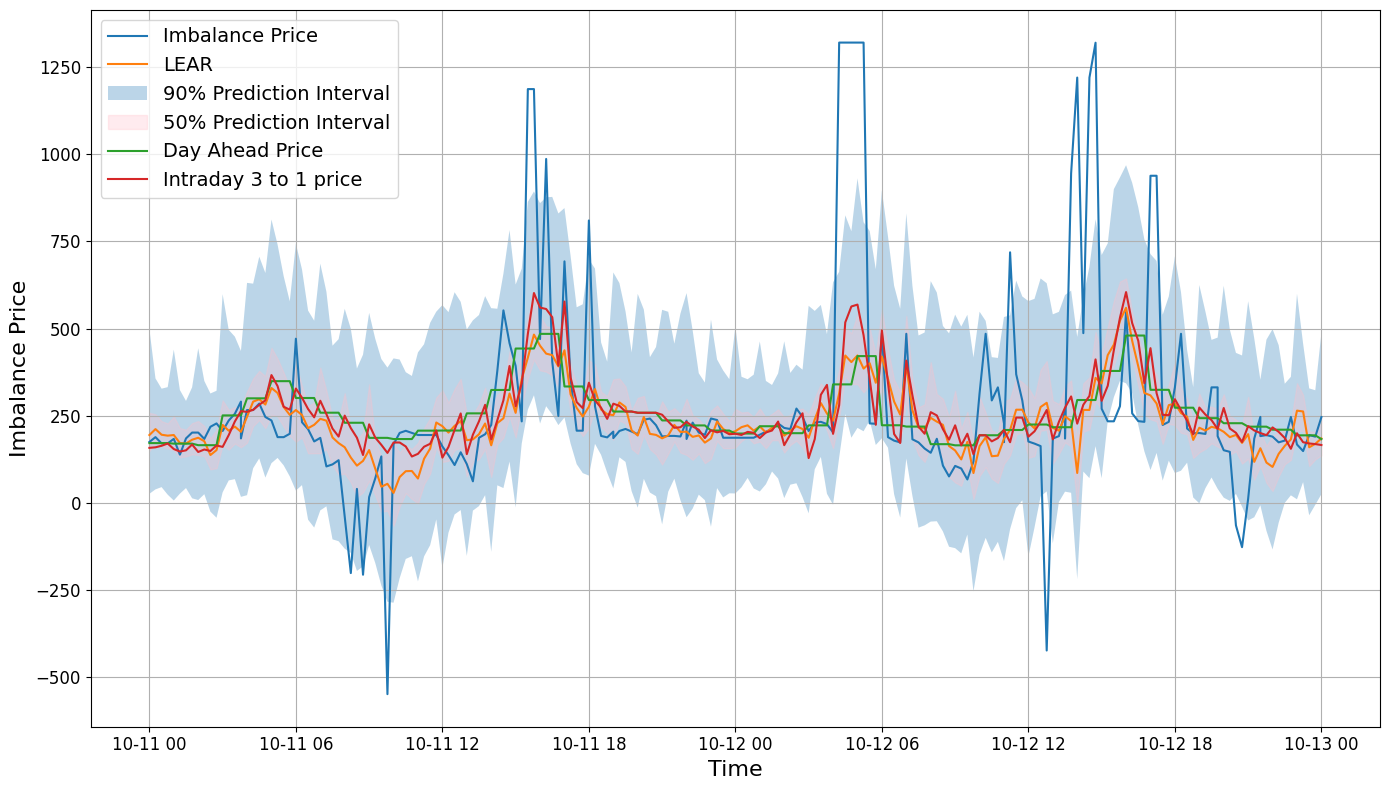

In [ ]:
base_day = 40
plus_days = 2

filename = 'Results/Plots/Plot With LEAR PIs'

# Define the interval to be plotted
interval_start = str(pd.to_datetime(test_start) + pd.Timedelta(days=base_day))
interval_end = str(pd.to_datetime(test_start) + pd.Timedelta(days=base_day + plus_days))

# Define the actual values
y_test_plot = y_test[interval_start:interval_end]

# Define the predicted values
LEAR_test_plot = LEAR_forecasts[interval_start:interval_end]
LEAR_label = 'LEAR'

# Define the benchmarks to plot
day_ahead_plot = df['Day Ahead Price'].shift(-4)[interval_start:interval_end]
day_ahead_label = 'Day Ahead Price'

# Define the benchmark
benchmark_3to1 = df['3to1_price'].shift(-4)[interval_start:interval_end]
benchmark_3to1_label = 'Intraday 3 to 1 price'

benchmarks = [day_ahead_plot, benchmark_3to1]
benchmark_labels = [day_ahead_label, benchmark_3to1_label]
# benchmarks = [benchmark_3to1]
# benchmark_labels = [benchmark_3to1_label]

# Plot the prediction intervals
plot_prediction_intervals(y_test_plot, LEAR_test_plot, LEAR_label, benchmarks, benchmark_labels, save=True, filename=filename)

### XGBoost

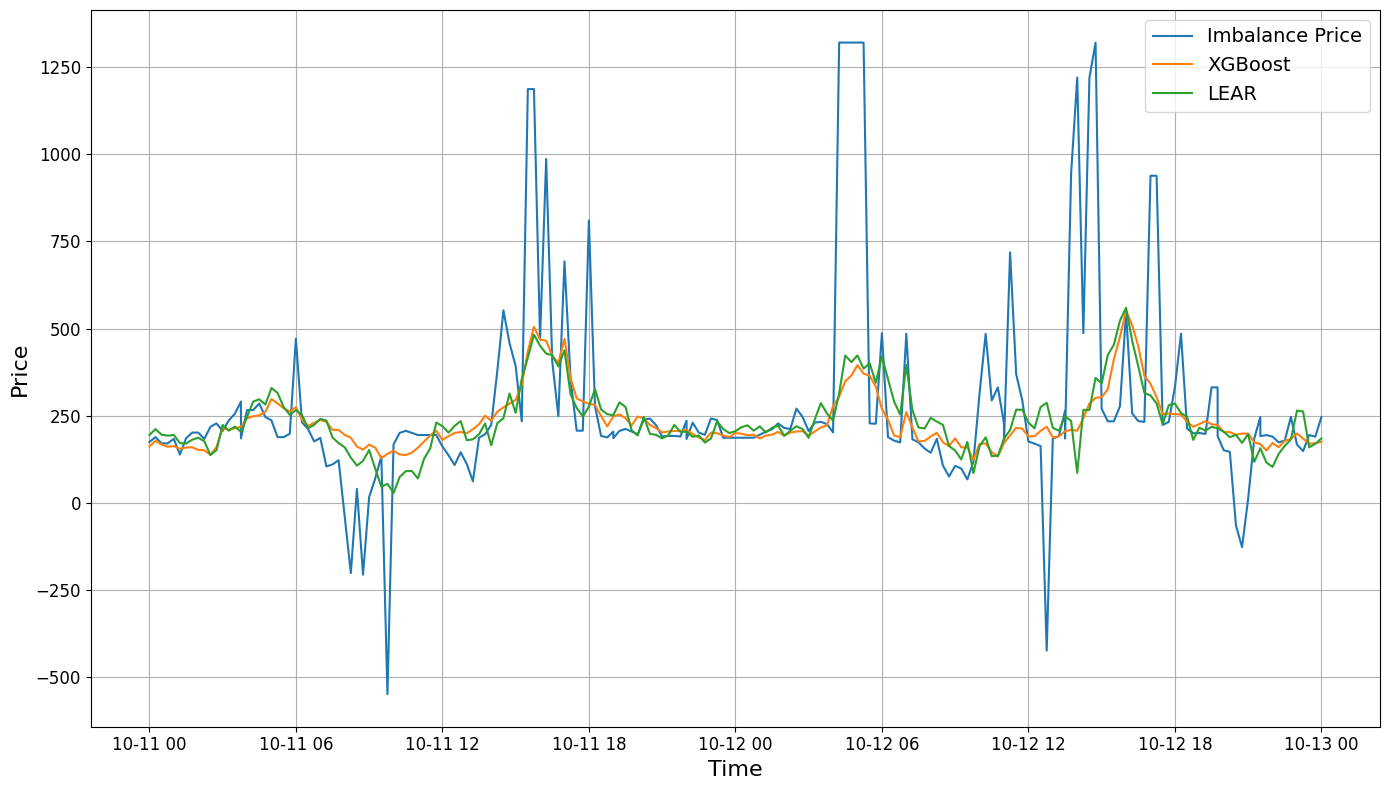

In [ ]:
base_day = 40
plus_days = 2

filename = 'Results/Plots/Plot With XGB'

# Define the interval to be plotted
interval_start = str(pd.to_datetime(test_start) + pd.Timedelta(days=base_day))
interval_end = str(pd.to_datetime(test_start) + pd.Timedelta(days=base_day+plus_days))


# Define the actual values
y_plot =  y_test[interval_start:interval_end]

# Define the predicted values
y_pred_plot = XGB_forecasts[0.5][interval_start:interval_end]
pred_label = 'XGBoost'

# # Define the benchmark
# benchmark_day_ahead = df['Day Ahead Price'].shift(-4)[interval_start:interval_end]
# benchmark_day_ahead_label = 'Day Ahead Price'

# # Define the benchmark
# benchmark_3to1 = df['3to1_price'].shift(-4)[interval_start:interval_end]
# benchmark_3to1_label = 'Intraday 3 to 1 price'

# Define the benchmark
benchmark_LEAR = LEAR_forecasts[0.5][interval_start:interval_end]
benchmark_LEAR_label = 'LEAR'

# benchmarks = [benchmark_day_ahead, benchmark_3to1]
# benchmark_labels = [benchmark_day_ahead_label, benchmark_3to1_label]

benchmarks = [benchmark_LEAR]
benchmark_labels = [benchmark_LEAR_label]

# Plot the series
plot_point_predictions(y_plot, y_pred_plot, pred_label, benchmarks, benchmark_labels, save=False, filename=filename)

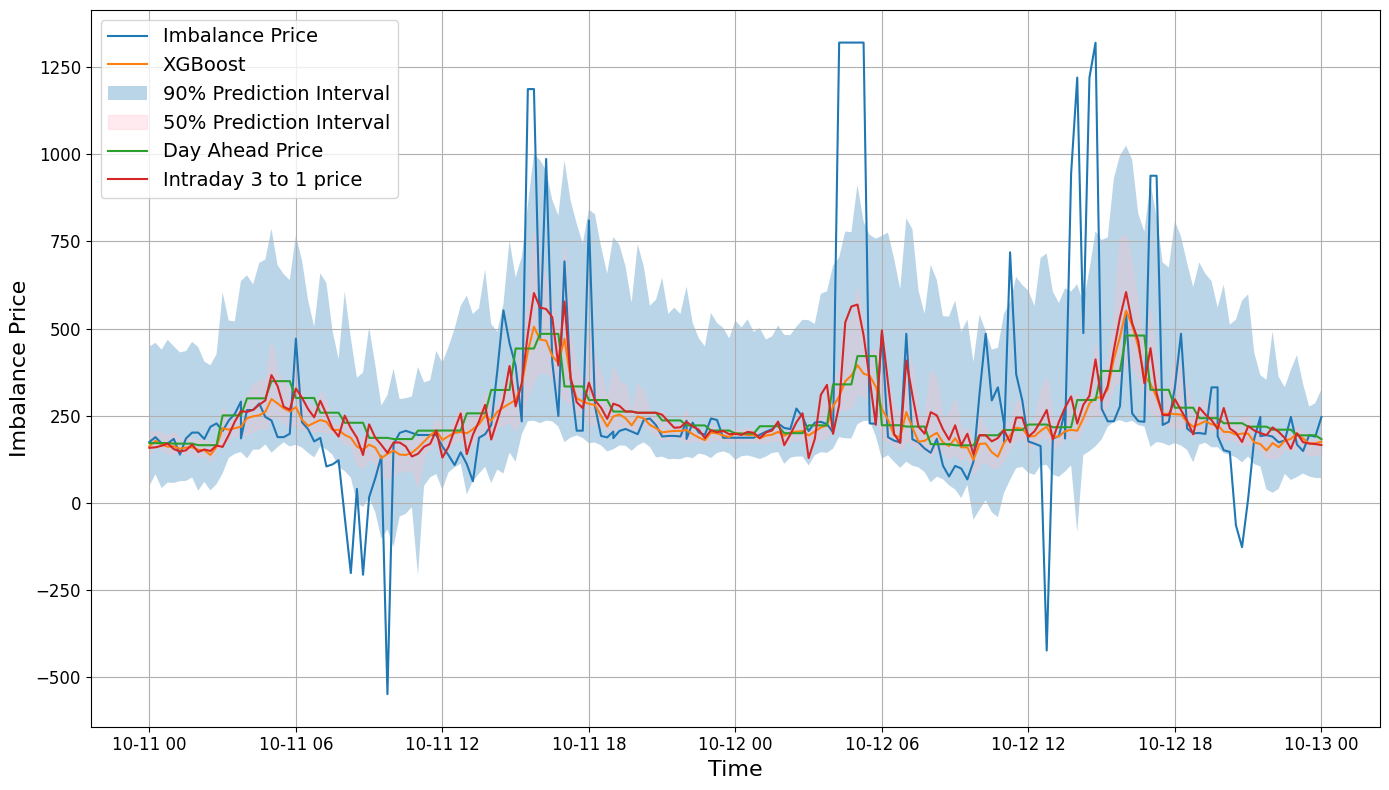

In [ ]:
base_day = 40
plus_days = 2

filename = 'Results/Plots/Plot With XGB PIs'

# Define the interval to be plotted
interval_start = str(pd.to_datetime(test_start) + pd.Timedelta(days=base_day))
interval_end = str(pd.to_datetime(test_start) + pd.Timedelta(days=base_day + plus_days))

# Define the actual values
y_test_plot = y_test[interval_start:interval_end]

# Define the predicted values
LEAR_test_plot = XGB_forecasts[interval_start:interval_end]
LEAR_label = 'XGBoost'

# Define the benchmarks to plot
day_ahead_plot = df['Day Ahead Price'].shift(-4)[interval_start:interval_end]
day_ahead_label = 'Day Ahead Price'

# Define the benchmark
benchmark_3to1 = df['3to1_price'].shift(-4)[interval_start:interval_end]
benchmark_3to1_label = 'Intraday 3 to 1 price'

benchmarks = [day_ahead_plot, benchmark_3to1]
benchmark_labels = [day_ahead_label, benchmark_3to1_label]
# benchmarks = [benchmark_3to1]
# benchmark_labels = [benchmark_3to1_label]

# Plot the prediction intervals
plot_prediction_intervals(y_test_plot, LEAR_test_plot, LEAR_label, benchmarks, benchmark_labels, save=False, filename=filename)

## Model Bar Plots

### Functions

In [ ]:
# Define a function to print metrics for predictions
def print_retrieve_metrics(y, prediction, label, start_date, end_date):
    print(f'{label}:')
    print_mean_metrics(y[start_date:end_date], prediction[start_date:end_date])
    mae, rmse, smape = retrieve_mean_metrics(y[start_date:end_date], prediction[start_date:end_date])
    print()
    return mae, rmse, smape

In [ ]:
def plot_model_metrics(models_to_plot, metrics_dict, period, metric_names=['MAE', 'RMSE'], save=False, filename=None):
    """
    Plots bar charts for selected error metrics across specified models.

    Args:
        models_to_plot (list): List of model names to plot.
        metrics_dict (dict): Dictionary containing error metrics for all models.
        metric_names (list): List of metrics to plot (default is ['MAE', 'RMSE']).
    """
    # Initialize lists to store metric values for selected models
    metric_values = {metric: [] for metric in metric_names}
    models = []

    # Extract metric values for the selected models
    for model in models_to_plot:
        if model in metrics_dict:
            models.append(model)
            for metric in metric_names:
                metric_values[metric].append(metrics_dict[model].get(metric, np.nan))

    # Define the positions of the bars and bar width
    x = np.arange(len(models))
    width = 0.35

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 7))

    # Set up bars for each metric
    for i, (metric, values) in enumerate(metric_values.items()):
        # Offset each set of bars slightly for visibility
        bar_positions = x + (i - len(metric_values) / 2) * width
        bars = ax.bar(bar_positions, values, width, label=metric)

        # Annotate the bars with their values
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=12)  # Font size for annotations

    # Add labels, title, and custom x-axis tick labels with increased font sizes
    # ax.set_xlabel('Models', fontsize=14)
    ax.set_ylabel('Error Metrics', fontsize=14)
    ax.set_title(f'Error Metrics for {period}', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(models, ha='right', fontsize=14)
    ax.legend(fontsize=12)

    plt.tight_layout()

    if save:
      plt.savefig(f'{filename} {period}.png')

    # Show plot
    plt.show()

### Plotting

In [ ]:
# start_date_eval = '2023-01-01 00:00:00'
# end_date_eval = '2023-12-31 22:45:00'
start_date_eval = test_start
end_date_eval = test_end

duplicated_day_ahead = duplicate_X(df['Day Ahead Price'].shift(-4), duplicated_indices)
duplicated_id3_to_id1 = duplicate_X(df['3to1_price'].shift(-4), duplicated_indices)

# Create predictions by shifting relevant columns
predictions = {
    'Day Ahead': duplicated_day_ahead,
    'ID3 to ID1': duplicated_id3_to_id1,
    'LEAR': LEAR_forecasts[0.5],
    'XGBoost': XGB_forecasts[0.5]
}

metrics = {}
# Print predictions and their metrics
for label, prediction in predictions.items():
    mae, rmse, smape = print_retrieve_metrics(y, prediction, label, start_date_eval, end_date_eval)
    metrics[label] = {'MAE': mae, 'RMSE': rmse, 'SMAPE': smape}

Day Ahead:
MAE: 119.31957537325414, RMSE: 200.09232900739786, sMAPE: 63.1494054674146

ID3 to ID1:
MAE: 115.62211891347759, RMSE: 190.74137128347692, sMAPE: 62.191724200115765

LEAR:
MAE: 113.10804329372556, RMSE: 189.71657095888915, sMAPE: 62.87878115151053

XGBoost:
MAE: 110.32174083831539, RMSE: 194.78420258018832, sMAPE: 58.97356717817512



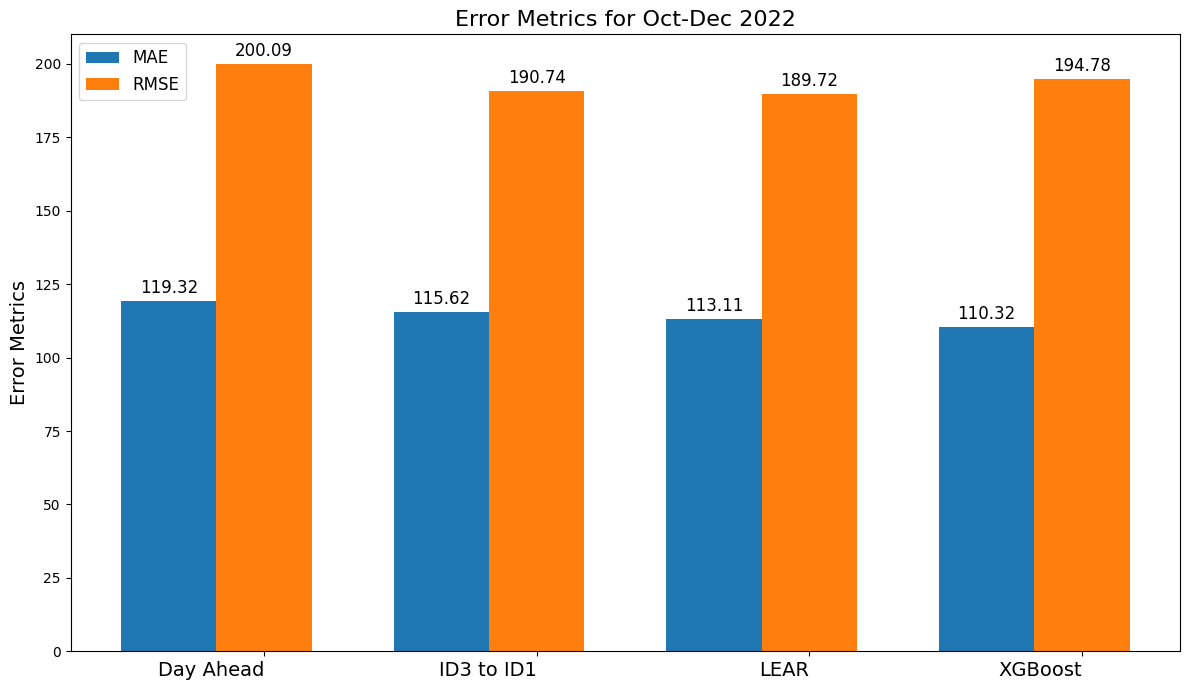

In [ ]:
# Call the function to plot selected metrics
plot_model_metrics(
    models_to_plot=['Day Ahead', 'ID3 to ID1', 'LEAR', 'XGBoost'],
    metrics_dict=metrics,
    period = 'Oct-Dec 2022',
    save=True,
    filename='Results/Plots/Error Metrics Models'
)

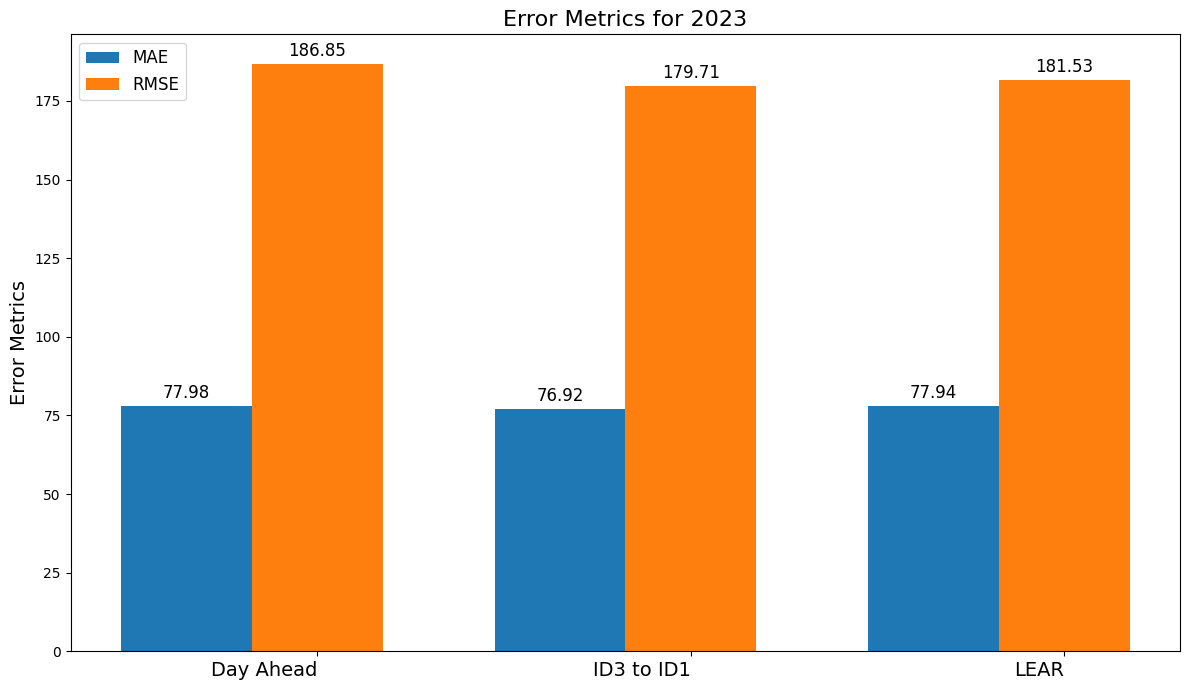

In [ ]:
# Call the function to plot selected metrics
plot_model_metrics(
    models_to_plot=['Day Ahead', 'ID3 to ID1', 'LEAR'],
    metrics_dict=metrics,
    period = '2023',
    save=False,
    filename='Results/Plots/Error Metrics Models'
)

## Accuracy

### Functions

In [ ]:
def plot_pinball_scores(pinball_scores_naive, pinball_scores_lear, pinball_scores_xgb, save=False, filename= None):

    # Plotting Pinball scores
    plt.figure(figsize=(12, 5))

    # Left Plot - Pinball Score
    plt.subplot(1, 2, 1)
    plt.plot(quantiles, pinball_scores_naive, label='Naive', color='blue')
    plt.plot(quantiles, pinball_scores_lear, label='LEAR', color='orange')
    plt.plot(quantiles, pinball_scores_xgb, label='XGBoost', color='green')
    plt.xlabel('Quantile')
    plt.ylabel('Pinball Score')
    plt.title('Pinball Score')
    plt.legend()
    # plt.grid(True)
    plt.xticks([q for q in quantiles if q not in [0.45, 0.55]])

    # Right Plot - Ratio to Naive
    plt.subplot(1, 2, 2)
    ratio_to_naive_lear = pinball_scores_lear / pinball_scores_naive
    ratio_to_naive_xgb = pinball_scores_xgb / pinball_scores_naive

    plt.plot(quantiles, np.ones_like(quantiles), label='Naive', color='blue')
    plt.plot(quantiles, ratio_to_naive_lear, label='LEAR', color='orange')
    plt.plot(quantiles, ratio_to_naive_xgb, label='XGBoost', color='green')
    plt.xlabel('Quantile')
    plt.ylabel('Ratio to Naive')
    plt.title('Ratio to Naive')
    plt.legend()
    # plt.grid(True)
    plt.xticks([q for q in quantiles if q not in [0.45, 0.55]])

    plt.tight_layout()
    plt.show()

    if save:
      plt.savefig(f'{filename}.png')

### Print

In [ ]:
forecasts_list = [naive_forecasts, LEAR_forecasts, XGB_forecasts]
labels = ['Naive', 'LEAR', 'XGBoost']
print('Point Forecast Metrics:')
print()
for i, forecasts in enumerate(forecasts_list):
  print(f'{labels[i]}')
  print_mean_metrics(true_surplus_price, forecasts[0.5])
  print()

Point Forecast Metrics:

Naive
MAE: 112.80397700426808, RMSE: 192.35619671884433, sMAPE: 62.301177467078965

LEAR
MAE: 113.2480283491626, RMSE: 190.1136259773845, sMAPE: 63.38636028326158

XGBoost
MAE: 111.23192301133754, RMSE: 195.91305906219307, sMAPE: 60.16412928623832



In [ ]:
forecasts_list = [naive_forecasts, LEAR_forecasts, XGB_forecasts]
labels = ['Naive', 'LEAR', 'XGBoost']
print('Probilistic Forecast Metrics:')
print()
for i, forecasts in enumerate(forecasts_list):
  print(f'{labels[i]}:')
  print_quantile_metrics(true_surplus_price, forecasts.to_numpy(), quantiles)
  print()

Probilistic Forecast Metrics:

Naive:
Pinball 0.05: 17.1463812861511
Pinball 0.15: 34.10531433614629
Pinball 0.25: 44.57985258241548
Pinball 0.35: 51.18096741163701
Pinball 0.45: 55.152278849864864
Pinball 0.5: 56.40198850213404
Pinball 0.55: 57.14912652755078
Pinball 0.65: 57.01627024501604
Pinball 0.75: 54.34005190017857
Pinball 0.85: 47.40841433337856
Pinball 0.95: 29.12826480700293

CRPS: 45.78262825286143

Wrinkler 90.0%: 570.4132665255065
Coverage 90.0%: 0.8933572404371585
Wrinkler 70.0%: 373.8819867330478
Coverage 70.0%: 0.6869023224043715
Wrinkler 50.0%: 395.67961793037614
Coverage 50.0%: 0.4689207650273224
Wrinkler 30.0%: 640.7451578207888
Coverage 30.0%: 0.2663080601092896
Wrinkler 10.0%: 2097.6924745091187
Coverage 10.0%: 0.0895662568306011

LEAR:
Pinball 0.05: 16.540384734247933
Pinball 0.15: 33.76804005418975
Pinball 0.25: 44.40489265129603
Pinball 0.35: 51.29935349736366
Pinball 0.45: 55.41387658886971
Pinball 0.5: 56.6240141745813
Pinball 0.55: 57.27840027898187
Pinball 

### Plot

In [ ]:
# Pinball scores
pinball_scores_naive, crps_naive, winkler_naive, coverage_naive = retrieve_quantile_metrics(true_surplus_price, naive_forecasts.to_numpy(), quantiles)
pinball_scores_lear, crps_lear, winkler_lear, coverage_lear = retrieve_quantile_metrics(true_surplus_price, LEAR_forecasts.to_numpy(), quantiles)
pinball_scores_xgb, crps_xgb, winkler_xgb, coverage_xgb = retrieve_quantile_metrics(true_surplus_price, XGB_forecasts.to_numpy(), quantiles)

Pinball scores

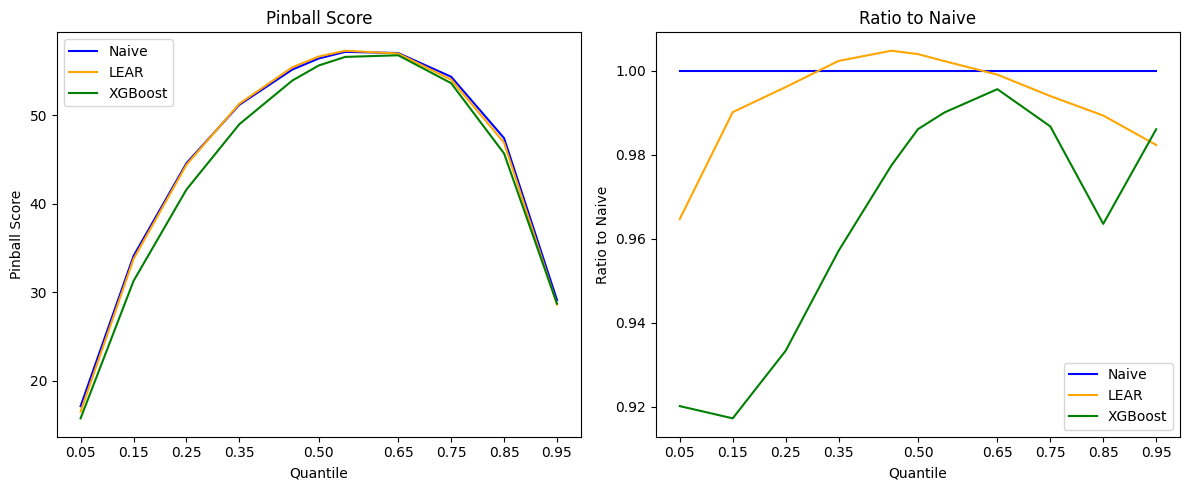

In [ ]:
filename = 'Results/Plots/Pinball scores'

plot_pinball_scores(pinball_scores_naive, pinball_scores_lear, pinball_scores_xgb, save=False, filename=filename)

Coverage

## Nside Analysis

### Load in forecasts

2022 last three months

In [ ]:
# Define the intraday price and the forecasts
imbalance_prices = y_test
true_surplus_price = imbalance_prices.groupby(imbalance_prices.index).min()[test_start:test_end]
intraday_prices = df['3to1_price'][test_start:test_end]

# Load in rolling Naive predictions and average duplicates
naive_pred = np.load('Results/Naive/naive_quantile_predictions_20220901-20230101_test.npy')
naive_forecasts = pd.DataFrame(naive_pred, index=y_test.index, columns=quantiles).groupby(y_test.index).mean()

# Load in rolling LEAR predictions and average duplicates
rolling_pred_quantiles_LEAR = np.load('Results/LEAR/LEAR_quantile_predictions_20220901-20230101_test.npy')
LEAR_forecasts = pd.DataFrame(rolling_pred_quantiles_LEAR, index=y_test.index, columns=quantiles).groupby(y_test.index).mean()

# Load in XGB predictions and average duplicates
rolling_pred_quantiles_XGB = np.load('Results/XGB/XGB_static_predictions_20220901-20230101_test.npy')
XGB_forecasts = pd.DataFrame(rolling_pred_quantiles_XGB, index=y_test.index, columns=quantiles).groupby(y_test.index).mean()
# XGB_forecasts = pd.DataFrame(y_pred_test_XGB_quantiles, index=y_test.index, columns=quantiles).groupby(y_test.index).mean()

# Load in Nside predictions
Nside_forecasts = pd.read_csv('Nside Forecasts/Preprocessed NSide Forecasts.csv', parse_dates=['start_datetime'])
Nside_forecasts.set_index('start_datetime', inplace=True)
Nside_forecasts_shortage = Nside_forecasts['ForeNeg'][test_start:test_end]
Nside_forecasts_surplus = Nside_forecasts['ForePos'][test_start:test_end]

2023

In [ ]:
test_start_2023 = '2023-01-01 00:00:00'
test_end_2023 = '2023-12-31 22:45:00'

# Define the intraday price and the forecasts
imbalance_prices = y[test_start_2023:test_end_2023]
true_surplus_price = imbalance_prices.groupby(imbalance_prices.index).min()[test_start_2023:test_end_2023]
intraday_prices = df['3to1_price'][test_start_2023:test_end_2023]

# Load in rolling Naive predictions and average duplicates
# naive_pred = df['3to1_price'][test_start_2023:test_end_2023]
# naive_forecasts = pd.DataFrame(naive_pred, index=y[test_start_2023:test_end_2023].index, columns=[0.5]).groupby(y[test_start_2023:test_end_2023].index).mean()
naive_pred = np.load('Results/Naive/naive_quantile_predictions_2023-2024_test.npy')
naive_forecasts = pd.DataFrame(naive_pred, index=y[test_start_2023:test_end_2023].index, columns=quantiles).groupby(y[test_start_2023:test_end_2023].index).mean()

# Load in rolling LEAR predictions and average duplicates
# rolling_pred_quantiles_LEAR = np.load('Results/LEAR/LEAR_predictions_2023-2024_test.npy')
# LEAR_forecasts = pd.DataFrame(rolling_pred_quantiles_LEAR, index=y[test_start_2023:test_end_2023].index, columns=[0.5]).groupby(y[test_start_2023:test_end_2023].index).mean()

rolling_pred_quantiles_LEAR = np.load('Results/LEAR/LEAR_quantile_predictions_2023-2024_test.npy')
LEAR_forecasts = pd.DataFrame(rolling_pred_quantiles_LEAR, index=y[test_start_2023:test_end_2023].index, columns=quantiles).groupby(y[test_start_2023:test_end_2023].index).mean()

# Load in XGB predictions and average duplicates
# rolling_pred_quantiles_XGB = np.load('Results/XGB/XGB_quantile_predictions_20220901-20230101_test.npy')
# XGB_forecasts = pd.DataFrame(rolling_pred_quantiles_XGB, index=y[test_start_2023:test_end_2023].index, columns=quantiles).groupby(y[test_start_2023:test_end_2023].index).mean()
# XGB_forecasts = pd.DataFrame(y_pred_test_XGB_quantiles, index=y[test_start_2023:test_end_2023].index, columns=quantiles).groupby(y[test_start_2023:test_end_2023].index).mean()

# Load in Nside predictions
Nside_forecasts = pd.read_csv('Nside Forecasts/Preprocessed NSide Forecasts.csv', parse_dates=['start_datetime'])
Nside_forecasts.set_index('start_datetime', inplace=True)
Nside_forecasts_shortage = Nside_forecasts['ForeNeg'].shift(-4)[test_start_2023:test_end_2023][true_surplus_price.index]
Nside_forecasts_surplus = Nside_forecasts['ForePos'].shift(-4)[test_start_2023:test_end_2023][true_surplus_price.index]

### Large errors

In [ ]:
forecasts_list = [naive_forecasts, LEAR_forecasts, XGB_forecasts]
errors = []
forecast_names = ['Naive Forecast', 'LEAR Forecast', 'XGB Forecast']

for forecast in forecasts_list:
  errors.append(true_surplus_price - forecast[0.5])

In [ ]:
naive_forecasts = pd.DataFrame(naive_pred, index=y[test_start_2023:test_end_2023].index, columns=quantiles)
print_mean_metrics(y[test_start_2023:test_end_2023], naive_forecasts[0.5])

MAE: 78.21288146946794, RMSE: 187.01222254608936, sMAPE: 73.62734848972597


In [ ]:
LEAR_forecasts = pd.DataFrame(rolling_pred_quantiles_LEAR, index=y[test_start_2023:test_end_2023].index, columns=quantiles)
print_mean_metrics(y[test_start_2023:test_end_2023], LEAR_forecasts[0.5])

MAE: 77.94325345446693, RMSE: 181.52981381998333, sMAPE: 74.31002153484376


In [ ]:
print_mean_metrics(y[test_start_2023:test_end_2023], duplicate_X(df['3to1_price'].shift(-4), duplicated_indices)[test_start_2023:test_end_2023])

MAE: 76.91925579381297, RMSE: 179.71434880848938, sMAPE: 70.43918243397701


### Nside vs LEAR

In [ ]:
Nside_minute_forecasts = pd.read_csv('Nside Forecasts/Preprocessed NSide Forecasts per minute.csv', parse_dates=['start_datetime'])
Nside_minute_forecasts.set_index('start_datetime', inplace=True)

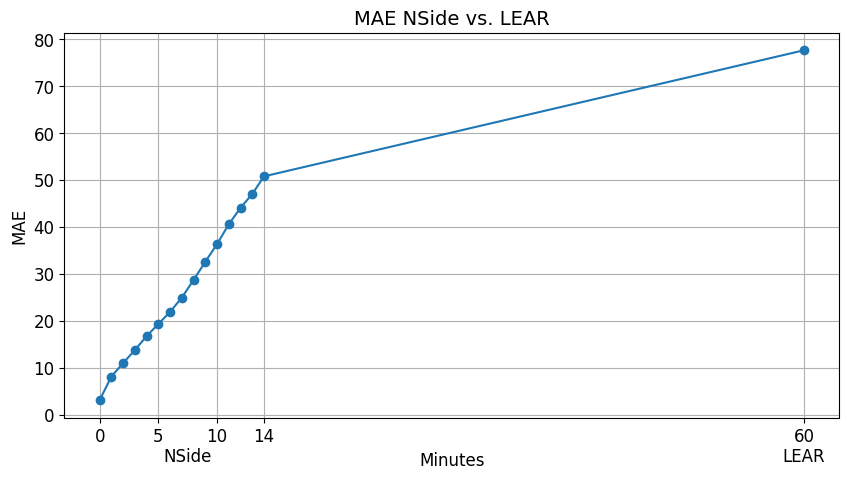

In [ ]:
# Initialize a list to store mean absolute error (MAE) values
mae_values = []

# Loop over the first 15 minutes to calculate MAE for each forecast
for minute in range(14, -1, -1):
    # Shift the forecast data to align with the true surplus price
    forecast_shifted = Nside_minute_forecasts[f'minute_{minute}_Pos'].shift(-4)[test_start_2023:test_end_2023]
    # Compute MAE, excluding NaN values
    mae = mean_absolute_error(
        true_surplus_price[forecast_shifted.notna()],
        forecast_shifted[true_surplus_price.index][forecast_shifted.notna()]
    )
    mae_values.append(mae)

# Compute MAE for the LEAR forecast
mae_lear = mean_absolute_error(
    true_surplus_price[forecast_shifted.notna()],
    LEAR_forecasts[0.5][true_surplus_price.index][forecast_shifted.notna()]
)
mae_values.append(mae_lear)

# Define x-axis labels, with the last one labeled as 'LEAR'
x_labels = list(range(len(mae_values) - 1)) + ['LEAR']

# Define x positions, placing 'LEAR' at 60
x_positions = list(range(len(mae_values) - 1)) + [60]

# Define specific x positions and corresponding labels to display
specific_x_positions = [0, 5, 10, 14, 60]
specific_x_labels = ['0', '5', '10', '14', '60']

# Plot the MAE values with the specified x positions
plt.figure(figsize=(10, 5))
plt.plot(x_positions, mae_values, marker='o')

# Set x-ticks to specific positions and labels
plt.xticks(specific_x_positions, specific_x_labels, fontsize=12)
plt.yticks(fontsize=12)

# Add the 'NSide' label between the 5 and 10 minute markers
middle_point = (5 + 10) / 2
plt.text(middle_point, -7, 'NSide', fontsize=12, ha='center', va='top')

# Add the 'LEAR' label below the 60 minute marker
plt.text(60, -7, 'LEAR', fontsize=12, ha='center', va='top')

# Set the x and y axis labels and the title
plt.xlabel('Minutes', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.title('MAE NSide vs. LEAR', fontsize=14)

# Optional: Add grid for better readability
plt.grid(True)

plt.savefig('Results/Plots/NSide LEAR Comparison')

# Display the plot
plt.show()

# Trading

## Load in Forecasts

2022 last three months

In [ ]:
period = 'Sept Dec 2022'

# Define the intraday price and the forecasts
imbalance_prices = y_test
true_surplus_price = imbalance_prices.groupby(imbalance_prices.index).min()[test_start:test_end]
intraday_prices = df['3to1_price'][test_start:test_end]

# Load in rolling Naive predictions and average duplicates
naive_pred = np.load('Results/Naive/naive_quantile_predictions_20220901-20230101_test.npy')
naive_forecasts = pd.DataFrame(naive_pred, index=y_test.index, columns=quantiles).groupby(y_test.index).mean()

# Load in rolling LEAR predictions and average duplicates
rolling_pred_quantiles_LEAR = np.load('Results/LEAR/LEAR_quantile_predictions_20220901-20230101_test.npy')
LEAR_forecasts = pd.DataFrame(rolling_pred_quantiles_LEAR, index=y_test.index, columns=quantiles).groupby(y_test.index).mean()

# Load in XGB predictions and average duplicates
rolling_pred_quantiles_XGB = np.load('Results/XGB/XGB_static_predictions_20220901-20230101_test.npy')
XGB_forecasts = pd.DataFrame(rolling_pred_quantiles_XGB, index=y_test.index, columns=quantiles).groupby(y_test.index).mean()
# XGB_forecasts = pd.DataFrame(y_pred_test_XGB_quantiles, index=y_test.index, columns=quantiles).groupby(y_test.index).mean()

# Load in Nside predictions
Nside_forecasts = pd.read_csv('Nside Forecasts/Preprocessed NSide Forecasts.csv', parse_dates=['start_datetime'])
Nside_forecasts.set_index('start_datetime', inplace=True)
Nside_forecasts_shortage = Nside_forecasts['ForeNeg'][test_start:test_end].shift(-4)
Nside_forecasts_surplus = Nside_forecasts['ForePos'][test_start:test_end].shift(-4)

2023

In [ ]:
test_start_2023 = '2023-01-01 00:00:00'
test_end_2023 = '2023-12-31 22:45:00'
period = '2023'

# Define the intraday price and the forecasts
imbalance_prices = y[test_start_2023:test_end_2023]
true_surplus_price = imbalance_prices.groupby(imbalance_prices.index).min()[test_start_2023:test_end_2023]
intraday_prices = df['3to1_price'][test_start_2023:test_end_2023]

# Load in rolling Naive predictions and average duplicates
# naive_pred = df['3to1_price'][test_start_2023:test_end_2023]
# naive_forecasts = pd.DataFrame(naive_pred, index=y[test_start_2023:test_end_2023].index, columns=[0.5]).groupby(y[test_start_2023:test_end_2023].index).mean()
naive_pred = np.load('Results/Naive/naive_quantile_predictions_2023-2024_test.npy')
naive_forecasts = pd.DataFrame(naive_pred, index=y[test_start_2023:test_end_2023].index, columns=quantiles).groupby(y[test_start_2023:test_end_2023].index).mean()

# Load in rolling LEAR predictions and average duplicates
# rolling_pred_quantiles_LEAR = np.load('Results/LEAR/LEAR_predictions_2023-2024_test.npy')
# LEAR_forecasts = pd.DataFrame(rolling_pred_quantiles_LEAR, index=y[test_start_2023:test_end_2023].index, columns=[0.5]).groupby(y[test_start_2023:test_end_2023].index).mean()

rolling_pred_quantiles_LEAR = np.load('Results/LEAR/LEAR_quantile_predictions_2023-2024_test.npy')
LEAR_forecasts = pd.DataFrame(rolling_pred_quantiles_LEAR, index=y[test_start_2023:test_end_2023].index, columns=quantiles).groupby(y[test_start_2023:test_end_2023].index).mean()

# Load in XGB predictions and average duplicates
# rolling_pred_quantiles_XGB = np.load('Results/XGB/XGB_quantile_predictions_20220901-20230101_test.npy')
# XGB_forecasts = pd.DataFrame(rolling_pred_quantiles_XGB, index=y[test_start_2023:test_end_2023].index, columns=quantiles).groupby(y[test_start_2023:test_end_2023].index).mean()
# XGB_forecasts = pd.DataFrame(y_pred_test_XGB_quantiles, index=y[test_start_2023:test_end_2023].index, columns=quantiles).groupby(y[test_start_2023:test_end_2023].index).mean()

# Load in Nside predictions
Nside_forecasts = pd.read_csv('Nside Forecasts/Preprocessed NSide Forecasts.csv', parse_dates=['start_datetime'])
Nside_forecasts.set_index('start_datetime', inplace=True)
Nside_forecasts_shortage = Nside_forecasts['ForeNeg'].shift(-4)[test_start_2023:test_end_2023][true_surplus_price.index]
Nside_forecasts_surplus = Nside_forecasts['ForePos'].shift(-4)[test_start_2023:test_end_2023][true_surplus_price.index]

## Strategies

In [ ]:
def baseline_strategies(imbalance_prices, intraday_prices):
    revenue_base_1 = intraday_prices.mean()
    revenue_base_2 = 0.5*intraday_prices.mean() + 0.5*imbalance_prices.clip.mean()  # Must be modified for Regulation state 2
    revenue_base_3 = imbalance_prices.mean()  # Must be modified

    return [revenue_base_1, revenue_base_2, revenue_base_3]

In [ ]:
def baseline_strategies(imbalance_prices, intraday_prices):
    revenue_base_1 = intraday_prices.clip(lower=0).mean()
    revenue_base_2 = 0.5*intraday_prices.clip(lower=0).mean() + 0.5*imbalance_prices.clip(lower=0).mean()  # Must be modified for Regulation state 2
    revenue_base_3 = imbalance_prices.clip(lower=0).mean()  # Must be modified

    return [revenue_base_1, revenue_base_2, revenue_base_3]

In [ ]:
def perfect_hindsight_strategy(imbalance_prices, intraday_prices):
    '''
    In perfect hindsight. Invest in the imbalance market if higher than the intraday price.
    This presents the best case scenario.
    '''
    # Create a mask that tracks what price is higher
    mask = imbalance_prices > intraday_prices

    # Calculate the ratio of the participation into the imbalance market
    imbalance_participation_ratio = mask.mean()

    # Use the mask to select values from imbalance_prices and intraday_prices
    revenue = pd.Series(index=imbalance_prices.index)
    revenue[mask] = imbalance_prices[mask]
    revenue[~mask] = intraday_prices[~mask]

    # Calculate the percentage of revenue made in the imbalance market
    imbalance_revenue_ratio = revenue[mask].sum()/revenue.sum()

    return revenue.mean(), imbalance_participation_ratio, imbalance_revenue_ratio

In [ ]:
def strategy_1(imbalance_prices, intraday_prices, forecasts):
    '''
    Invest everything into the imbalance market if the forecast is greater than the intraday price.
    Otherwise, invest everything into the intraday market.
    '''

    # Create a boolean mask where forecasts are greater than intraday_prices
    mask_forecast = forecasts > intraday_prices

    mask_true = imbalance_prices > intraday_prices

    correct_prediction = (mask_forecast & mask_true) | (~mask_forecast & ~mask_true)

    # Calculate the ratio of the participation into the imbalance market
    imbalance_participation_ratio = mask_forecast.mean()

    # Use the mask to select values from imbalance_prices and intraday_prices
    revenue = pd.Series(index=forecasts.index)
    revenue[mask_forecast] = imbalance_prices[mask_forecast]
    revenue[~mask_forecast] = intraday_prices[~mask_forecast]

    # Calculate the percentage of revenue made in the imbalance market
    imbalance_revenue_ratio = revenue[mask_forecast].sum()/revenue.sum()

    return revenue.mean(), imbalance_participation_ratio, correct_prediction.mean(), imbalance_revenue_ratio, mask_forecast

In [ ]:
def strategy_1_curtailment(imbalance_prices, intraday_prices, forecasts):
    '''
    Invest everything into the imbalance market if the forecast is greater than the intraday price.
    Otherwise, invest everything into the intraday market.
    '''

    # Create a boolean mask where forecasts are greater than intraday_prices
    mask_forecast = forecasts > intraday_prices

    mask_true = imbalance_prices > intraday_prices

    correct_prediction = (mask_forecast & mask_true) | (~mask_forecast & ~mask_true)

    # Calculate the ratio of the participation into the imbalance market
    imbalance_participation_ratio = mask_forecast.mean()

    # Use the mask to select values from imbalance_prices and intraday_prices
    revenue = pd.Series(index=forecasts.index)
    revenue[mask_forecast] = imbalance_prices[mask_forecast]
    revenue[~mask_forecast] = intraday_prices[~mask_forecast]

    # Calculate revenue with curtailment
    revenue_curtailment = revenue.copy()
    revenue_curtailment[mask_forecast] = imbalance_prices[mask_forecast].clip(lower=0)


    # Calculate the percentage of revenue made in the imbalance market
    imbalance_revenue_ratio = revenue[mask_forecast].sum()/revenue.sum()

    return revenue.mean(), imbalance_participation_ratio, correct_prediction.mean(), imbalance_revenue_ratio, mask_forecast, revenue_curtailment.mean()

In [ ]:
def strategy_2(imbalance_prices, intraday_prices, forecasts):
    '''
    Invest into the imbalance market based on the probability of it being lower than the intraday price.
    Invest the rest into the intraday market.
    '''
    # Compute the absolute differences between the forecasted quantiles and the intraday price
    differences = forecasts.subtract(intraday_prices, axis=0).abs()

    # Find the index of the minimum difference for each row
    # This correspond to the quantile closest to the intraday price
    closest_forecast_indices = np.argmin(differences, axis=1)

    # Map these indices to the column names of forecasts
    probabilities = pd.Series(forecasts.columns[closest_forecast_indices], index=forecasts.index)

    # Create a boolean mask where forecasts are greater than intraday_prices
    mask_prob = probabilities < 0.5

    mask_true = imbalance_prices > intraday_prices

    correct_predictions = (mask_prob & mask_true) | (~mask_prob & ~mask_true)

    # Calculate the ratio of the participation into the imbalance market
    imbalance_participation_ratio = probabilities.mean()

    # Use the mask to select values from imbalance_prices and intraday_prices
    # revenue = pd.Series(index=forecasts.index)
    revenue = intraday_prices * probabilities + imbalance_prices * (1 - probabilities)

    # Calculate the percentage of revenue made in the imbalance market
    imbalance_revenue_ratio = (imbalance_prices * (1 - probabilities)).sum()/revenue.sum()

    return revenue.mean(), imbalance_participation_ratio, correct_predictions.mean(), imbalance_revenue_ratio

In [ ]:
def strategy_3(imbalance_prices, intraday_prices, forecasts):
    '''
    Invest into the imbalance market based on the probability of it being lower than the intraday price.
    Invest the rest into the intraday market.
    When the probability is above 0.75 or below 0.25. Go all out
    '''
    # Compute the absolute differences between the forecasted quantiles and the intraday price
    differences = forecasts.subtract(intraday_prices, axis=0).abs()

    # Find the index of the minimum difference for each row
    # This correspond to the quantile closest to the intraday price
    closest_forecast_indices = np.argmin(differences, axis=1)

    # Map these indices to the column names of forecasts
    probabilities = pd.Series(forecasts.columns[closest_forecast_indices], index=forecasts.index)

    # Cap and floor probabilities
    probabilities.loc[probabilities < 0.4] = 0
    probabilities.loc[probabilities > 0.6] = 1

    # Create a boolean mask where forecasts are greater than intraday_prices
    mask_prob = probabilities < 0.5

    mask_true = imbalance_prices > intraday_prices

    correct_predictions = (mask_prob & mask_true) | (~mask_prob & ~mask_true)

    # Calculate the ratio of the participation into the imbalance market
    imbalance_participation_ratio = probabilities.mean()

    # Use the mask to select values from imbalance_prices and intraday_prices
    # revenue = pd.Series(index=forecasts.index)
    revenue = intraday_prices * probabilities + imbalance_prices * (1 - probabilities)

    # Calculate the percentage of revenue made in the imbalance market
    imbalance_revenue_ratio = (imbalance_prices * (1 - probabilities)).sum()/revenue.sum()

    return revenue.mean(), imbalance_participation_ratio, correct_predictions.mean(), imbalance_revenue_ratio

## Trade

In [ ]:
def print_trade_metrics(revenue, imbalance_participation, imbalance_revenue_ratio, correct_predictions=None, revenue_curtail=None):
  print(f'Revenue: {revenue}')
  if revenue_curtail is not None:
    print(f'Revenue with Curtailment: {revenue_curtail}%')
  print(f'Revenue Percentage Increase: {100*(revenue/baseline_revenues[0] - 1):.2f}%')
  print(f'Imbalance Participation Ratio: {100*imbalance_participation:.2f}%')
  print(f'Imbalance Revenue Ratio: {100*imbalance_revenue_ratio:.2f}%')
  if correct_predictions is not None:
    print(f'Correct Predictions Ratio: {100*correct_predictions:.2f}%')

In [ ]:
baseline_revenues = baseline_strategies(true_surplus_price, intraday_prices)
label = ['Only Intraday', '50-50', 'Only Imbalance']

metrics = {}
print('Revenue')
for i, revenue in enumerate(baseline_revenues):
  print(f'{label[i]}: {revenue}')
  metrics[label[i]] = revenue

Revenue
Only Intraday: 96.62048103789898
50-50: 101.85902371872052
Only Imbalance: 107.09756639954206


In [ ]:
baseline_revenues = baseline_strategies(true_surplus_price, intraday_prices)
label = ['Only Intraday', '50-50', 'Only Imbalance']

metrics = {}
print('Revenue')
for i, revenue in enumerate(baseline_revenues):
  print(f'{label[i]}: {revenue}')
  metrics[label[i]] = revenue

Revenue
Only Intraday: 99.07911805550508
50-50: 103.08834222752357
Only Imbalance: 107.09756639954206


In [ ]:
intraday_prices.describe()

count   34940.000
mean       96.620
std        64.948
min      -601.120
25%        70.205
50%        98.893
75%       126.960
max      1596.357
Name: 3to1_price, dtype: float64

In [ ]:
revenue_perfect, imbalance_participation, imbalance_revenue_ratio = perfect_hindsight_strategy(true_surplus_price, intraday_prices)
revenue_increase = (revenue_perfect/baseline_revenues[0] - 1)

print('Perfect Predictions:')
print()
print_trade_metrics(revenue_perfect, imbalance_participation, imbalance_revenue_ratio)
metrics['Perfect Predictions'] = {'Revenue': revenue_perfect, 'Revenue Increase': revenue_increase, 'Imbalance Participation': imbalance_participation, 'Correct Predictions': 1, 'Imbalance Revenue Ratio': imbalance_revenue_ratio}

Perfect Predictions:

Revenue: 136.32431636158742
Revenue Percentage Increase: 41.09%
Imbalance Participation Ratio: 35.20%
Imbalance Revenue Ratio: 49.42%


In [ ]:
if period == 'Sept Dec 2022':
  forecasts_list = [naive_forecasts, LEAR_forecasts, XGB_forecasts]
  labels = ['Naive', 'LEAR', 'XGBoost']
else:
  forecasts_list = [naive_forecasts, LEAR_forecasts]
  labels = ['Naive', 'LEAR']

strategy = 'Strategy 1'

print(f'Point Forecasts ({strategy}):')
print()
for i, forecasts in enumerate(forecasts_list):
  revenue, imbalance_participation, correct_predictions, imbalance_revenue_ratio, mask_forecast = strategy_1(true_surplus_price, intraday_prices, forecasts[0.5])
  revenue_increase = (revenue/baseline_revenues[0] - 1)
  metrics[f'{labels[i]} {strategy}'] = {'Revenue': revenue, 'Revenue Increase': revenue_increase, 'Imbalance Participation': imbalance_participation, 'Correct Predictions': correct_predictions, 'Imbalance Revenue Ratio': imbalance_revenue_ratio}
  print(f'{labels[i]}:')
  print_trade_metrics(revenue, imbalance_participation, imbalance_revenue_ratio, correct_predictions)
  print()

revenue, imbalance_participation, correct_predictions, imbalance_revenue_ratio, mask_forecast = strategy_1(true_surplus_price, intraday_prices, Nside_forecasts_surplus)
print('Nside 15 minute ahead:')
revenue_increase = (revenue/baseline_revenues[0] - 1)
metrics['Nside'] =  {'Revenue': revenue, 'Revenue Increase': revenue_increase, 'Imbalance Participation': imbalance_participation, 'Correct Predictions': correct_predictions, 'Imbalance Revenue Ratio': imbalance_revenue_ratio}
print_trade_metrics(revenue, imbalance_participation, imbalance_revenue_ratio, correct_predictions)

Point Forecasts (Strategy 1):

Naive:
Revenue: 100.47857968614238
Revenue Percentage Increase: 3.99%
Imbalance Participation Ratio: 23.70%
Imbalance Revenue Ratio: 20.69%
Correct Predictions Ratio: 63.86%

LEAR:
Revenue: 109.72430372248655
Revenue Percentage Increase: 13.56%
Imbalance Participation Ratio: 37.47%
Imbalance Revenue Ratio: 39.29%
Correct Predictions Ratio: 64.80%

Nside 15 minute ahead:
Revenue: 128.10220700230113
Revenue Percentage Increase: 32.58%
Imbalance Participation Ratio: 37.14%
Imbalance Revenue Ratio: 47.59%
Correct Predictions Ratio: 82.32%


In [ ]:
if period == 'Sept Dec 2022':
  forecasts_list = [naive_forecasts, LEAR_forecasts, XGB_forecasts]
  labels = ['Naive', 'LEAR', 'XGBoost']
else:
  forecasts_list = [naive_forecasts, LEAR_forecasts]
  labels = ['Naive', 'LEAR']

strategy = 'Strategy 1'

print(f'Point Forecasts ({strategy}):')
print()
for i, forecasts in enumerate(forecasts_list):
  revenue, imbalance_participation, correct_predictions, imbalance_revenue_ratio, mask_forecast, revenue_curtailment = strategy_1_curtailment(true_surplus_price, intraday_prices, forecasts[0.5])
  revenue_increase = (revenue/baseline_revenues[0] - 1)
  metrics[f'{labels[i]} {strategy}'] = {'Revenue': revenue, 'Revenue Increase': revenue_increase, 'Imbalance Participation': imbalance_participation, 'Correct Predictions': correct_predictions, 'Imbalance Revenue Ratio': imbalance_revenue_ratio}
  print(f'{labels[i]}:')
  print_trade_metrics(revenue, imbalance_participation, imbalance_revenue_ratio, correct_predictions, revenue_curtail = revenue_curtailment)
  print()

revenue, imbalance_participation, correct_predictions, imbalance_revenue_ratio, mask_forecast, revenue_curtailment = strategy_1_curtailment(true_surplus_price, intraday_prices, Nside_forecasts_surplus)
print('Nside 15 minute ahead:')
revenue_increase = (revenue/baseline_revenues[0] - 1)
metrics['Nside'] =  {'Revenue': revenue, 'Revenue Increase': revenue_increase, 'Imbalance Participation': imbalance_participation, 'Correct Predictions': correct_predictions, 'Imbalance Revenue Ratio': imbalance_revenue_ratio}
print_trade_metrics(revenue, imbalance_participation, imbalance_revenue_ratio, correct_predictions, revenue_curtail = revenue_curtailment)

Point Forecasts (Strategy 1):

Naive:
Revenue: 100.47857968614238
Revenue with Curtailment: 104.8525459139615%
Revenue Percentage Increase: 3.99%
Imbalance Participation Ratio: 23.70%
Imbalance Revenue Ratio: 20.69%
Correct Predictions Ratio: 63.86%

LEAR:
Revenue: 109.72430372248655
Revenue with Curtailment: 113.36311883410647%
Revenue Percentage Increase: 13.56%
Imbalance Participation Ratio: 37.47%
Imbalance Revenue Ratio: 39.29%
Correct Predictions Ratio: 64.80%

Nside 15 minute ahead:
Revenue: 128.10220700230113
Revenue with Curtailment: 129.79341736291937%
Revenue Percentage Increase: 32.58%
Imbalance Participation Ratio: 37.14%
Imbalance Revenue Ratio: 47.59%
Correct Predictions Ratio: 82.32%


In [ ]:
if period == 'Sept Dec 2022':
  forecasts_list = [naive_forecasts, LEAR_forecasts, XGB_forecasts]
  labels = ['Naive', 'LEAR', 'XGBoost']
else:
  forecasts_list = [naive_forecasts, LEAR_forecasts]
  labels = ['Naive', 'LEAR']

strategy = 'Strategy 2'

print(f'Probabilistic Forecasts ({strategy}):')
print()
for i, forecasts in enumerate(forecasts_list):
  revenue, imbalance_participation, correct_predictions, imbalance_revenue_ratio = strategy_2(true_surplus_price, intraday_prices, forecasts)
  revenue_increase = (revenue/baseline_revenues[0] - 1)
  metrics[f'{labels[i]} {strategy}'] = {'Revenue': revenue, 'Revenue Increase': revenue_increase, 'Imbalance Participation': imbalance_participation, 'Correct Predictions': correct_predictions, 'Imbalance Revenue Ratio': imbalance_revenue_ratio}
  print(f'{labels[i]}:')
  print_trade_metrics(revenue, imbalance_participation, imbalance_revenue_ratio, correct_predictions)
  print()

Probabilistic Forecasts (Strategy 2):

Naive:
Revenue: 96.73750672300798
Revenue Percentage Increase: 0.12%
Imbalance Participation Ratio: 58.93%
Imbalance Revenue Ratio: 38.83%
Correct Predictions Ratio: 64.48%

LEAR:
Revenue: 102.83522002046394
Revenue Percentage Increase: 6.43%
Imbalance Participation Ratio: 55.40%
Imbalance Revenue Ratio: 44.65%
Correct Predictions Ratio: 65.59%



In [ ]:
# forecasts_list = [naive_forecasts, LEAR_forecasts]
# labels = ['Naive', 'LEAR']
# print('Probabilistic Forecasts capped/floored (Strategy 3):')
# print()
# for i, forecasts in enumerate(forecasts_list):
#   revenue, imbalance_participation, correct_predictions, imbalance_revenue_ratio = strategy_3(true_surplus_price, intraday_prices, forecasts)
#   print(f'{labels[i]}:')
#   print(f'Revenue: {revenue}')
#   print(f'Imbalance Participation Ratio: {imbalance_participation}')
#   print(f'Imbalance Revenue Ratio: {imbalance_revenue_ratio}')
#   print(f'Correct Predictions Ratio: {correct_predictions}')
#   print()

## Trade Analysis

### Functions

In [ ]:
def plot_trade_metrics(metrics, selected_keys, metric_key='Revenue', save=False, filename=None):
    """
    Plots trade metrics from a dictionary, allowing selection of specific metrics.
    Values are formatted as percentages if they are not 'Revenue'.

    Parameters:
    - metrics (dict): Dictionary containing metrics data.
    - selected_keys (list): List of keys to include in the plot, in desired order.
    - metric_key (str): The key in nested dictionaries where revenue is stored. Default is 'Revenue'.
    - save (bool): Whether to save the plot to a file.
    - filename (str): Filename to save the plot.
    """
    labels = []
    values = []
    value_formats = []

    for key in selected_keys:
        value = metrics.get(key, 0)
        if isinstance(value, dict):
            # Extract revenue or other metrics based on the provided metric_key
            metric_value = value.get(metric_key, 0)
            # Check if the key is not 'Revenue' and format as percentage if needed
            if metric_key != 'Revenue':
                value_formats.append('{:.1%}'.format(metric_value))
                metric_value *= 100  # Convert to percentage
            else:
                value_formats.append('{:.2f}'.format(metric_value))
        else:
            # Assume value is the revenue if it's not a dictionary
            metric_value = value
            value_formats.append('{:.2f}'.format(metric_value))

        labels.append(key)
        values.append(metric_value)

    # Define softer colors for the bars
    colors = ['#aec6cf', '#ffb347', '#77dd77', '#ff6961', '#cfcfcf', '#c1b6e5', '#b1d1d0', '#f4a89c', '#b8c6a8', '#ffc8a1']

    # Plotting the bar chart
    plt.figure(figsize=(12, 6))
    bars = plt.bar(labels, values, color=colors[:len(labels)])  # Adjust colors based on number of bars

    # Add title and labels
    plt.title(f'{metric_key}', fontsize=16)
    plt.ylabel('Value', fontsize=14)

    # Add value labels on top of the bars
    for bar, value_format in zip(bars, value_formats):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., height,
                 value_format, ha='center', va='bottom', fontsize=12)

    # Set x-axis labels without rotation and alignment
    plt.xticks(fontsize=12)

    # Optional: Add grid lines for y-axis
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show or save the plot
    plt.tight_layout()

    if save and filename:
        plt.savefig(f'{filename}.png')
    plt.show()

In [ ]:
def plot_multiple_trade_metrics(metrics, selected_keys, metric_keys, save=False, filename=None):
    """
    Plots trade metrics from a dictionary, allowing selection of specific metrics.
    Values are formatted as percentages if they are not 'Revenue'.

    Parameters:
    - metrics (dict): Dictionary containing metrics data.
    - selected_keys (list): List of keys to include in the plot, in desired order.
    - metric_keys (list): List of metric keys to plot. Can include 'Revenue' and other keys.
    - save (bool): Whether to save the plot to a file.
    - filename (str): Filename to save the plot.
    """
    # Define softer colors for the bars
    colors = ['#aec6cf', '#ffb347', '#77dd77', '#ff6961', '#cfcfcf', '#c1b6e5', '#b1d1d0', '#f4a89c', '#b8c6a8', '#ffc8a1']

    # Prepare data for each metric key
    data = {metric_key: [] for metric_key in metric_keys}
    labels = []

    for key in selected_keys:
        value = metrics.get(key, {})
        labels.append(key)
        for metric_key in metric_keys:
            if isinstance(value, dict):
                # Extract metric value, default to 0 if key is not found
                metric_value = value.get(metric_key, 0)
                # Format as percentage if not 'Revenue'
                if metric_key != 'Revenue':
                    metric_value *= 100  # Convert to percentage
                    data[metric_key].append(metric_value)
                else:
                    data[metric_key].append(metric_value)
            else:
                # Assume value is the revenue if it's not a dictionary
                if metric_key == 'Revenue':
                    data[metric_key].append(value)
                else:
                    data[metric_key].append(0)  # Default to 0 for other metrics

    # Plotting the bar chart
    x = np.arange(len(labels))  # the label locations
    width = 0.8 / len(metric_keys)  # the width of the bars

    plt.figure(figsize=(14, 8))

    for i, metric_key in enumerate(metric_keys):
        bars = plt.bar(x + i * width, data[metric_key], width, label=metric_key, color=colors[i % len(colors)])

        # Add value labels on top of the bars
        for bar in bars:
            height = bar.get_height()
            value_format = '{:.1f}%'.format(height) if metric_key != 'Revenue' else '{:.2f}'.format(height)
            plt.text(bar.get_x() + bar.get_width() / 2., height,
                     value_format, ha='center', va='bottom', fontsize=10)

    # Create the title including all metric keys
    metrics_title = ', '.join(metric_keys)
    plt.title(f'Comparison of Ratios ', fontsize=16)
    plt.ylabel('Value', fontsize=14)
    plt.xticks(x + width * (len(metric_keys) - 1) / 2, labels, fontsize=12)
    plt.legend(title='Metrics')

    # Optional: Add grid lines for y-axis
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show or save the plot
    plt.tight_layout()

    if save and filename:
        plt.savefig(f'{filename}.png')
    plt.show()


### Plots

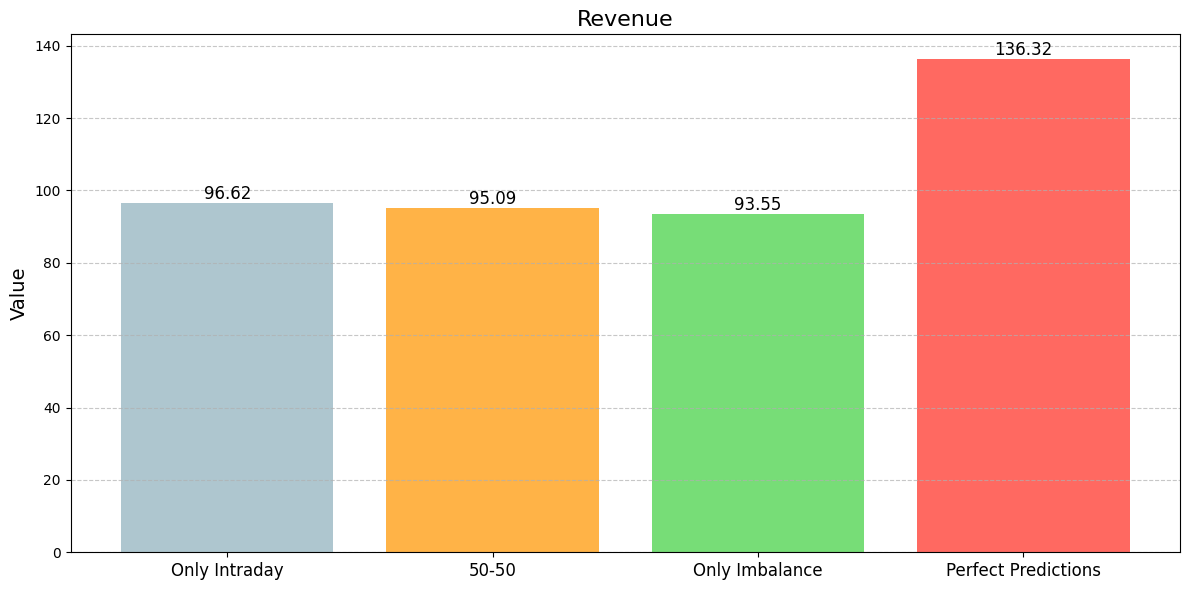

In [ ]:
# Define the list of selected keys you want to include in the plot
selected_keys = [
    'Only Intraday',
    '50-50',
    'Only Imbalance',
    'Perfect Predictions'
]
plot_trade_metrics(metrics, selected_keys, metric_key='Revenue', save=True, filename=f'Results/Plots/Trade Plots/Revenue Comparison Base {period}')

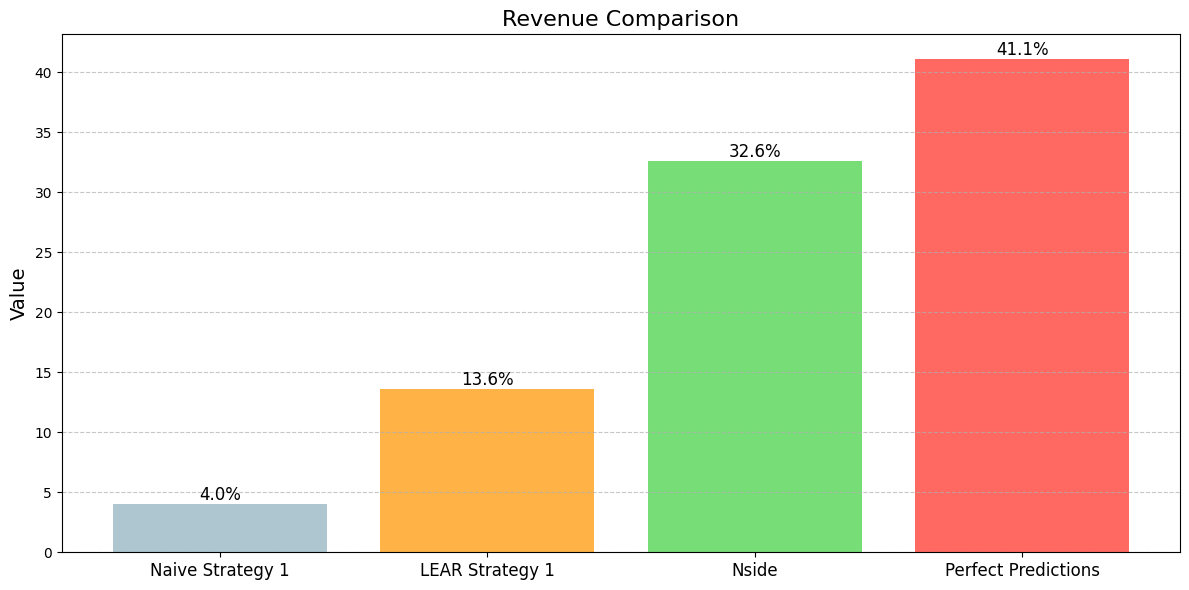

In [ ]:
selected_keys = [
                'Naive Strategy 1',
                 'LEAR Strategy 1',
                #  'XGBoost Strategy 1',
                 'Nside',
                 'Perfect Predictions', ]

plot_trade_metrics(metrics, selected_keys, metric_key='Revenue Increase', save=True, filename=f'Results/Plots/Trade Plots/Revenue Increase Comparison {period}')

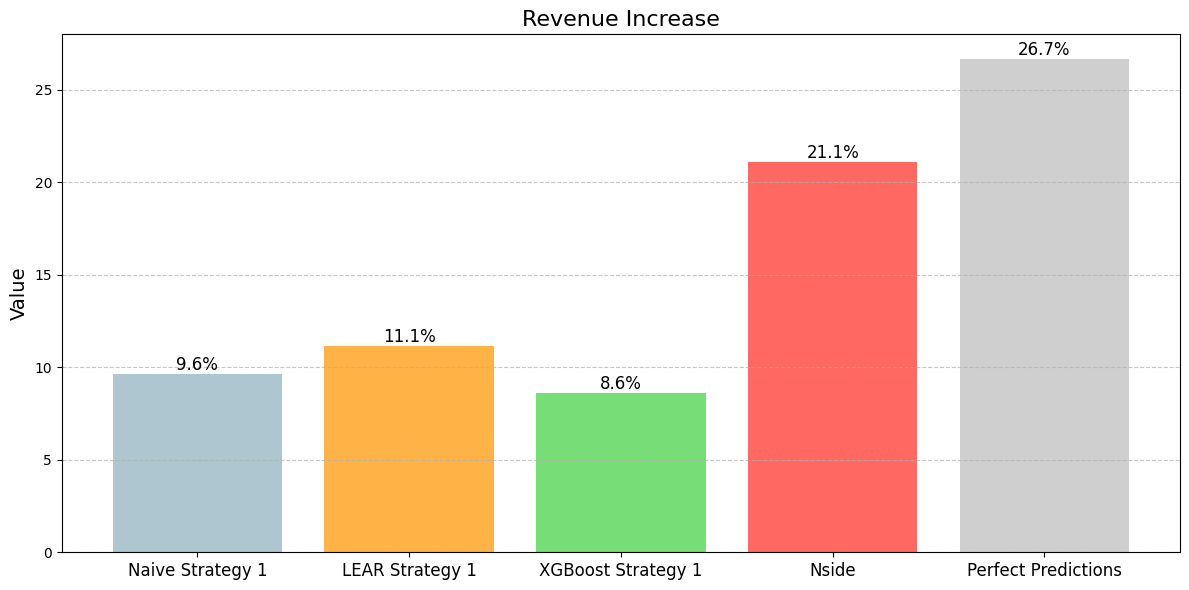

In [ ]:
strategy_1 = 'Strategy 1'
selected_keys = [f'Naive {strategy_1}',
                 f'LEAR {strategy_1}',
                 f'XGBoost {strategy_1}',
                 'Nside',
                 'Perfect Predictions']

plot_trade_metrics(metrics, selected_keys, metric_key='Revenue Increase', save=True, filename=f'Results/Plots/Trade Plots/Revenue Increase Comparison {strategy} {period}')

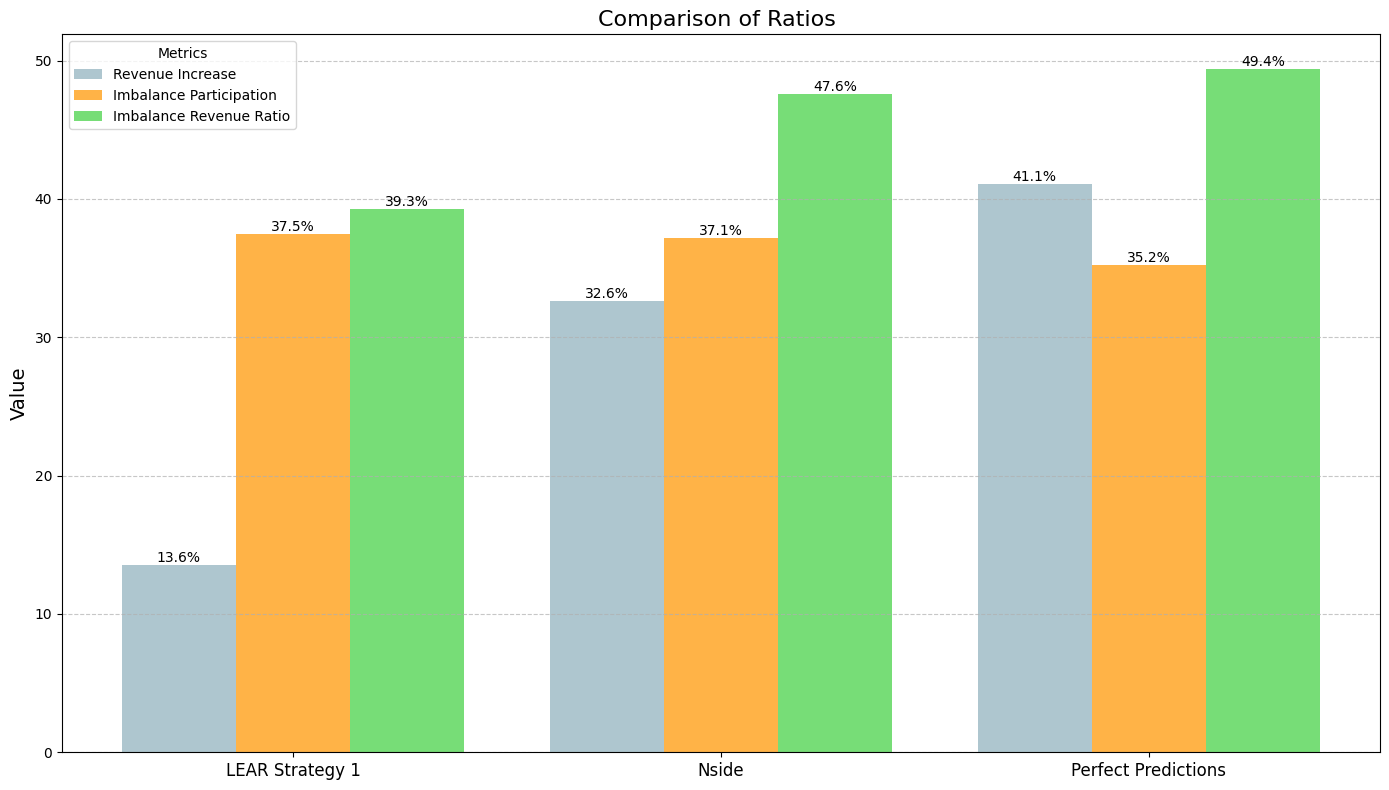

In [ ]:
metric_keys=['Revenue Increase', 'Imbalance Participation', 'Imbalance Revenue Ratio']

selected_keys = [
                'LEAR Strategy 1',
                # 'XGBoost Strategy 1',
                'Nside',
                 'Perfect Predictions'
                 ]

plot_multiple_trade_metrics(metrics, selected_keys, metric_keys=metric_keys, save=True, filename=f'Results/Plots/Trade Plots/Imbalance Participation Comparison {period}')

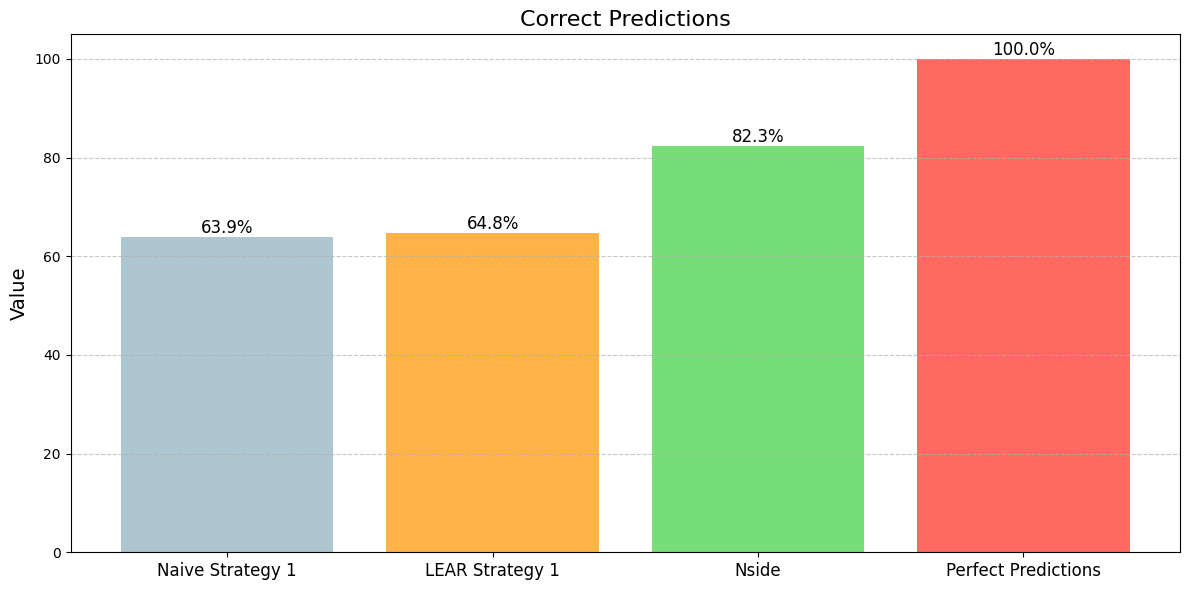

In [ ]:
strategy_1 = 'Strategy 1'
metric_key='Correct Predictions'
# metric_key='Imbalance Participation'
selected_keys = [f'Naive {strategy_1}',
                 f'LEAR {strategy_1}',
                #  f'XGBoost {strategy_1}',
                 'Nside',
                 'Perfect Predictions']

plot_trade_metrics(metrics, selected_keys, metric_key=metric_key, save=False, filename=f'Results/Plots/Trade Plots/{metric_key} Comparison {strategy} {period}')

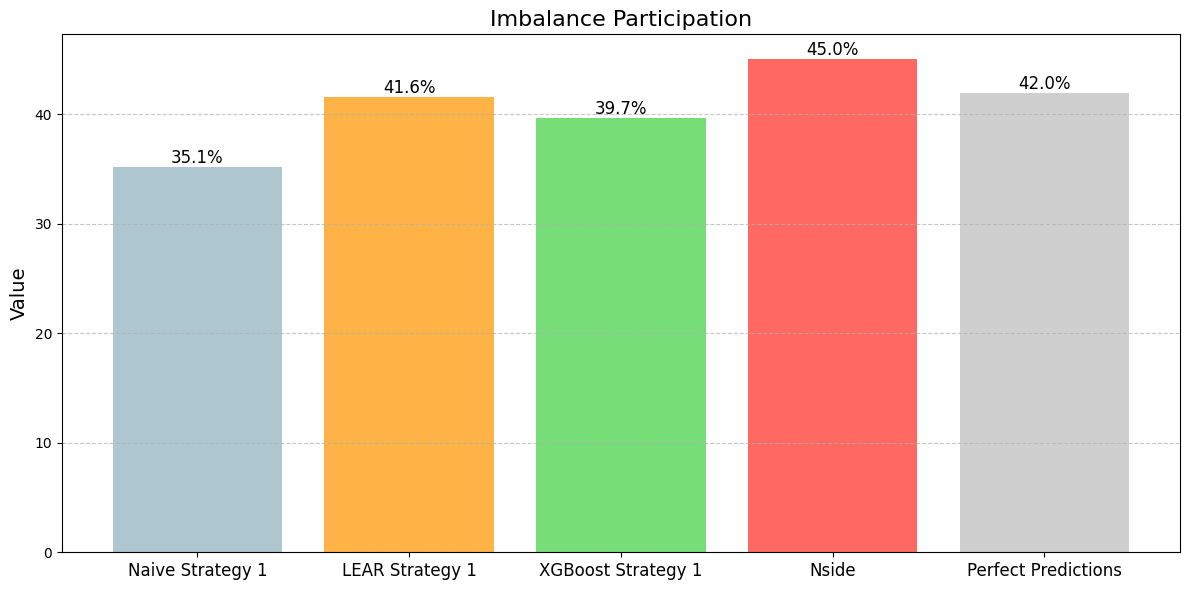

In [ ]:
strategy_1 = 'Strategy 1'
# metric_key='Correct Predictions'
metric_key='Imbalance Participation'
selected_keys = [f'Naive {strategy_1}',
                 f'LEAR {strategy_1}',
                 f'XGBoost {strategy_1}',
                 'Nside',
                 'Perfect Predictions']

plot_trade_metrics(metrics, selected_keys, metric_key=metric_key, save=False, filename=f'Results/Plots/Trade Plots/{metric_key} Comparison {strategy} {period}')

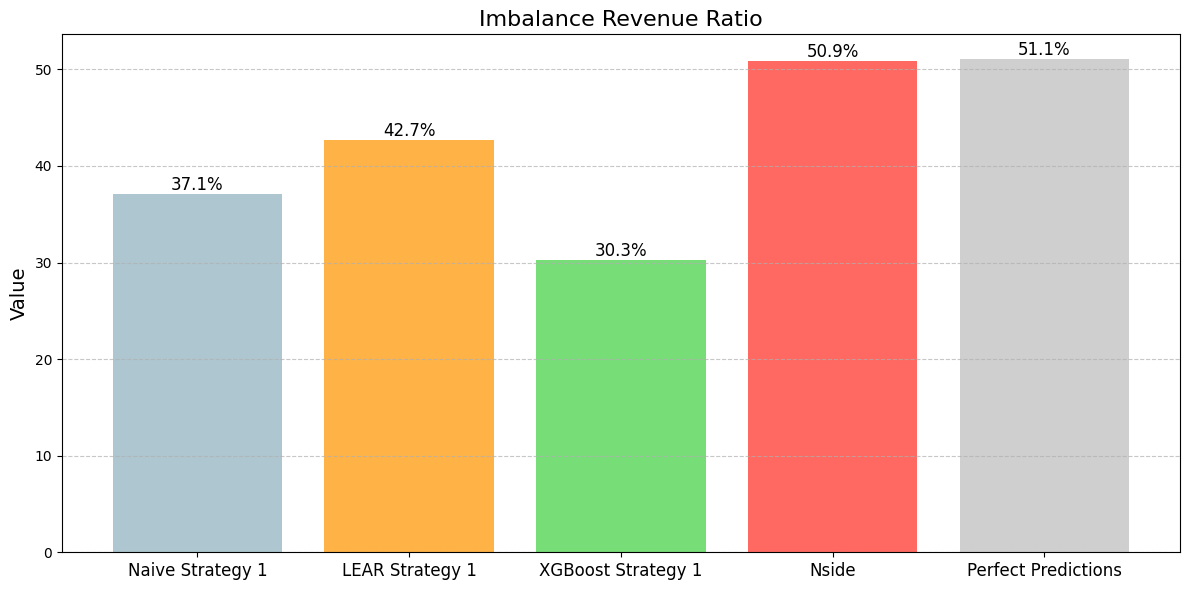

In [ ]:
strategy_1 = 'Strategy 1'
# metric_key='Correct Predictions'
# metric_key='Imbalance Participation'
metric_key='Imbalance Revenue Ratio'
selected_keys = [f'Naive {strategy_1}',
                 f'LEAR {strategy_1}',
                 f'XGBoost {strategy_1}',
                 'Nside',
                 'Perfect Predictions']

plot_trade_metrics(metrics, selected_keys, metric_key=metric_key, save=True, filename=f'Results/Plots/Trade Plots/{metric_key} Comparison {strategy} {period}')

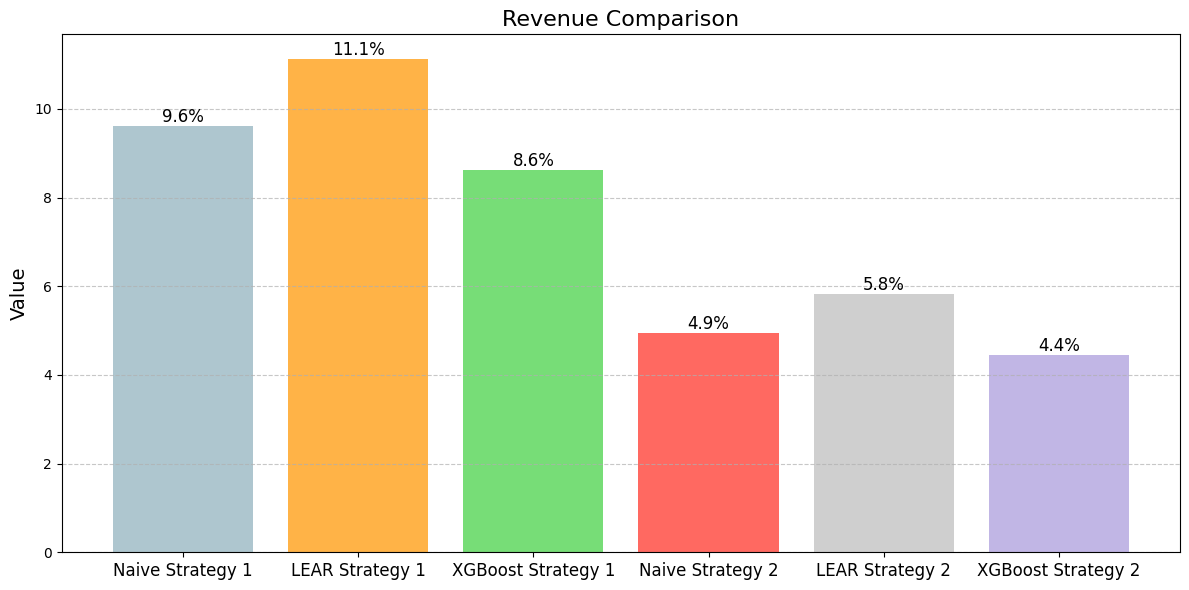

In [ ]:
metric_key='Revenue Increase'

strategy_2 = 'Strategy 2'
selected_keys = [
                 f'Naive {strategy_1}',
                 f'LEAR {strategy_1}',
                 f'XGBoost {strategy_1}',
                 f'Naive {strategy_2}',
                 f'LEAR {strategy_2}',
                 f'XGBoost {strategy_2}',
]

plot_trade_metrics(metrics, selected_keys, metric_key=metric_key, save=True, filename=f'Results/Plots/Trade Plots/{metric_key} Comparison {strategy_2} {period}')

### Inspect Histograms

In [ ]:
revenue, imbalance_participation, correct_predictions, imbalance_revenue_ratio, mask_forecast_LEAR = strategy_1(true_surplus_price, intraday_prices, LEAR_forecasts[0.5])

<Axes: >

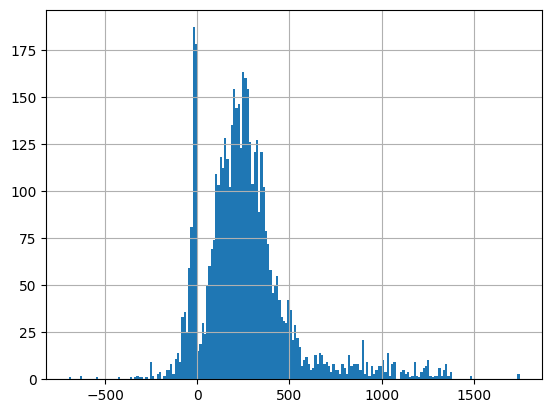

In [ ]:
true_surplus_price[mask_forecast_LEAR].hist(bins=200)

<Axes: >

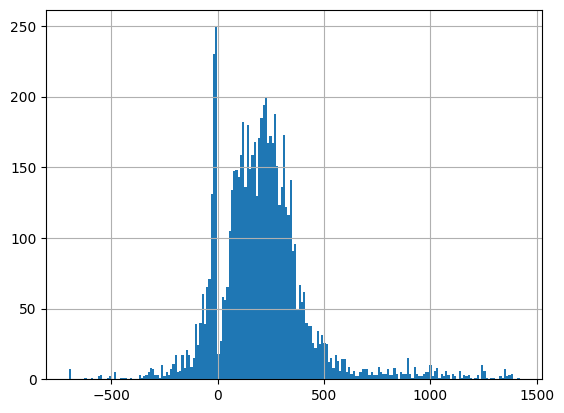

In [ ]:
true_surplus_price[~mask_forecast_LEAR].hist(bins=200)

<Axes: >

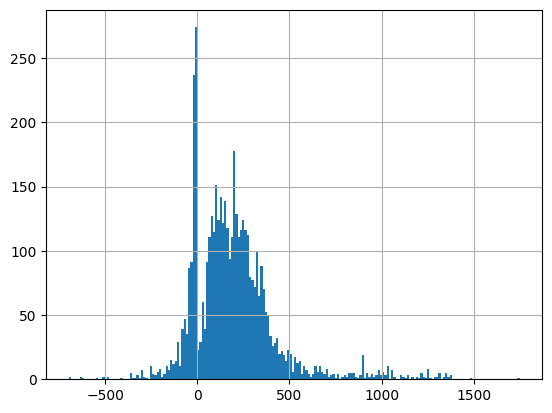

In [ ]:
true_surplus_price[mask_forecast].hist(bins=200)

<Axes: >

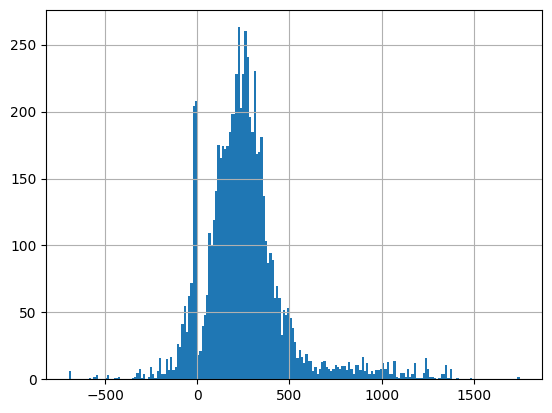

In [ ]:
true_surplus_price[~mask_forecast].hist(bins=200)